In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-dataset/dataset.csv


In [14]:
# Install Relevant Libraries
!pip install lazypredict
!pip install tensorflow-probability

In [238]:
# Linear Algebra and Scientific Computation
import numpy as np
import math
import scipy as sp 
from scipy import stats

# Machine Learning:
import sklearn as sk
import pandas as pd

# Deep Learning:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import keras
from keras import callbacks 
import keras.backend as K

# Feature Engineeering:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif

#Scanner 
import lazypredict
from lazypredict.Supervised import LazyRegressor

# Models
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

#Hypermodel
from sklearn.model_selection import RandomizedSearchCV

# Metrics 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Deal with the imbalanced classes
from sklearn.utils.class_weight import compute_class_weight

# Visualisation Modules:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import figure 
from scipy.stats import gaussian_kde
import seaborn as sns
import plotly.graph_objects as go
rcParams["figure.figsize"] = (20,20)

#Metrics for both Regression and Classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Machine Learning Explainability
import shap

In [16]:
# Generates an upper triangular matrix from the variances and covariances of the predictions
def generate_triu(mean_covariance_matrix, n_targets):
    variances = mean_covariance_matrix[n_targets:2*n_targets]
    covariances = mean_covariance_matrix[2*n_targets:]

    ones = tf.ones((n_targets,n_targets), dtype = tf.float32)
    mask_a = tf.linalg.band_part(ones, 0, -1)
    mask_b = tf.linalg.band_part(ones, 0, 0)
    mask = tf.subtract(mask_a,mask_b)
    zero = tf.constant(0, dtype = tf.float32)
    non_zero = tf.not_equal(mask,zero)
    indices = tf.where(non_zero)
    covariances = tf.sparse.SparseTensor(indices, covariances, dense_shape = tf.cast((n_targets,n_targets), dtype = tf.int64))
    covariances = tf.sparse.to_dense(covariances)
    variances = tf.linalg.diag(variances)
    uncertainties = variances + covariances

    return uncertainties

In [159]:
# returns a fixed set of bin edges
def fixedbinning(xmin, xmax, nbins):
  return np.mgrid[xmin:xmax:nbins*1j]
# returns a fixed set of bin edges
def fixedbinning(xmin, xmax, nbins):
  return np.mgrid[xmin:xmax:nbins*1j]


# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs

def binneddensity(xs, binning, label=None, xlabel=None, ylabel="binned probability density"):
  fig = figure.Figure(figsize=(8, 8))
  plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  plt.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    )

  plt.set_xlabel(xlabel)
  plt.set_ylabel(ylabel)

  return fig

In [17]:
# Takes the means, variances and covariances predicted by the network and computes the multivariate negative likelihood loss
def Multivariate_Gaussian_Negative_Likelihood_Loss_Curve(true, mean_covariance_matrix):
    
    n_targets =  np.shape(true)[1]
    means = mean_covariance_matrix[:,:n_targets]
    uncertainties = tf.map_fn(lambda x: generate_triu(x, n_targets), mean_covariance_matrix, dtype = tf.float32)
    mvn = tfd.MultivariateNormalTriL(loc = means, scale_tril = uncertainties)
    log_likelihood = mvn.log_prob(true)
    return -log_likelihood

In [18]:
# Takes the means, variances and covariances predicted by the network and computes the multivariate negative likelihood loss
def Gaussian_Negative_Likelihood_Loss_Curve(targets, mean_covariance_matrix):
    n_targets = np.shape(targets)[1]
    means = mean_covariance_matrix[:, :n_targets]
    log_variances = mean_covariance_matrix[:, n_targets:2*n_targets]
    log_covariances = mean_covariance_matrix[:, 2*n_targets:]
    
    log_likelihood = tf.reduce_sum(0.5*(K.pow((targets - means),2.0))/(2.0*K.pow(K.exp(log_variances),2.0)) + 0.50*log_variances)# - #(1.0/2.0)*K.log(2.0*tf.constant(np.pi, dtype = tf.float32))
    return log_likelihood

In [65]:
def Laplace_Negative_Likelihood_Loss_Curve(targets, mean_scale_matrix):
    n_targets = tf.shape(targets)[1]
    eps = 1e-6
    means = mean_scale_matrix[:, :n_targets]
    log_scale = mean_scale_matrix[:, n_targets:2*n_targets]
    
    upper_quartile = tfp.stats.percentile(targets, q = 80)
    weights_matrix = tf.where(targets >= upper_quartile, 2.0,1.0)
    
    scale = K.maximum(K.exp(log_scale), eps)
    Bias = tf.reduce_sum((K.abs(targets - means)/(0.5*scale)), axis = 0)
    Variance = tf.reduce_sum(log_scale, axis = 0)
    
    return tf.reduce_sum((Variance + Bias), axis = 0)

In [ ]:
def Laplace_Negative_Likelihood_Loss_Curve(targets, mean_scale_matrix):
    n_targets = np.shape(targets)[1]
    batch_size = np.shape(targets)[0]
    means = mean_scale_matrix[:, :n_targets]
    log_scale = mean_scale_matrix[:, n_targets:2*n_targets]
    
    Bias = tf.reduce_sum(K.abs(targets - means)/(0.5*K.exp(log_scale)), axis = 0)
    Variance = tf.reduce_sum(log_scale, axis = 0)
    return tf.reduce_sum(Variance + Bias, axis = 0)

In [480]:
def Laplace_Negative_Likelihood_Loss_Curve(targets, mean_scale_matrix):
    n_targets = tf.shape(targets)[1]
    batch_size = 64.0
    means = mean_scale_matrix[:, :n_targets]
    log_scale = mean_scale_matrix[:, n_targets:2 * n_targets]

    # Handling small log scale values for numerical stability
    max_log_scale = tf.reduce_max(log_scale, axis=1, keepdims=True)
    exp_log_scale = tf.exp(log_scale - max_log_scale)

    # Bias term
    bias = tf.reduce_sum(K.abs(targets - means) / (0.5 * exp_log_scale), axis=1)

    # Variance term
    variance = tf.reduce_sum(log_scale, axis=1)

    # Total loss
    loss = tf.reduce_sum(variance + bias)

    #Batch-averaging (optional)
    loss = loss / tf.cast(batch_size, dtype=tf.float32)

    return loss

In [20]:
# Takes the means, variances and covariances predicted by the network and computes the multivariate negative likelihood loss
def Normal_Negative_Likelihood_Loss_Curve(targets, mvn):
    log_likelihood = mvn.log_prob(targets)
    return -log_likelihood

In [21]:
# Calculates the mean squared errors for the predictions means
def Mean_Squared_Error(true, meancovs_matrix):
    n_targets = np.shape(true)[1]
    means = meancovs_matrix[:, :n_targets]
    
    return K.mean(K.square(means-true), axis = -1)

In [22]:
#Plots the principle components for the first b_jet 
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [23]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [24]:
# Dataset Generator
def Generator_Regression(df):
    # Create an initial Dataset to explore
    
    df_out = df.copy()
    # Drop columns which cant be saved/not relevant
    df_out.drop(columns = ["prefix", "name", "full_name", "pdes", "id", "equinox"], inplace = True)
    # Add Discovered Logarithmically Varying Features:
    df_out["Log_Diameter"] = np.log(np.maximum(df_out["diameter"], 1e-5))
    df_out["log_e"] = np.log(np.maximum(df_out["e"], 1e-5))
    df_out["log_q"] = np.log(np.maximum(df_out["q"], 1e-5))
    df_out["log_n"] = np.log(np.maximum(df_out["n"], 1e-5))
    df_out["log_moid"] = np.log(np.maximum(df_out["moid"], 1e-5))
    
    df_out = df_out.dropna(subset = ["neo", "pha", "orbit_id", "class", "diameter", "diameter_sigma"])
    
    # Convert the classes Numerical Encodings using OneHotEncoding and LabelEncoding
    NEO_OHE = OneHotEncoder().fit(df_out.neo.values.reshape(-1,1))
    PHA_OHE = OneHotEncoder().fit(df_out.pha.values.reshape(-1,1))
    Class_OHE = OneHotEncoder().fit(df_out["class"].values.reshape(-1,1))
    Orbit_LE = LabelEncoder().fit(df_out.orbit_id.values.reshape(-1,1))

    NEO = pd.DataFrame(NEO_OHE.transform(df_out.neo.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["neo_n", "neo"])
    PHA = pd.DataFrame(PHA_OHE.transform(df_out.pha.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["pha_n", "pha"])
    Class = pd.DataFrame(Class_OHE.transform(df_out["class"].values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["AMO", "APO", "AST", "ATE", "CEN","IMB", "MBA", "MCA", "OMB", "TJN", "TNO", ])
    orbit_id = pd.DataFrame(Orbit_LE.transform(df_out.orbit_id.values), index = df_out.index, columns = ["orbit_id"])

    OneHotEmbeddings = pd.concat([NEO, PHA, Class], axis = 1)
    
    df_out.drop(columns = ["pha", "neo", "class", "orbit_id"], inplace = True)
    df_out = pd.concat([df_out, OneHotEmbeddings, orbit_id], axis = 1)
    df_out.drop(columns = ["neo_n", "pha_n"], inplace = True)
  
    # Reduce the number of target columns for the class based on it's unbalanced nature
    func = lambda x : 1.0 if not(x.MBA != 0.0 or x.OMB != 0.0) else 0.0
    df_out["Other"] = df_out.apply(func, axis = 1)
    df_out["Other"].value_counts()

    # Filter the Dataset
    df_out.drop(columns = ["AMO", "APO", "AST", "ATE", "CEN", "IMB", "MCA", "TJN", "TNO"], inplace = True)
    
    # Perform Experimential Iterative Imputation on the data
    df_out = pd.DataFrame(IterativeImputer(random_state = 42, skip_complete = True).fit_transform(df_out), columns = df_out.columns)

    return df_out

In [25]:
# Read the Asteroid Dataset
Dataset = pd.read_csv("/kaggle/input/asteroid-dataset/dataset.csv")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [26]:
Dataset = Generator_Regression(Dataset)
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136081 entries, 0 to 136080
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           136081 non-null  float64
 1   H               136081 non-null  float64
 2   diameter        136081 non-null  float64
 3   albedo          136081 non-null  float64
 4   diameter_sigma  136081 non-null  float64
 5   epoch           136081 non-null  float64
 6   epoch_mjd       136081 non-null  float64
 7   epoch_cal       136081 non-null  float64
 8   e               136081 non-null  float64
 9   a               136081 non-null  float64
 10  q               136081 non-null  float64
 11  i               136081 non-null  float64
 12  om              136081 non-null  float64
 13  w               136081 non-null  float64
 14  ma              136081 non-null  float64
 15  ad              136081 non-null  float64
 16  n               136081 non-null  float64
 17  tp        

In [27]:
Train_Dataset, Test_Dataset = train_test_split(Dataset, random_state = 42, test_size = 0.2)
Train_Dataset.info(), Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108864 entries, 79278 to 121958
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108864 non-null  float64
 1   H               108864 non-null  float64
 2   diameter        108864 non-null  float64
 3   albedo          108864 non-null  float64
 4   diameter_sigma  108864 non-null  float64
 5   epoch           108864 non-null  float64
 6   epoch_mjd       108864 non-null  float64
 7   epoch_cal       108864 non-null  float64
 8   e               108864 non-null  float64
 9   a               108864 non-null  float64
 10  q               108864 non-null  float64
 11  i               108864 non-null  float64
 12  om              108864 non-null  float64
 13  w               108864 non-null  float64
 14  ma              108864 non-null  float64
 15  ad              108864 non-null  float64
 16  n               108864 non-null  float64
 17  tp         

(None, None)

In [28]:
# Identify the Initial Set of Features:
Classification_Targets = ["MBA", "OMB", "Other", "neo", "pha"] 
Regression_Targets = ["diameter","Log_Diameter", "diameter_sigma"]

# Identify the Features:
columns = set(Dataset.columns)
Features = list(columns - set(Regression_Targets))

In [29]:
Selected_Features = ["log_moid", "H", "log_q", "log_e", \
                     "moid", "e", "log_n", "q", "n", "i", "rms",\
                     "a", "albedo", "tp", "ad", "per", "per_y", \
                    "tp_cal", "om", "sigma_om", "orbit_id"] + Classification_Targets
Selected_Features

['log_moid',
 'H',
 'log_q',
 'log_e',
 'moid',
 'e',
 'log_n',
 'q',
 'n',
 'i',
 'rms',
 'a',
 'albedo',
 'tp',
 'ad',
 'per',
 'per_y',
 'tp_cal',
 'om',
 'sigma_om',
 'orbit_id',
 'MBA',
 'OMB',
 'Other',
 'neo',
 'pha']

In [30]:
# To perform the classification split the dataset into training and validaiton sets
X, y_reg, y_cla = Train_Dataset.query("diameter>0")[Selected_Features], Train_Dataset.query("diameter>0")[Regression_Targets], Train_Dataset.query("diameter>0")[Classification_Targets]
X_train_Reg, X_valid_Reg, y_train_Reg, y_valid_Reg = train_test_split(X, y_reg, test_size = 0.2, random_state = 21)
_, _, y_train_Cla, y_valid_Cla = train_test_split(X, y_cla, test_size = 0.2, random_state = 21)
X_train_Reg.shape, y_train_Reg.shape, y_train_Cla.shape

((87091, 26), (87091, 3), (87091, 5))

In [31]:
Numerical = list(set(Selected_Features) - set(Classification_Targets + ["orbit_id"]))
Standardized_X_train = pd.concat([(X_train_Reg[Numerical] - X_train_Reg[Numerical].mean())/(np.maximum(X_train_Reg[Numerical].std(), 1e-6)), X_train_Reg["orbit_id"]], axis = 1)
Standardized_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87091 entries, 8037 to 73292
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   H         87091 non-null  float64
 1   a         87091 non-null  float64
 2   n         87091 non-null  float64
 3   moid      87091 non-null  float64
 4   rms       87091 non-null  float64
 5   albedo    87091 non-null  float64
 6   log_e     87091 non-null  float64
 7   tp_cal    87091 non-null  float64
 8   per       87091 non-null  float64
 9   log_moid  87091 non-null  float64
 10  ad        87091 non-null  float64
 11  e         87091 non-null  float64
 12  log_n     87091 non-null  float64
 13  log_q     87091 non-null  float64
 14  i         87091 non-null  float64
 15  q         87091 non-null  float64
 16  sigma_om  87091 non-null  float64
 17  om        87091 non-null  float64
 18  tp        87091 non-null  float64
 19  per_y     87091 non-null  float64
 20  orbit_id  87091 non-null  floa

In [32]:
Numerical = list(set(Selected_Features) - set(Classification_Targets + ["orbit_id"]))
Standardized_X_valid = pd.concat([(X_valid_Reg[Numerical] - X_valid_Reg[Numerical].mean())/(np.maximum(X_valid_Reg[Numerical].std(), 1e-6)), X_valid_Reg["orbit_id"]], axis = 1) 
Standardized_X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21773 entries, 58232 to 129756
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   H         21773 non-null  float64
 1   a         21773 non-null  float64
 2   n         21773 non-null  float64
 3   moid      21773 non-null  float64
 4   rms       21773 non-null  float64
 5   albedo    21773 non-null  float64
 6   log_e     21773 non-null  float64
 7   tp_cal    21773 non-null  float64
 8   per       21773 non-null  float64
 9   log_moid  21773 non-null  float64
 10  ad        21773 non-null  float64
 11  e         21773 non-null  float64
 12  log_n     21773 non-null  float64
 13  log_q     21773 non-null  float64
 14  i         21773 non-null  float64
 15  q         21773 non-null  float64
 16  sigma_om  21773 non-null  float64
 17  om        21773 non-null  float64
 18  tp        21773 non-null  float64
 19  per_y     21773 non-null  float64
 20  orbit_id  21773 non-null  fl

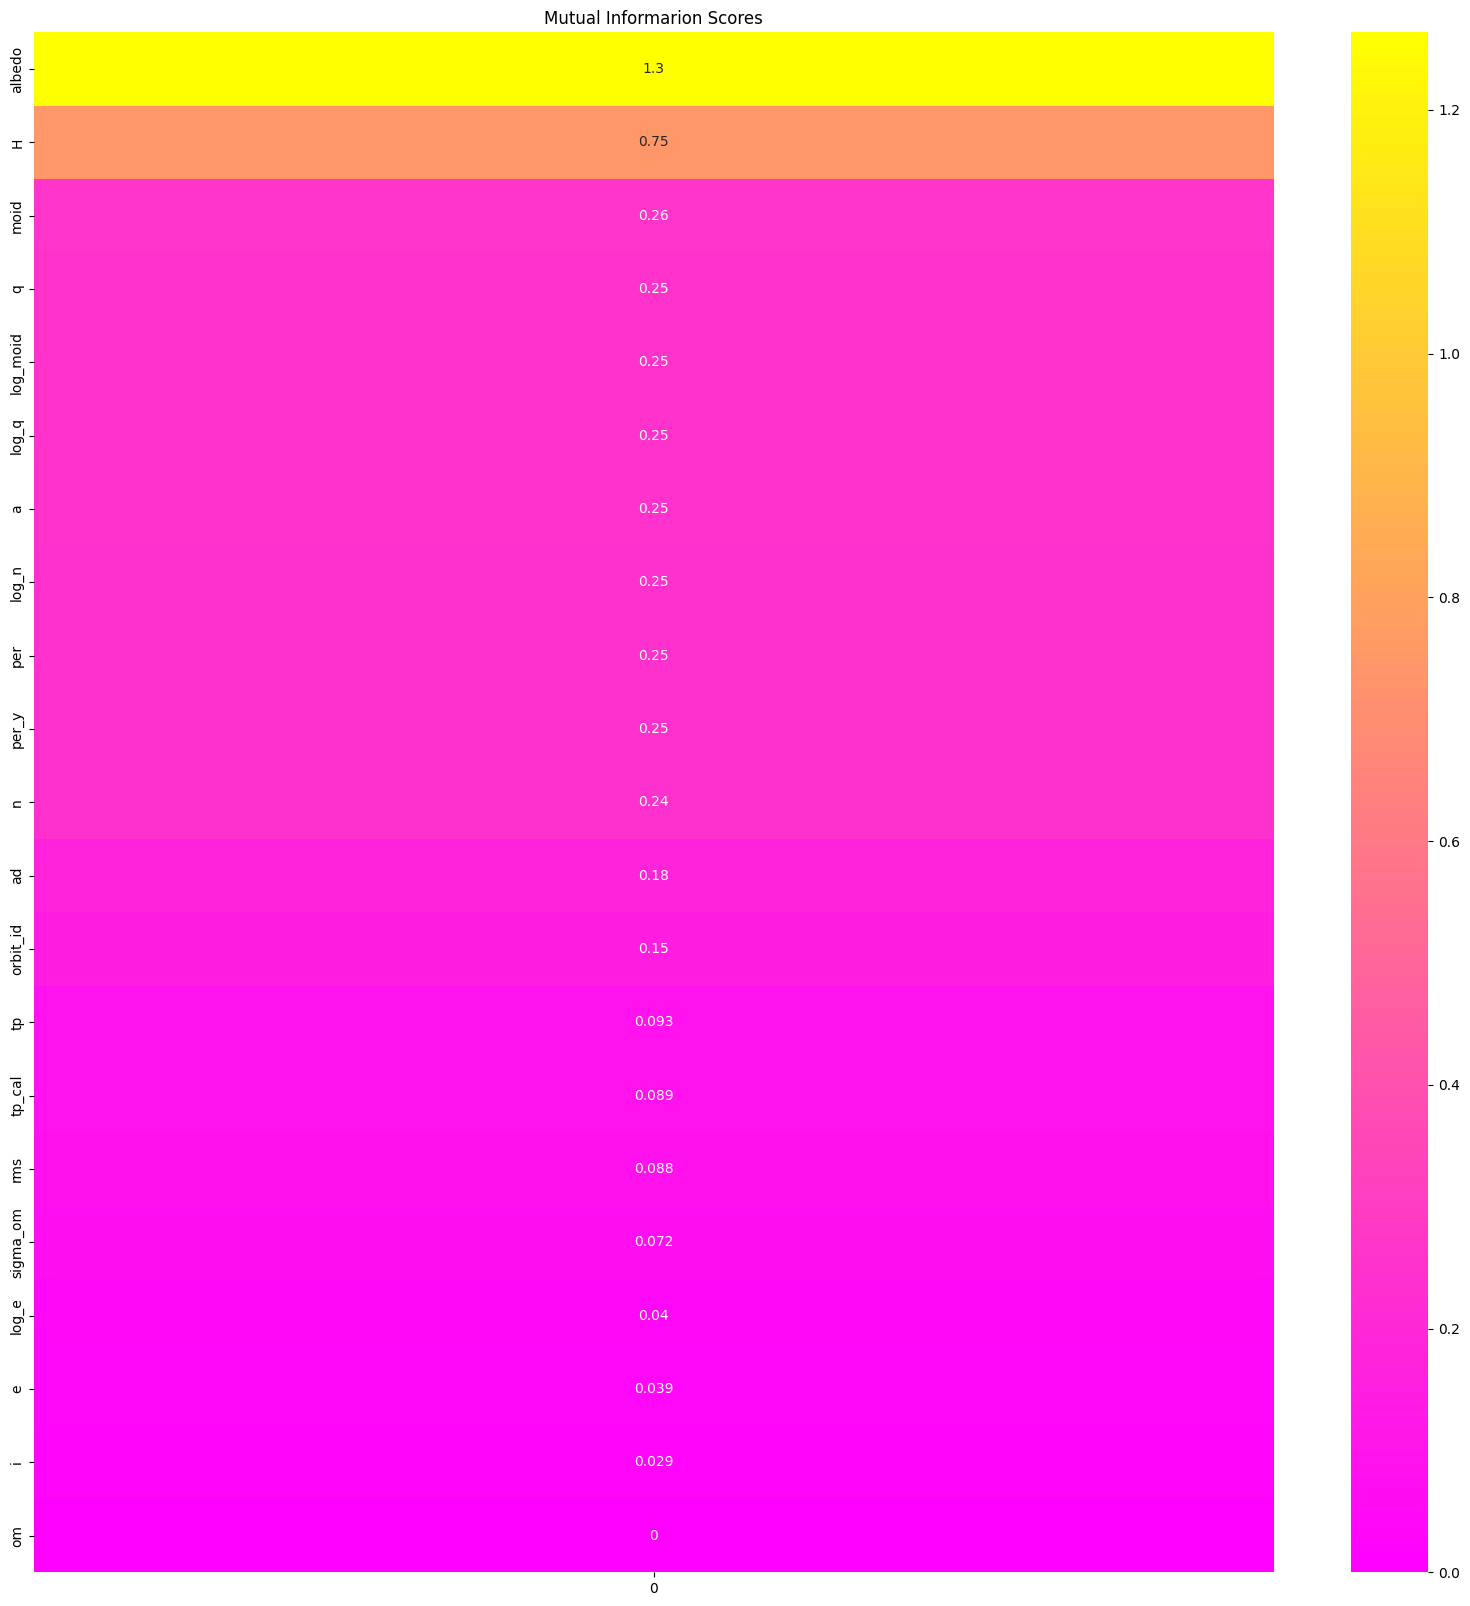

In [22]:
mutual_information_reg = make_mi_scores(Standardized_X_train, y_train_Reg.iloc[:,0], categoric_values = "auto")
plot_mi_scores(mutual_information_reg, cmap = "spring")

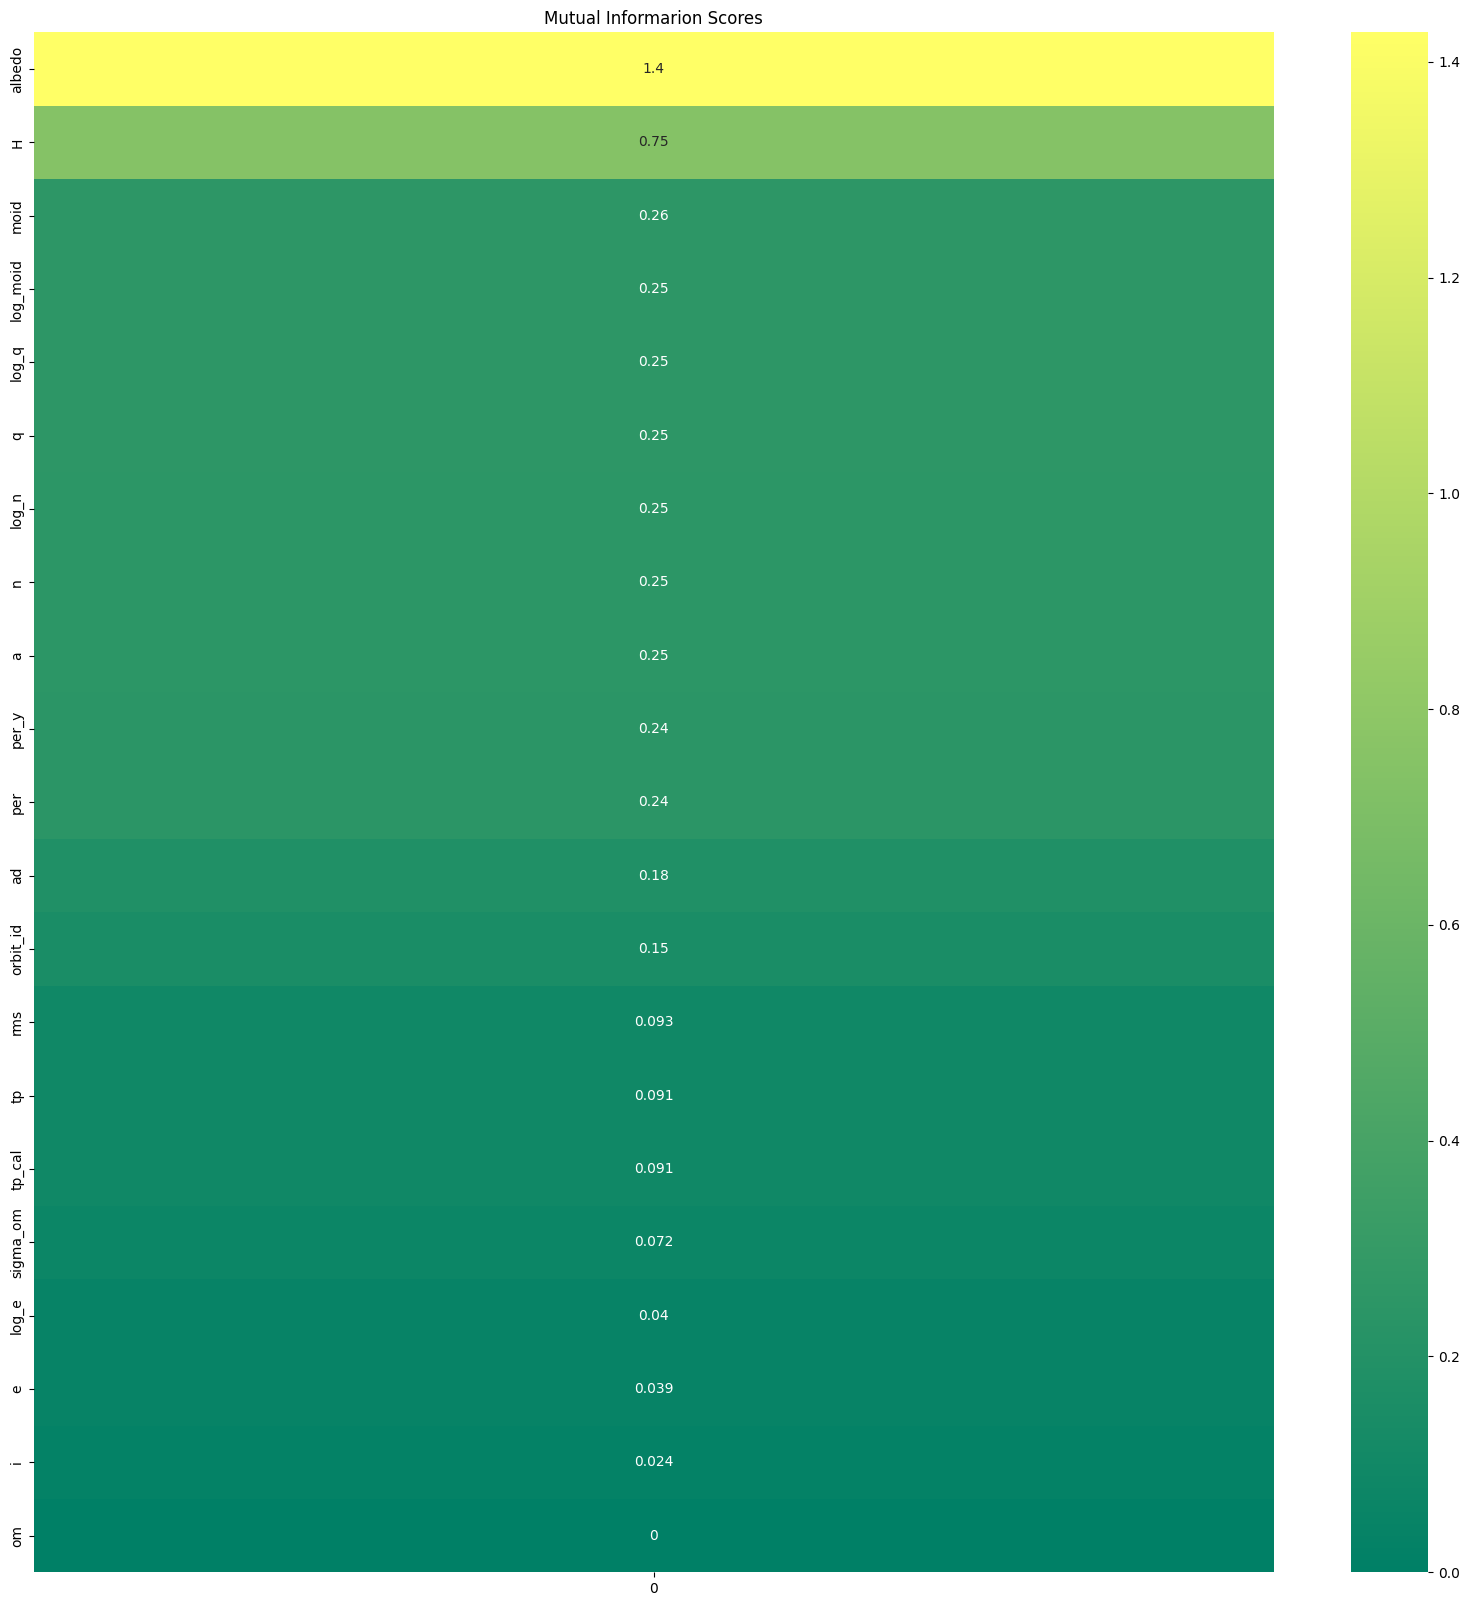

In [23]:
mutual_information_reg = make_mi_scores(Standardized_X_train, y_train_Reg.iloc[:,1], categoric_values = "auto")
plot_mi_scores(mutual_information_reg, cmap = "summer")

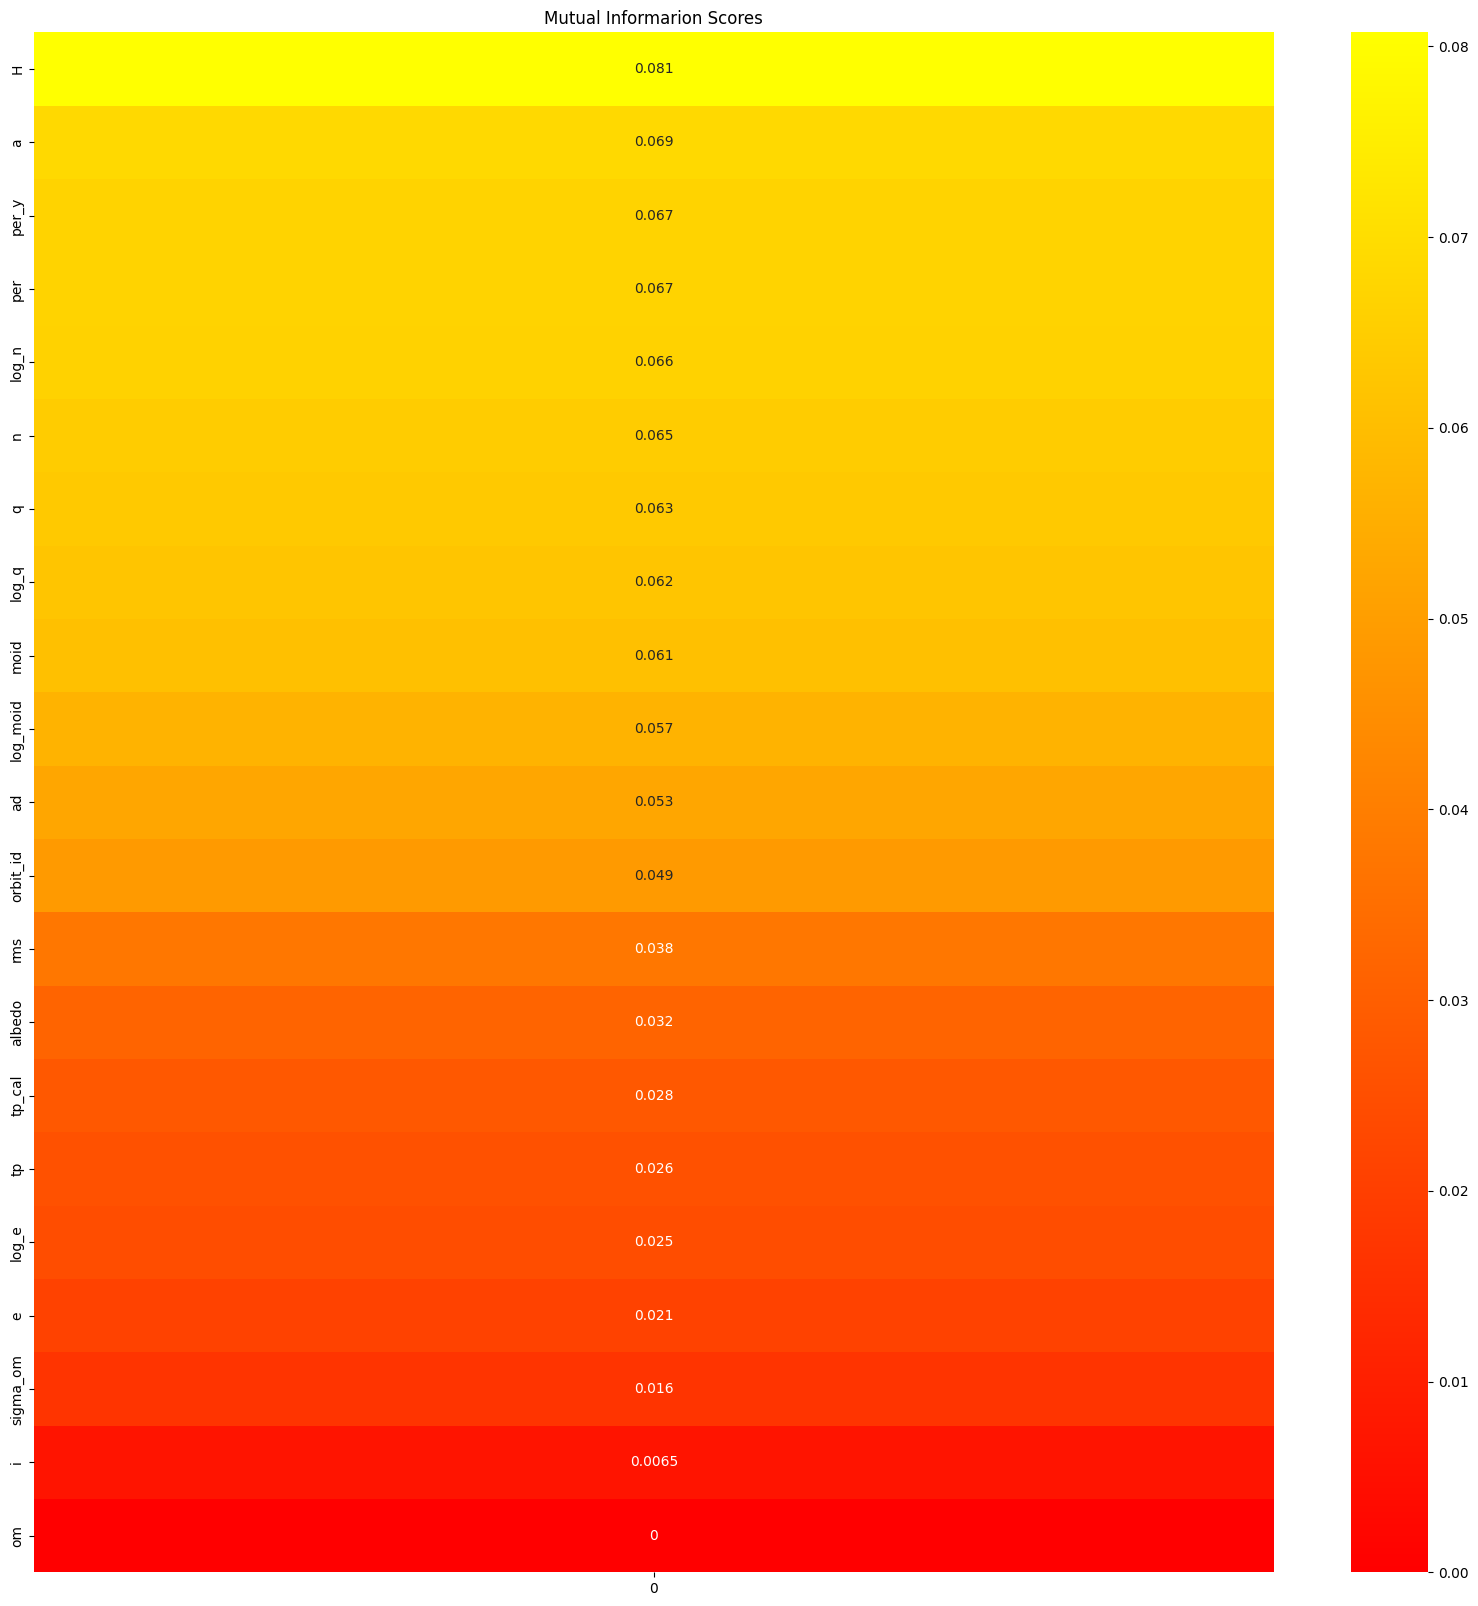

In [24]:
mutual_information_reg = make_mi_scores(Standardized_X_train, y_train_Reg.iloc[:,2], categoric_values = "auto")
plot_mi_scores(mutual_information_reg, cmap = "autumn")

In [25]:
def Regression_Baseline(n_features, n_reg_targets, hidden_layers, dropout_rate, optimizer, loss_curve_reg, jit, metric_system):
    
    inputs = tf.keras.layers.Input(shape = (n_features,))
    x = tf.keras.layers.BatchNormalization()(inputs)
    
    for perceptrons in hidden_layers:
        x = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
    
    Out = tf.keras.layers.Dense(units = n_reg_targets, activation = "linear")(x)
    #out_log_variances = tf.keras.layers.Dense(units = n_reg_targets, activation = "linear")(x)
    #out_log_covariances = tf.keras.layers.Dense(units = n_reg_targets*(n_reg_targets-1)/2, activation = "linear")(x)
    #Out = tf.keras.layers.concatenate([out_means, out_log_variances, out_log_covariances])
    Model = tf.keras.Model(inputs = inputs, outputs = Out)
    
    Model.compile(
    optimizer = optimizer,
    loss = loss_curve_reg,
    jit_compile = jit,
    metrics = metric_system,
    )
    return Model
    

In [26]:
# Define the prior distribution for the kernel and bias to follow
# Assume standard distribution as the prior. During training the neural network 
# updates the prior through variational inference.
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
    [
        tfp.layers.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc = tf.zeros(n), scale_diag = tf.ones(n),
        )
        )
    ]
    )
    return prior_model

# Defines a variational posterior weight distribution using a multivariate gaussian distribution
# During training,the network learns the means, variances and covariances of its weights
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
    [
        tfp.layers.VariableLayer(
        tfp.layers.MultivariateNormalTriL.params_size(n), dtype = dtype
        ),
        tfp.layers.MultivariateNormalTriL(n)
    ]
    )
    return posterior_model

In [27]:
def Bayesian_Neural_net(train_size, n_features, n_reg_targets, n_cla_targets, hidden_layers, optimizer, loss_curve_reg, loss_curve_cla, jit, metric_system):
    inputs = tf.keras.Input(shape = (n_features,))
    outputs = tf.keras.layers.BatchNormalization()(inputs)
    
    for perceptrons in hidden_layers:
        outputs = tfp.layers.DenseVariational(
            units = perceptrons,
            make_prior_fn = prior,
            make_posterior_fn = posterior,
            kl_weight = 1/train_size,
            activation = "gelu"
        )(outputs)
        outputs = tf.keras.layers.BatchNormalization()(outputs)
    
    Outputs = tf.keras.layers.Dense(n_reg_targets*4, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
    Outputs = tf.keras.layers.Dense(n_reg_targets*2, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
    Outputs_Regression = tfp.layers.IndependentNormal(n_reg_targets, name = "Regression")(Outputs)
    
    Outputs_classification = tf.keras.layers.Dense(n_cla_targets*2, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(Outputs)
    Outputs_classification = tf.keras.layers.Dense(n_cla_targets, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(Outputs_classification)
    Outputs_Class = tfp.layers.IndependentBernoulli(n_cla_targets, name = "Classification")(Outputs_classification)
    
    Model = tf.keras.Model(inputs = inputs, outputs = [Outputs_Regression, Outputs_Class])
    
    Model.compile(
    optimizer = optimizer,
    loss = {"Regression":loss_curve_reg, "Classification":loss_curve_cla},
    jit_compile = jit,
    metrics = metric_system,
    )
    return Model

In [250]:
def Asteroid_Neural_net(train_size, n_features, n_reg_targets, n_cla_targets, hidden_layers, optimizer, loss_curve_reg, loss_curve_cla, jit, metric_system, dropout_rate = 0.3):
    inputs = tf.keras.Input(shape = (n_features,))
    outputs = tf.keras.layers.LayerNormalization()(inputs)
    
    i = 0
    for perceptrons in hidden_layers:
        if i == 0:
            outputs = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
            outputs = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal")(outputs)
            outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
            out = tf.keras.layers.LayerNormalization()(outputs)
            i+=1
        else:
            outputs = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(out)
            outputs = tf.keras.layers.Dense(units = perceptrons, activation = "gelu", kernel_initializer = "he_normal")(outputs)
            outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
            outputs = tf.keras.layers.LayerNormalization()(outputs)
            out = tf.keras.layers.Add()([outputs, out])
            out = tf.keras.layers.LayerNormalization()(out)
        
    
    Outputs = tf.keras.layers.Dense(n_reg_targets*3, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1")(out)
    Outputs = tf.keras.layers.LayerNormalization()(Outputs)
    Outputs = tf.keras.layers.Dense(n_reg_targets*2, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l2")(outputs)
    Outputs = tf.keras.layers.LayerNormalization()(Outputs)
 
    Outputs_Regression_means = tf.keras.layers.Dense(n_reg_targets, activation = "linear")(Outputs)
    Outputs_Regression_Variances = tf.keras.layers.Dense(n_reg_targets, activation = "exponential")(Outputs)
    
    Outputs_Regression = tf.keras.layers.concatenate([Outputs_Regression_means, Outputs_Regression_Variances], name = "Regression")
    
    Outputs_classification = tf.keras.layers.Dense(n_reg_targets + n_reg_targets, activation = "gelu", kernel_initializer = "he_normal")(Outputs)
    Outputs_classification = tf.keras.layers.LayerNormalization()(Outputs_classification)
    Outputs_classification = tf.keras.layers.Add()([Outputs_Regression, Outputs_classification])
    Outputs_classification = tf.keras.layers.Dense(n_cla_targets*2, activation = "selu", kernel_initializer = "lecun_normal", kernel_regularizer = "l1_l2")(Outputs_classification)
    Outputs_Class = tf.keras.layers.Dense(n_cla_targets, activation = "sigmoid", kernel_initializer = "glorot_uniform", name = "Classification")(Outputs_classification)
    
    Model = tf.keras.Model(inputs = inputs, outputs = [Outputs_Regression, Outputs_Class])
    
    Model.compile(
    optimizer = optimizer,
    loss = {"Regression":loss_curve_reg, "Classification":loss_curve_cla},
    jit_compile = jit,
    metrics = metric_system,
    )
    return Model

In [37]:
y_train_Reg["Log_diameter_sigma"] = np.log(y_train_Reg["diameter_sigma"])

In [38]:
y_valid_Reg["Log_diameter_sigma"] = np.log(y_valid_Reg["diameter_sigma"])

array([[<Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'Log_Diameter'}>],
       [<Axes: title={'center': 'diameter_sigma'}>,
        <Axes: title={'center': 'Log_diameter_sigma'}>]], dtype=object)

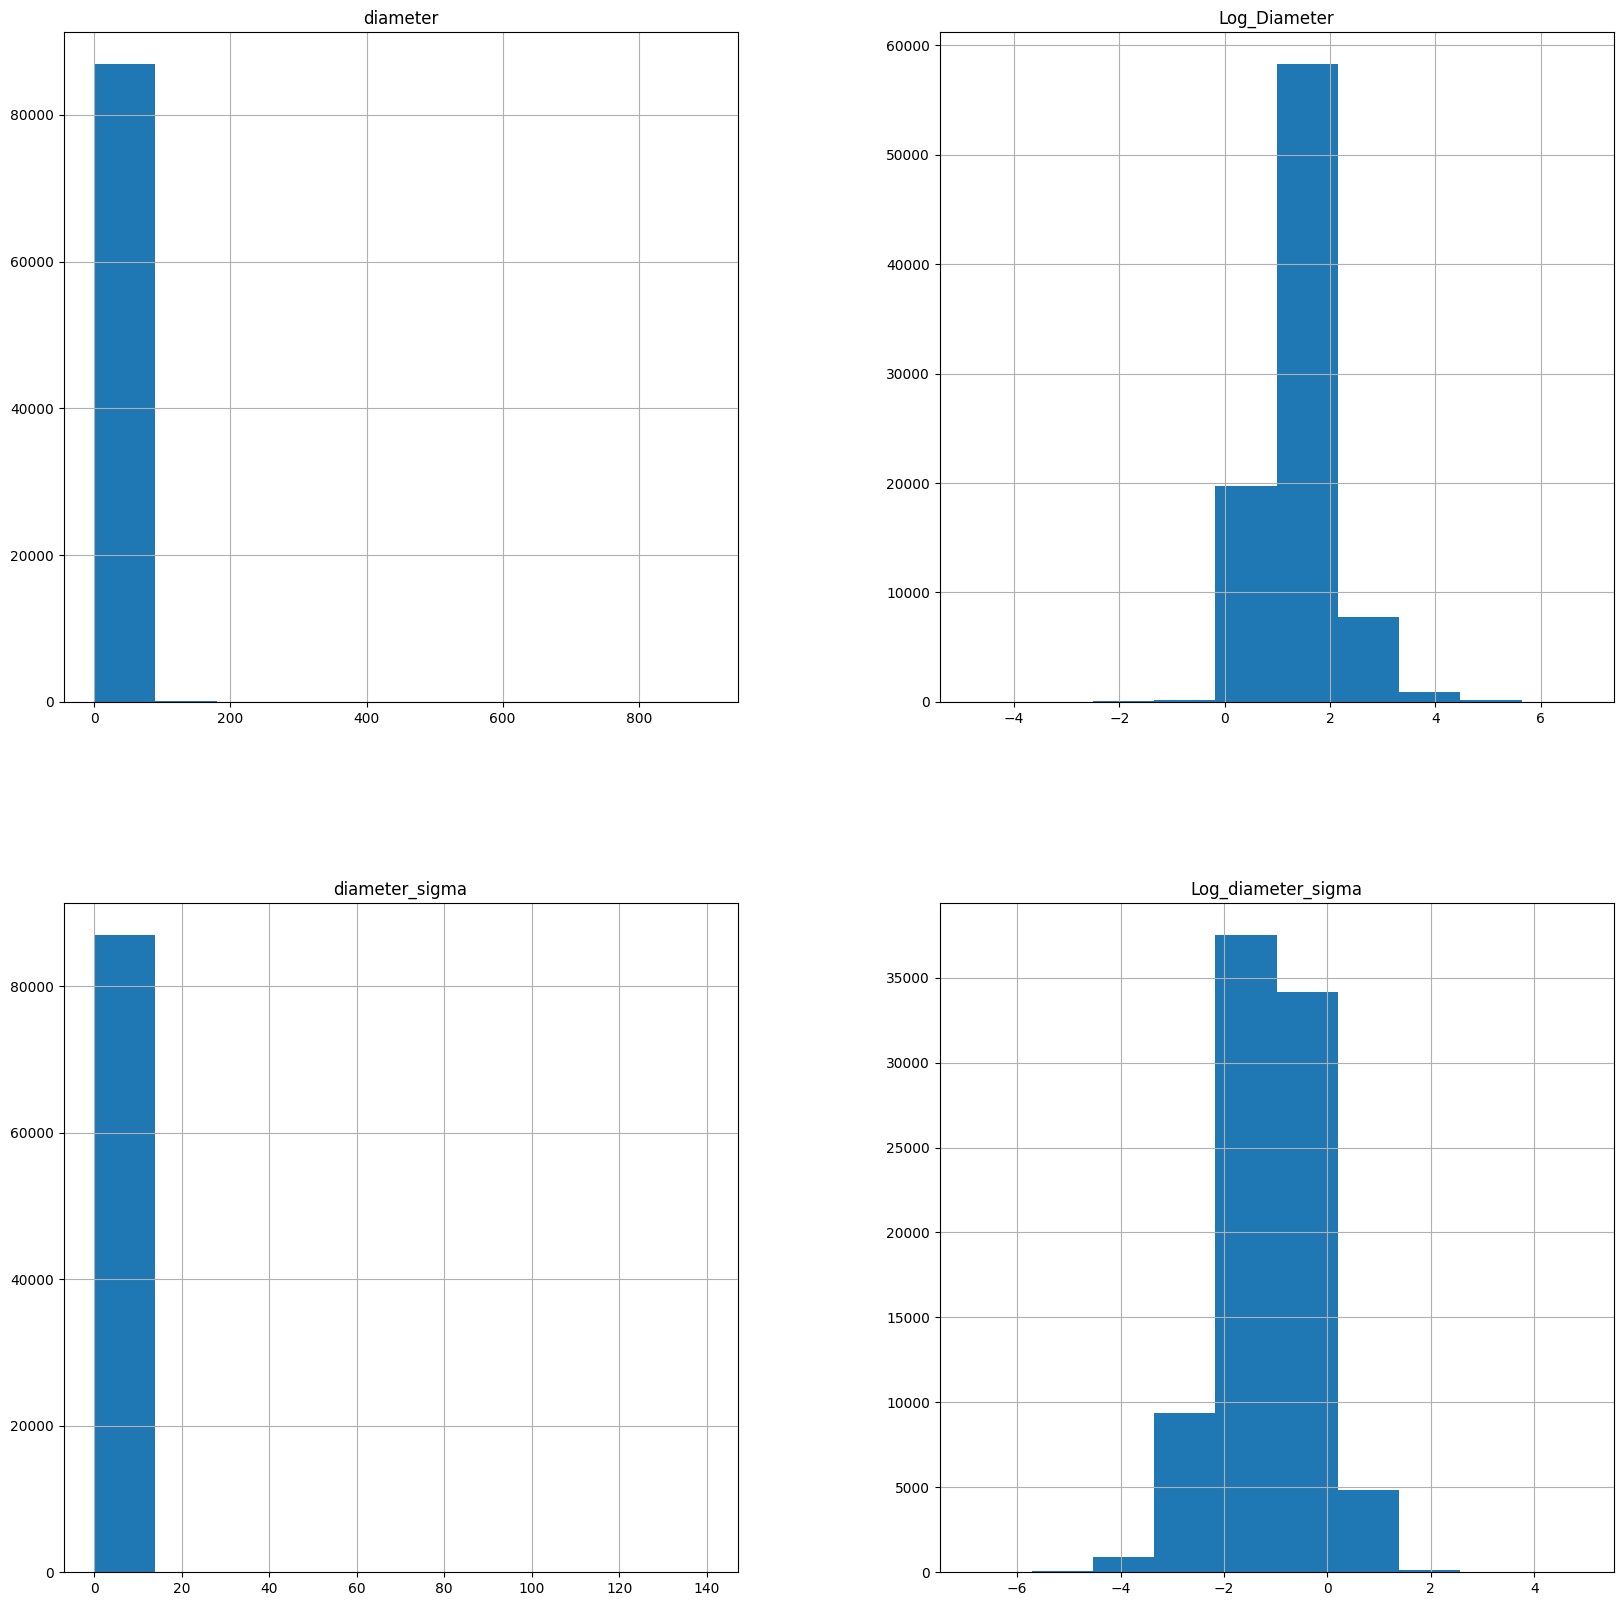

In [448]:
y_train_Reg.hist()

In [39]:
def Negative_Binomial_Likelihood(y_true, estimated_distribution):
    return -estimated_distribution.log_prob(y_true)

In [282]:
# Set up the optimizer, metrics and loss function
learning_rate = 5e-4
Optimizer = keras.optimizers.Nadam(learning_rate, use_ema = True)
Loss_curve_reg = tf.keras.losses.mae
Loss_curve_cla = Negative_Binomial_Likelihood
jitter = True
metrics = [tf.keras.losses.mse, tf.keras.losses.mae]
dropout_rate = 0.3

In [113]:
Baseline_Net = Regression_Baseline(Standardized_X_train.shape[1], 2, [128,128,128,128], dropout_rate, Optimizer, Loss_curve_reg, jitter, metrics)
Baseline_Net.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 21)]              0         
                                                                 
 batch_normalization_50 (Ba  (None, 21)                84        
 tchNormalization)                                               
                                                                 
 dense_90 (Dense)            (None, 128)               2816      
                                                                 
 dense_91 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_51 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_92 (Dense)            (None, 128)               165

In [44]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=12,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)

# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=5, min_lr=1e-9)

In [115]:
History = Baseline_Net.fit(
    x = Standardized_X_train, y = y_train_Reg[["Log_Diameter","Log_diameter_sigma"]],
    validation_data = (Standardized_X_valid, y_valid_Reg[["Log_Diameter", "Log_diameter_sigma"]]),
    batch_size = 128, 
    callbacks = [early_stopping, reduce_learn_on_plateau],
    epochs = 200,
    use_multiprocessing = True,
)

Epoch 1/200
681/681 [==============================] - 21s 15ms/step - loss: 0.5539 - mean_squared_error: 0.6919 - mean_absolute_error: 0.5539 - val_loss: 0.3574 - val_mean_squared_error: 0.3286 - val_mean_absolute_error: 0.3574 - lr: 5.0000e-04
Epoch 2/200
681/681 [==============================] - 6s 8ms/step - loss: 0.3539 - mean_squared_error: 0.3110 - mean_absolute_error: 0.3539 - val_loss: 0.3329 - val_mean_squared_error: 0.3029 - val_mean_absolute_error: 0.3329 - lr: 5.0000e-04
Epoch 3/200
681/681 [==============================] - 6s 8ms/step - loss: 0.3346 - mean_squared_error: 0.2911 - mean_absolute_error: 0.3346 - val_loss: 0.3794 - val_mean_squared_error: 0.4334 - val_mean_absolute_error: 0.3794 - lr: 5.0000e-04
Epoch 4/200
681/681 [==============================] - 6s 8ms/step - loss: 0.3284 - mean_squared_error: 0.2855 - mean_absolute_error: 0.3284 - val_loss: 0.3085 - val_mean_squared_error: 0.2734 - val_mean_absolute_error: 0.3085 - lr: 5.0000e-04
Epoch 5/200
681/681 [=

<Axes: >

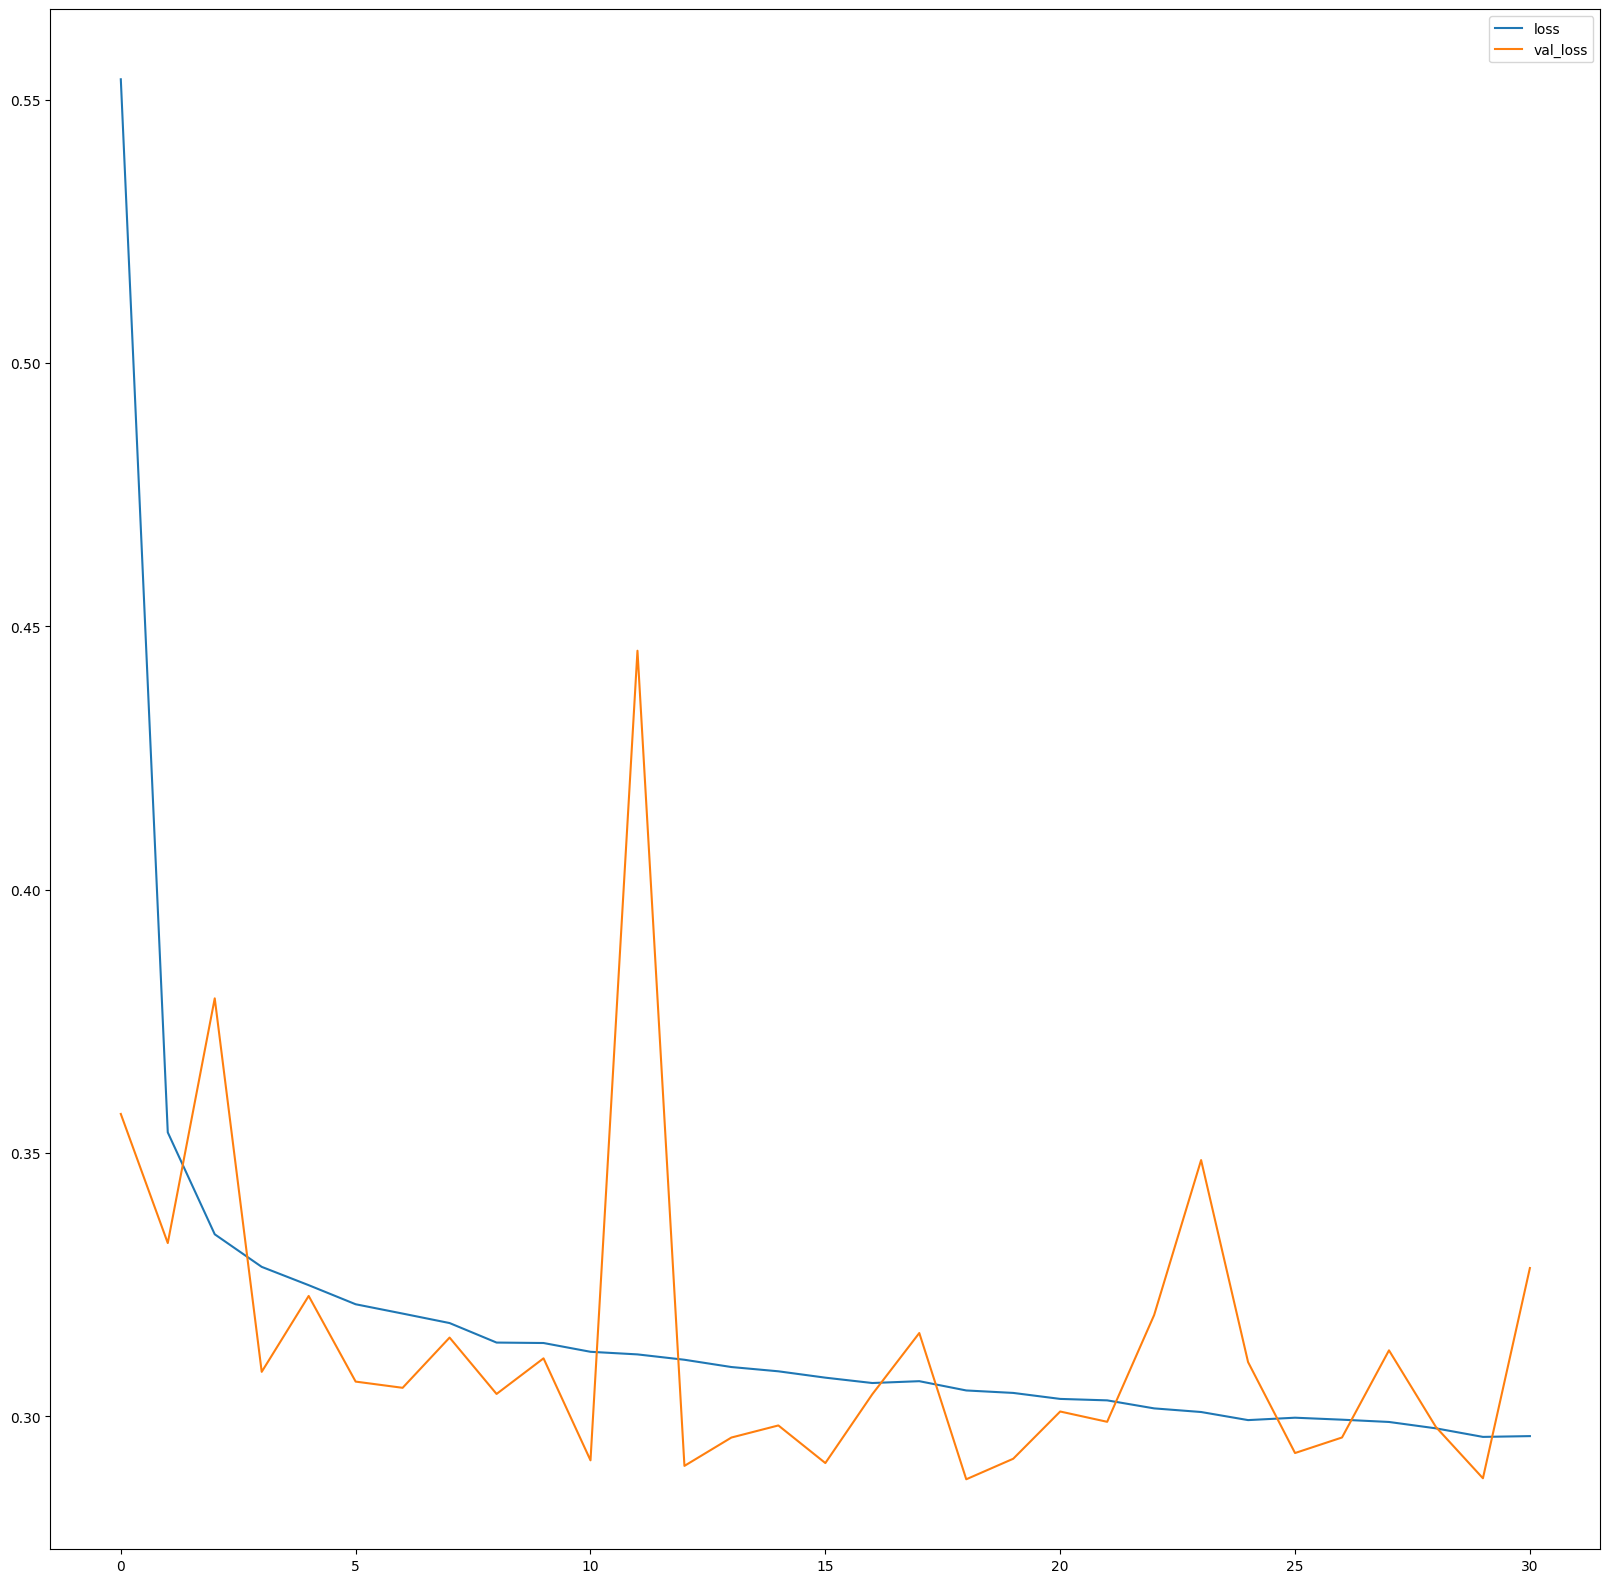

In [116]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(History.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()

In [117]:
Predictions = Baseline_Net.predict(Standardized_X_train)
Predictions.shape

2722/2722 [==============================] - 6s 2ms/step


(87091, 2)

In [118]:
Predictions = pd.DataFrame(Predictions, columns = ["Log_diameter", "Log_diameter_sigma"])
Predictions

,Log_diameter,Log_diameter_sigma
0,1.78,-1.12
1,1.82,-1.62
2,1.26,-2.04
3,2.53,-1.58
4,1.60,-2.18
...,...,...
87086,1.21,-1.18
87087,1.93,-0.96
87088,1.27,-0.39
87089,0.51,-1.19


array([[<Axes: title={'center': 'Log_diameter'}>,
        <Axes: title={'center': 'Log_diameter_sigma'}>]], dtype=object)

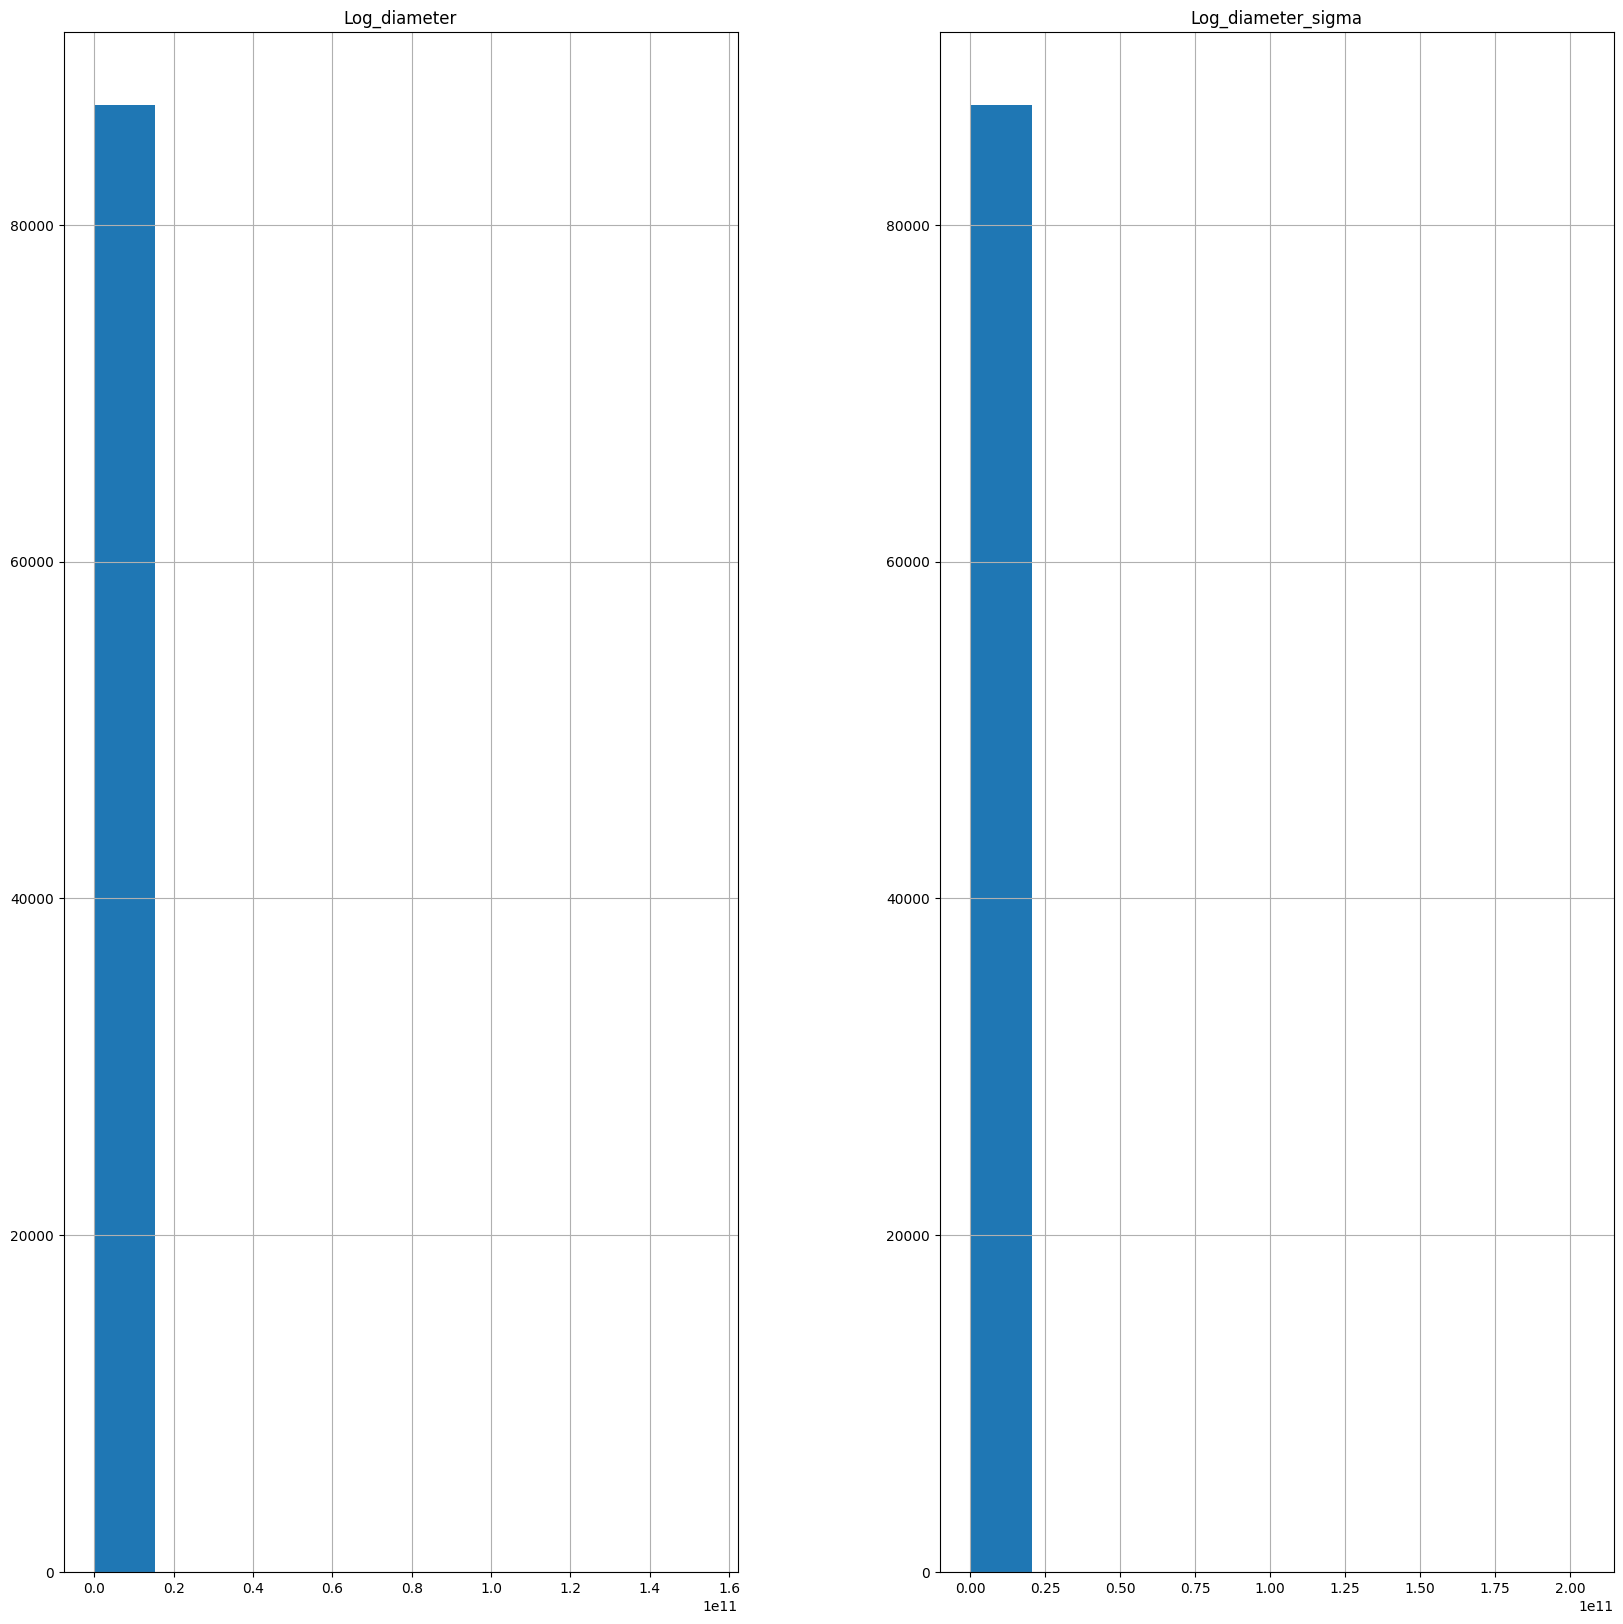

In [119]:
np.exp(Predictions).hist()

array([[<Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'Log_Diameter'}>],
       [<Axes: title={'center': 'diameter_sigma'}>,
        <Axes: title={'center': 'Log_diameter_sigma'}>]], dtype=object)

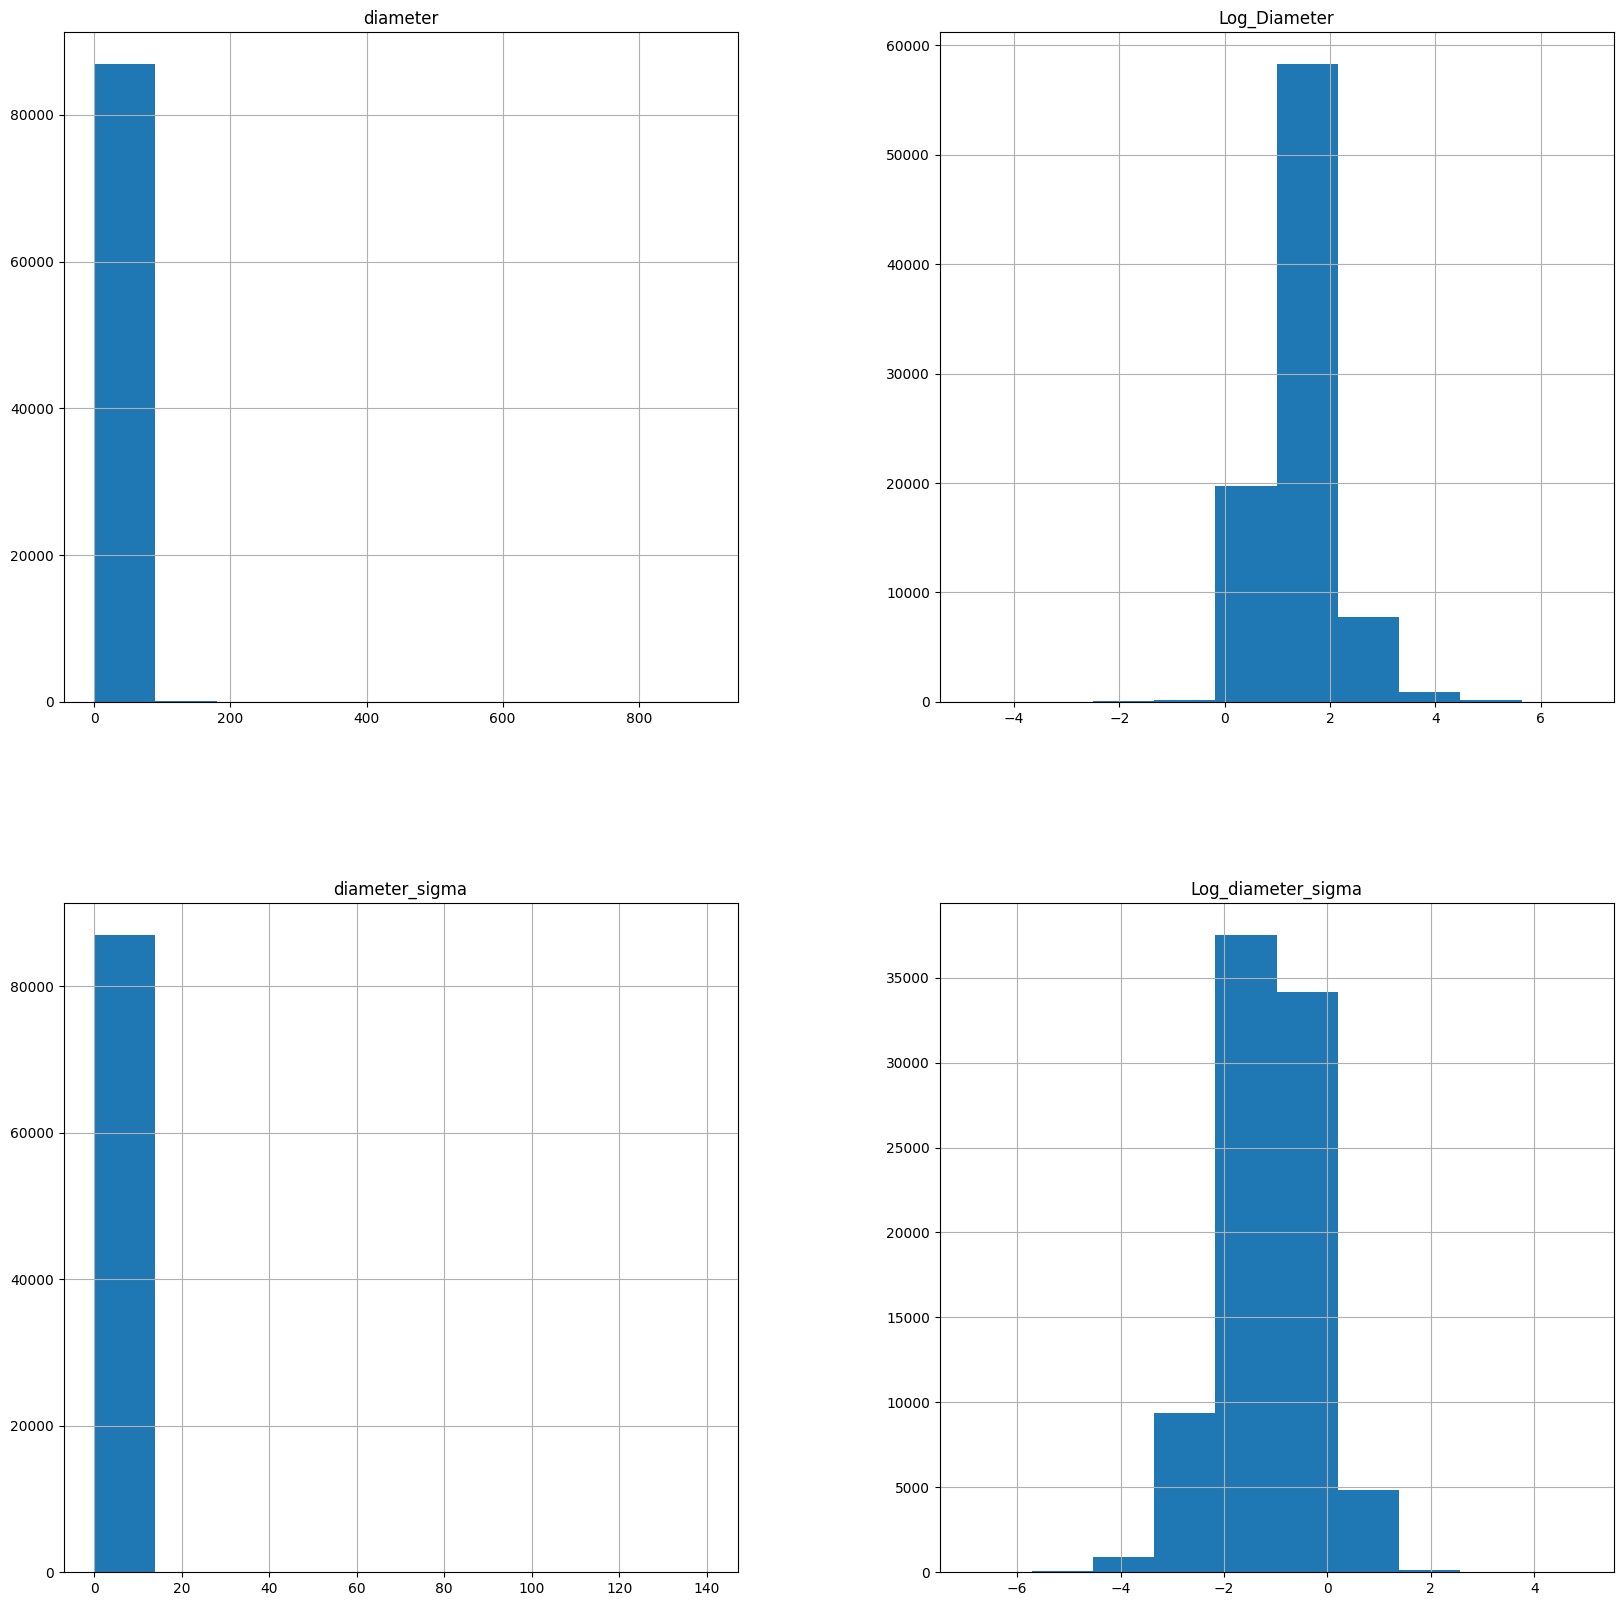

In [120]:
y_train_Reg.hist()

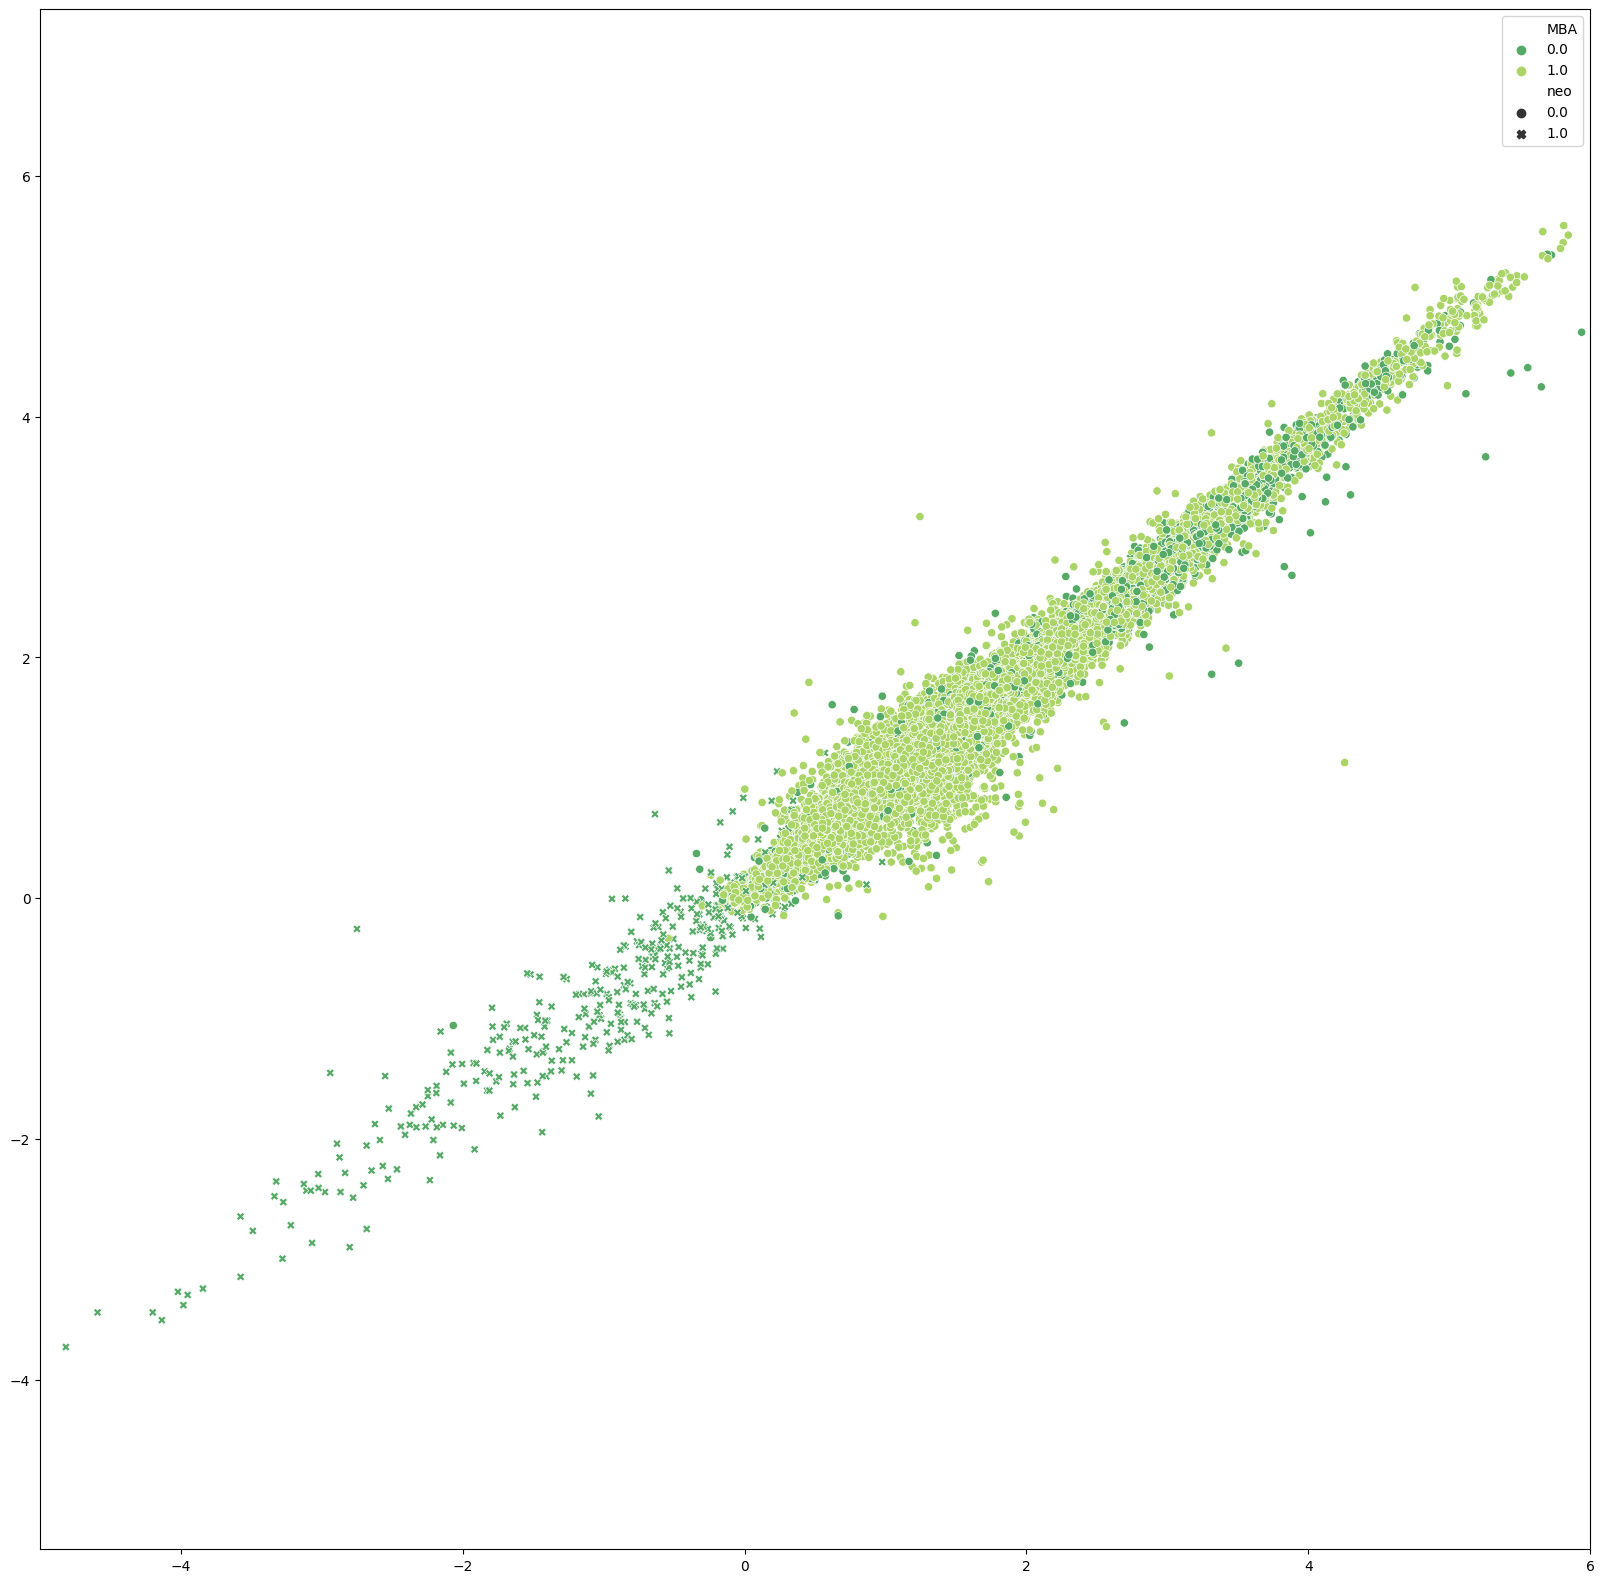

In [123]:
sns.scatterplot(x = Predictions.iloc[:,0].values, y = y_train_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values, hue = y_train_Cla["MBA"],style = y_train_Cla["neo"], palette = "summer")
plt.xlim([-5,6.0])
plt.legend()

(0.0, 300.0)

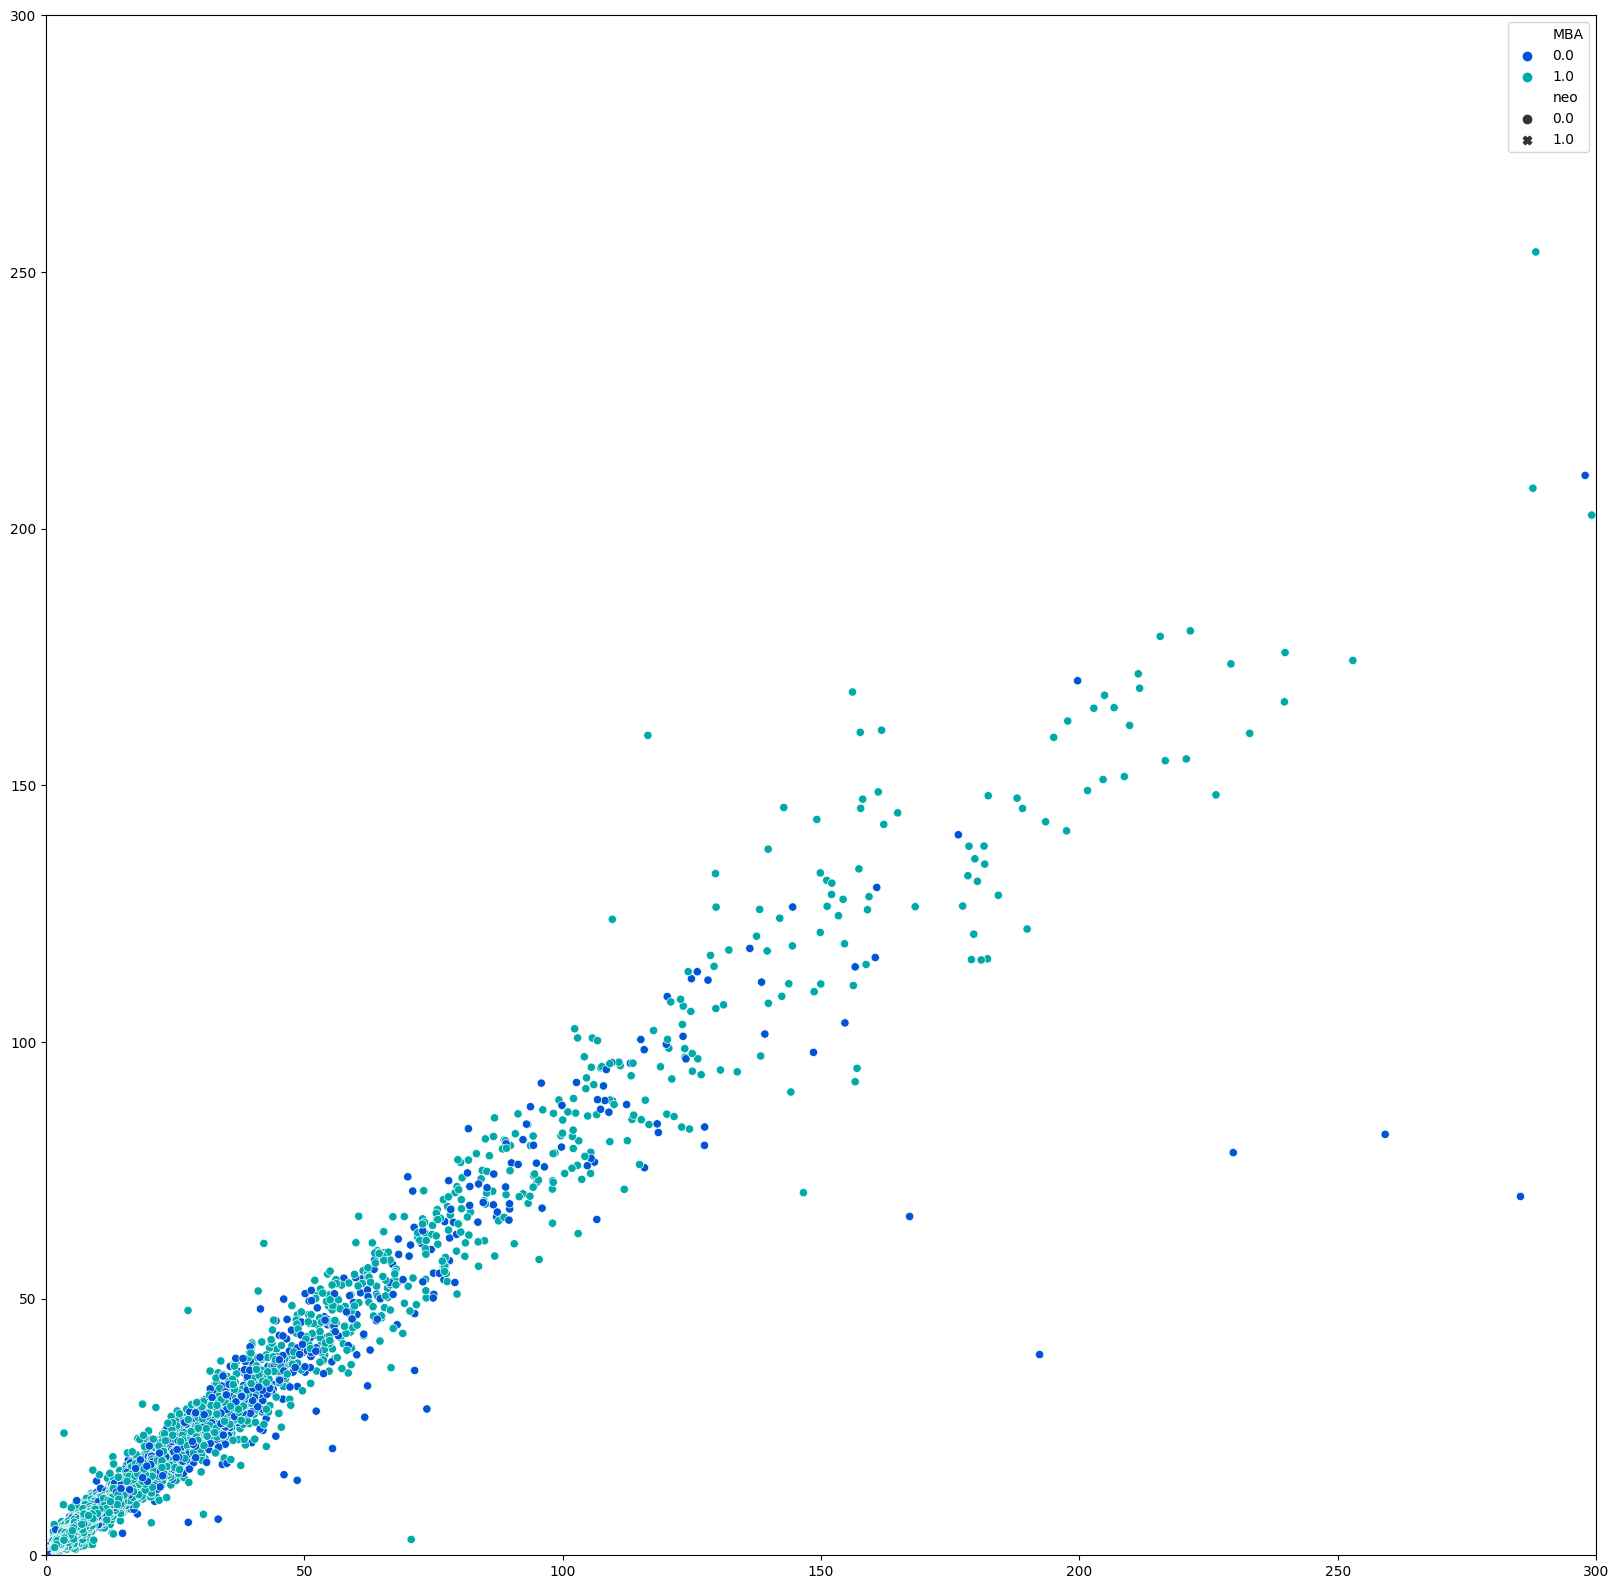

In [124]:
sns.scatterplot(x = np.exp(Predictions.iloc[:,0].values), y = np.exp(y_train_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values), hue = y_train_Cla["MBA"],style = y_train_Cla["neo"], palette = "winter")
plt.xlim([0,300])
plt.legend()
plt.ylim([0,300])

In [240]:
y_train_Cla

,MBA,OMB,Other,neo,pha
8037,1.00,0.00,0.00,0.00,0.00
33766,1.00,0.00,0.00,0.00,0.00
113559,1.00,0.00,0.00,0.00,0.00
111298,1.00,0.00,0.00,0.00,0.00
97754,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
46969,1.00,0.00,0.00,0.00,0.00
123694,1.00,0.00,0.00,0.00,0.00
125115,1.00,0.00,0.00,0.00,0.00
84387,1.00,0.00,0.00,0.00,0.00


In [262]:
# Set up the optimizer, metrics and loss function
learning_rate = 6e-4
Optimizer = keras.optimizers.Nadam(learning_rate, clipnorm = 5.0)
Loss_curve_reg = Laplace_Negative_Likelihood_Loss_Curve
Loss_curve_Cla = tf.keras.losses.binary_crossentropy
jitter = True
metrics = [Mean_Squared_Error]
dropout_rate = 0.2

In [264]:
Ast_Network = Asteroid_Neural_net(Standardized_X_train.shape[0], Standardized_X_train.shape[1], 2, y_train_Cla.shape[1], [100,100,100,100,100,100], Optimizer, Loss_curve_reg, Loss_curve_cla, jitter, metrics)
Ast_Network.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 21)]                 0         []                            
                                                                                                  
 layer_normalization_195 (L  (None, 21)                   42        ['input_14[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 dense_234 (Dense)           (None, 100)                  2200      ['layer_normalization_195[0][0
                                                                    ]']                           
                                                                                           

In [105]:
History = Ast_Network.fit(
    x = Standardized_X_train, y = {"Regression":y_train_Reg[["Log_Diameter", "Log_diameter_sigma"]],"Classification":y_train_Cla},
    validation_data = (Standardized_X_valid, {"Regression":y_valid_Reg[["Log_Diameter", "Log_diameter_sigma"]], "Classification":y_valid_Cla}),
    batch_size = 64, 
    callbacks = [early_stopping, reduce_learn_on_plateau, tf.keras.callbacks.TerminateOnNaN()],
    epochs = 200,
    use_multiprocessing = True,
)

Epoch 1/200
1361/1361 [==============================] - 95s 30ms/step - loss: 194.4060 - Regression_loss: 168.2167 - Classification_loss: 0.1621 - Regression_Mean_Squared_Error: 1.0220 - Classification_Mean_Squared_Error: 0.0375 - val_loss: 150.4773 - val_Regression_loss: 147.2968 - val_Classification_loss: 0.1363 - val_Regression_Mean_Squared_Error: 0.6144 - val_Classification_Mean_Squared_Error: 0.0318 - lr: 6.0000e-04
Epoch 2/200
1361/1361 [==============================] - 13s 9ms/step - loss: 148.6349 - Regression_loss: 147.1095 - Classification_loss: 0.1351 - Regression_Mean_Squared_Error: 0.6139 - Classification_Mean_Squared_Error: 0.0320 - val_loss: 147.9326 - val_Regression_loss: 147.0528 - val_Classification_loss: 0.1333 - val_Regression_Mean_Squared_Error: 0.6142 - val_Classification_Mean_Squared_Error: 0.0317 - lr: 6.0000e-04
Epoch 3/200
1361/1361 [==============================] - 13s 9ms/step - loss: 147.5927 - Regression_loss: 146.9409 - Classification_loss: 0.1333 - Re

<Axes: >

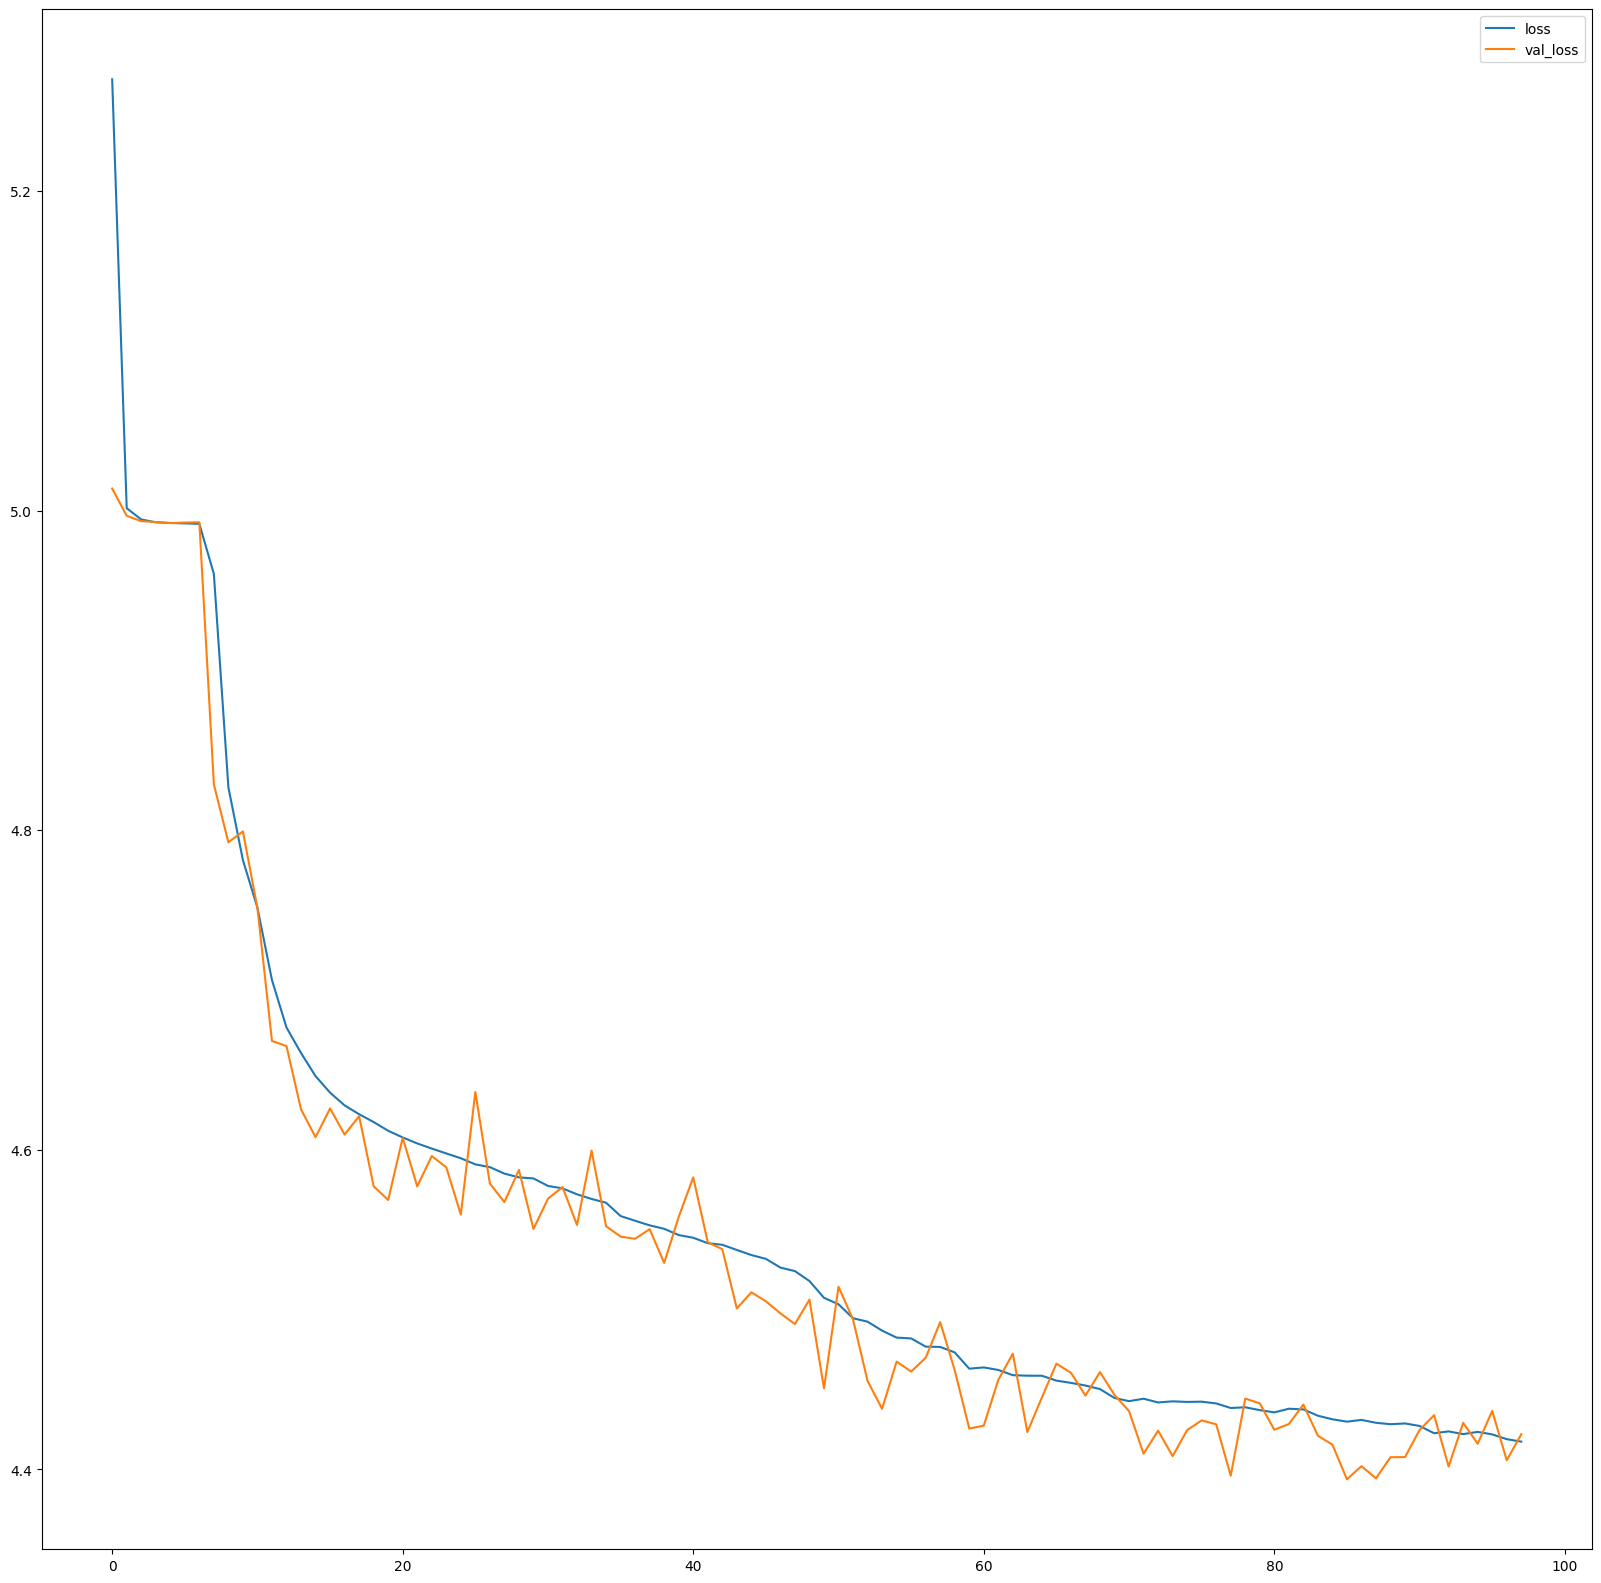

In [106]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(History.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()

In [201]:
Predictions_Reg, Predictions_Cla = Ast_Network.predict(Standardized_X_train)

2722/2722 [==============================] - 8s 3ms/step


In [204]:
Predictions_Reg.shape, Predictions_Cla.shape

((87091, 4), (87091, 5))

In [203]:
Predictions = pd.DataFrame(Predictions_Reg[:,:2], columns = [ "Log_diameter", "Log_diameter_sigma"])

In [206]:
Classifications = pd.DataFrame(Predictions_Cla, columns = ["MBA", "OMB", "Other", "neo", "pha"])
Classifications

,MBA,OMB,Other,neo,pha
0,0.97,0.05,0.00,0.00,0.00
1,0.98,0.01,0.00,0.00,0.00
2,0.95,0.01,0.01,0.00,0.00
3,0.98,0.00,0.01,0.00,0.00
4,0.97,0.05,0.00,0.00,0.00
...,...,...,...,...,...
87086,0.98,0.01,0.00,0.00,0.00
87087,0.92,0.00,0.26,0.07,0.01
87088,0.98,0.01,0.00,0.00,0.00
87089,0.98,0.03,0.00,0.00,0.00


In [205]:
y_train_Cla.head()

,MBA,OMB,Other,neo,pha
8037,1.00,0.00,0.00,0.00,0.00
33766,1.00,0.00,0.00,0.00,0.00
113559,1.00,0.00,0.00,0.00,0.00
111298,1.00,0.00,0.00,0.00,0.00
97754,1.00,0.00,0.00,0.00,0.00


In [129]:
Predictions

,Log_diameter,Log_diameter_sigma
0,2.25,-1.83
1,0.87,-0.99
2,1.41,-1.69
3,0.55,-1.07
4,1.27,-0.31
...,...,...
87086,0.92,-1.11
87087,0.25,-1.37
87088,0.73,-1.00
87089,1.20,-0.39


array([[<Axes: title={'center': 'Log_Diameter'}>,
        <Axes: title={'center': 'Log_diameter_sigma'}>]], dtype=object)

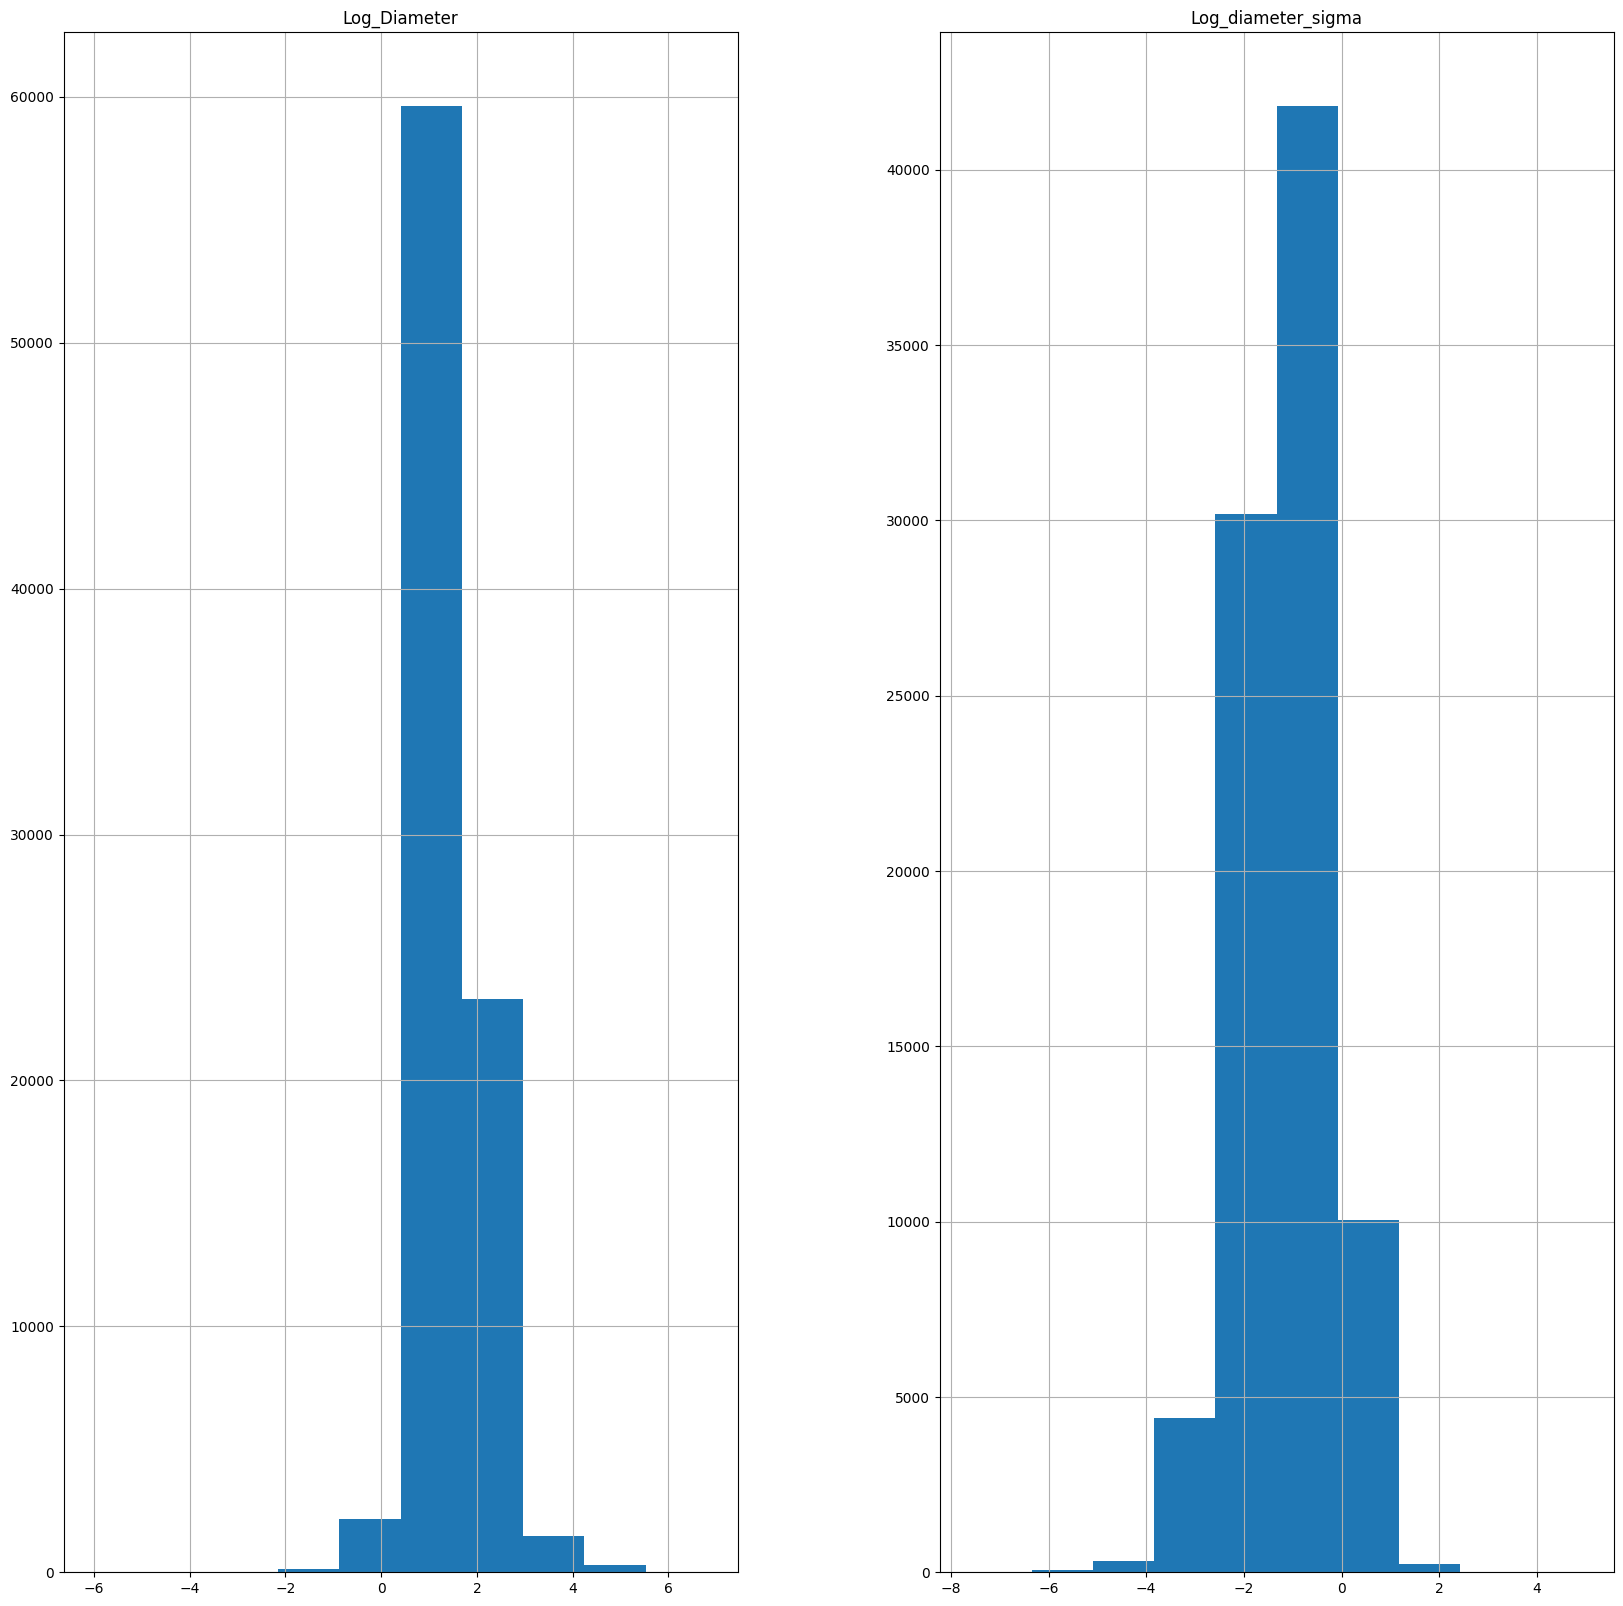

In [110]:
y_train_Reg[[ "Log_Diameter", "Log_diameter_sigma"]].hist()

In [111]:
from sklearn.metrics import mean_squared_error, r2_score
print((mean_squared_error(y_train_Reg["Log_Diameter"], Predictions["Log_diameter"])))
print((r2_score(y_train_Reg["Log_Diameter"], Predictions["Log_diameter"])))

0.023240080371340247
0.9433742608202883


In [112]:
print((mean_squared_error(y_train_Reg["diameter"], np.exp(Predictions["Log_diameter"]))))
print((r2_score(y_train_Reg["diameter"], np.exp(Predictions["Log_diameter"]))))

31.122902707906057
0.6181977726365284


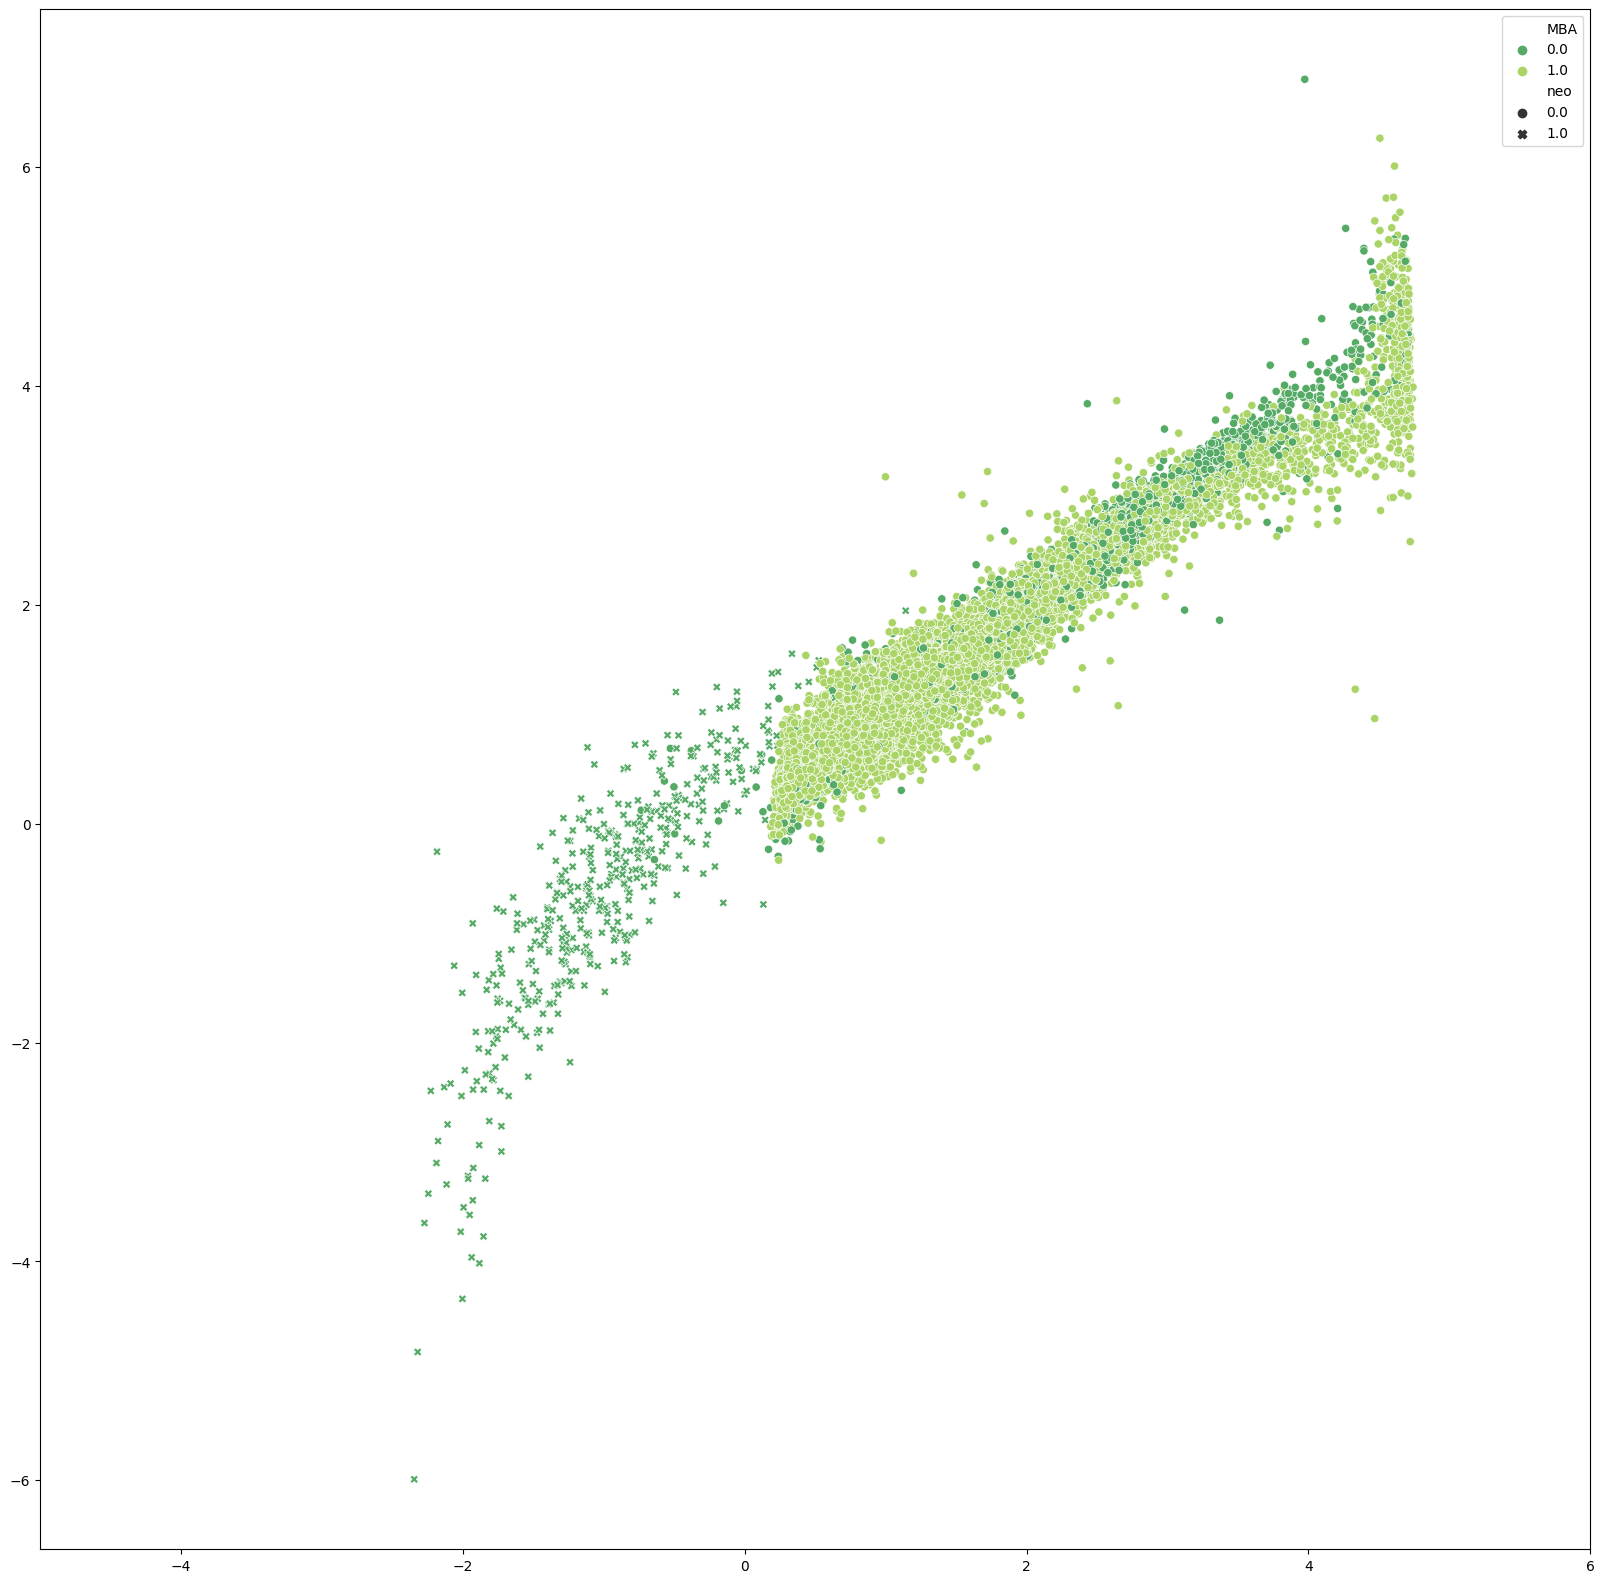

In [113]:
sns.scatterplot(x = Predictions.iloc[:,0].values, y = y_train_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values, hue = y_train_Cla["MBA"],style = y_train_Cla["neo"], palette = "summer")
plt.xlim([-5,6.0])
plt.legend()

(0.0, 125.0)

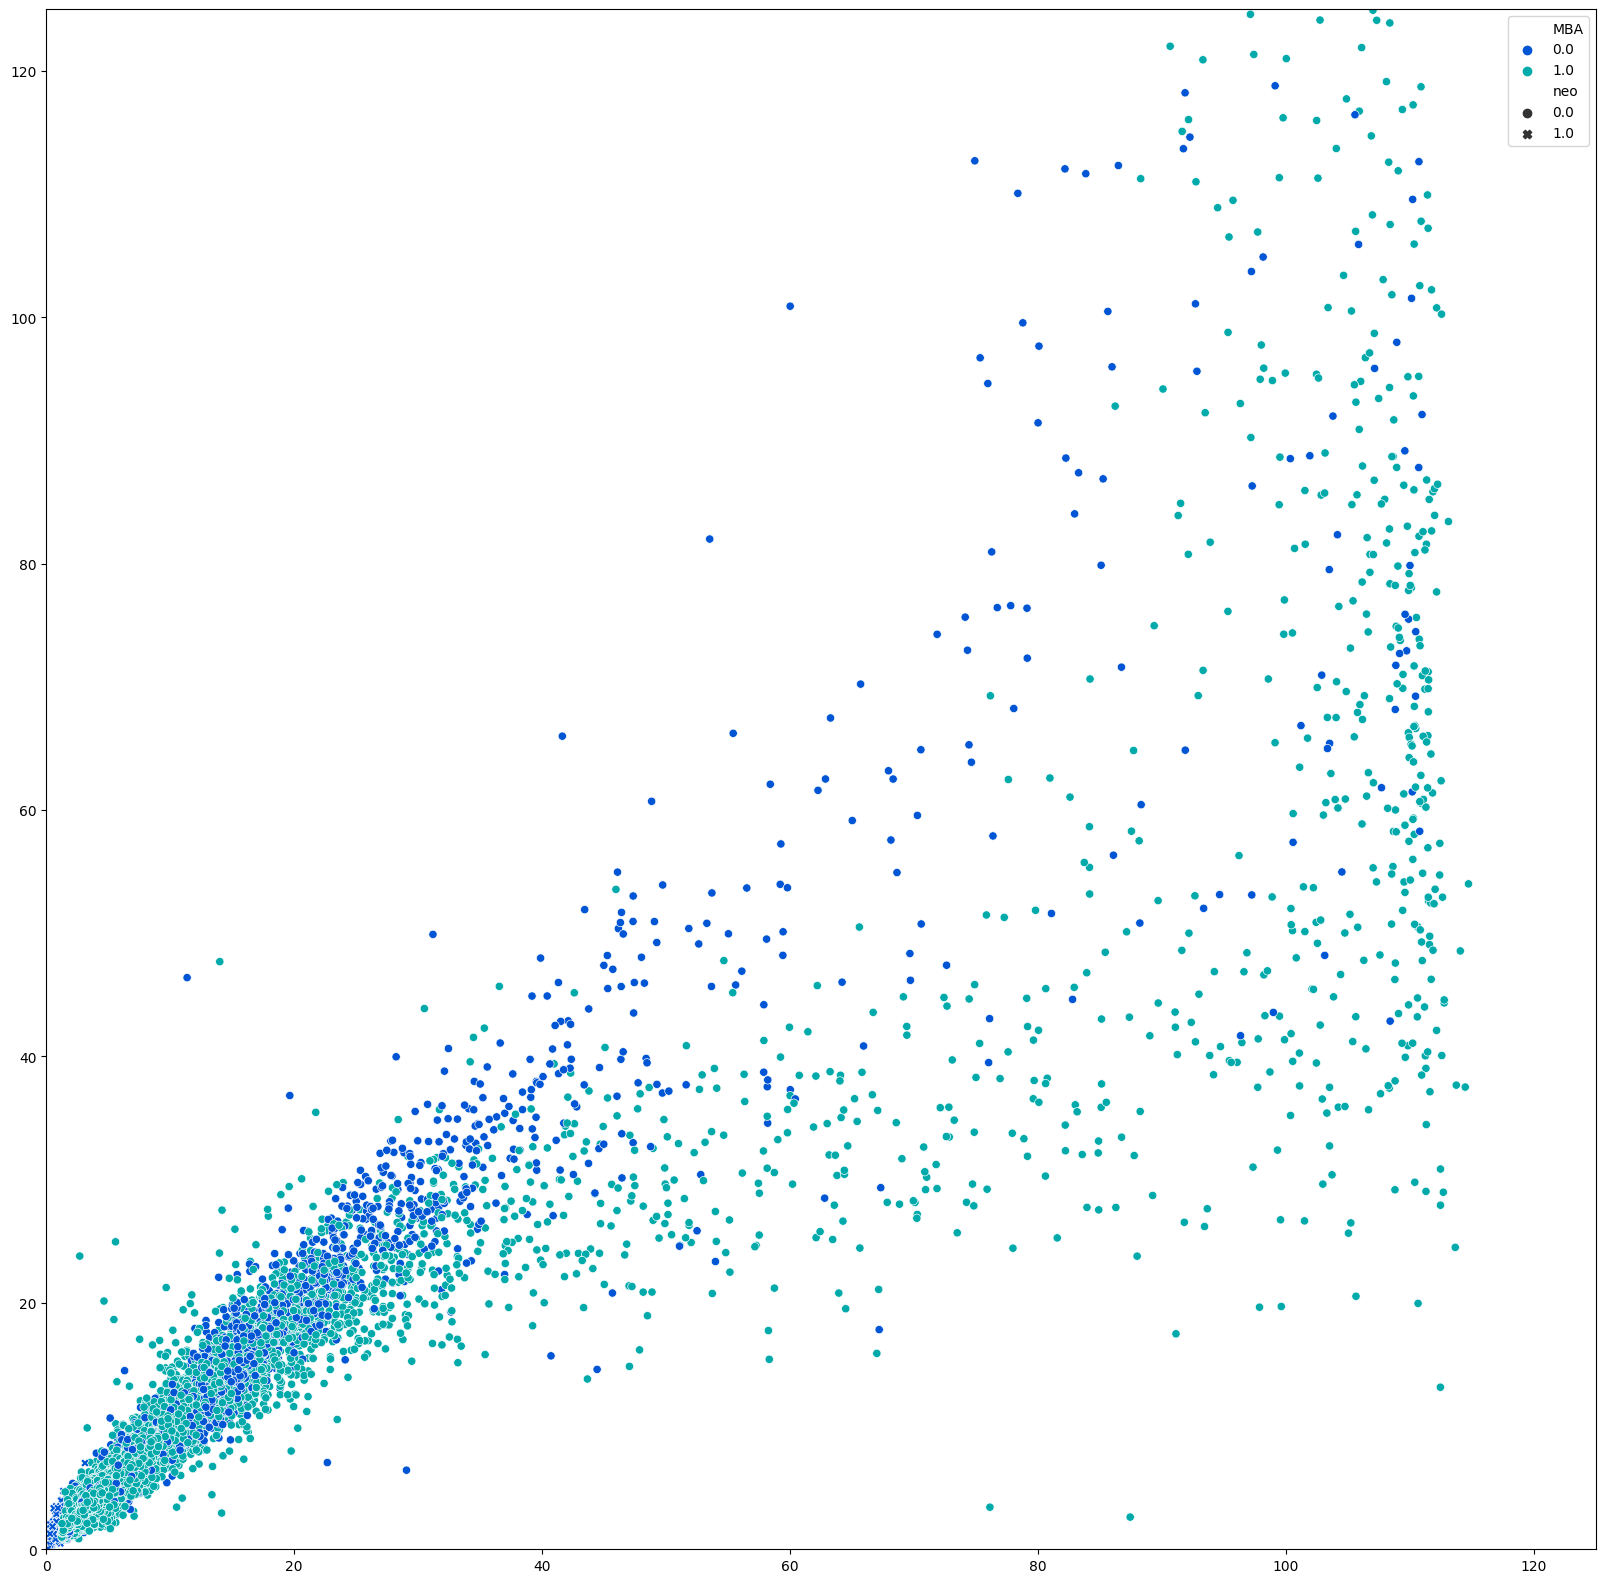

In [116]:
sns.scatterplot(x = np.exp(Predictions.iloc[:,0].values), y = np.exp(y_train_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values), hue = y_train_Cla["MBA"],style = y_train_Cla["neo"], palette = "winter")
plt.xlim([0,125])
plt.legend()
plt.ylim([0,125])

In [213]:
np.round(Classifications)

,MBA,OMB,Other,neo,pha
0,1.00,0.00,0.00,0.00,0.00
1,1.00,0.00,0.00,0.00,0.00
2,1.00,0.00,0.00,0.00,0.00
3,1.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
87086,1.00,0.00,0.00,0.00,0.00
87087,1.00,0.00,0.00,0.00,0.00
87088,1.00,0.00,0.00,0.00,0.00
87089,1.00,0.00,0.00,0.00,0.00


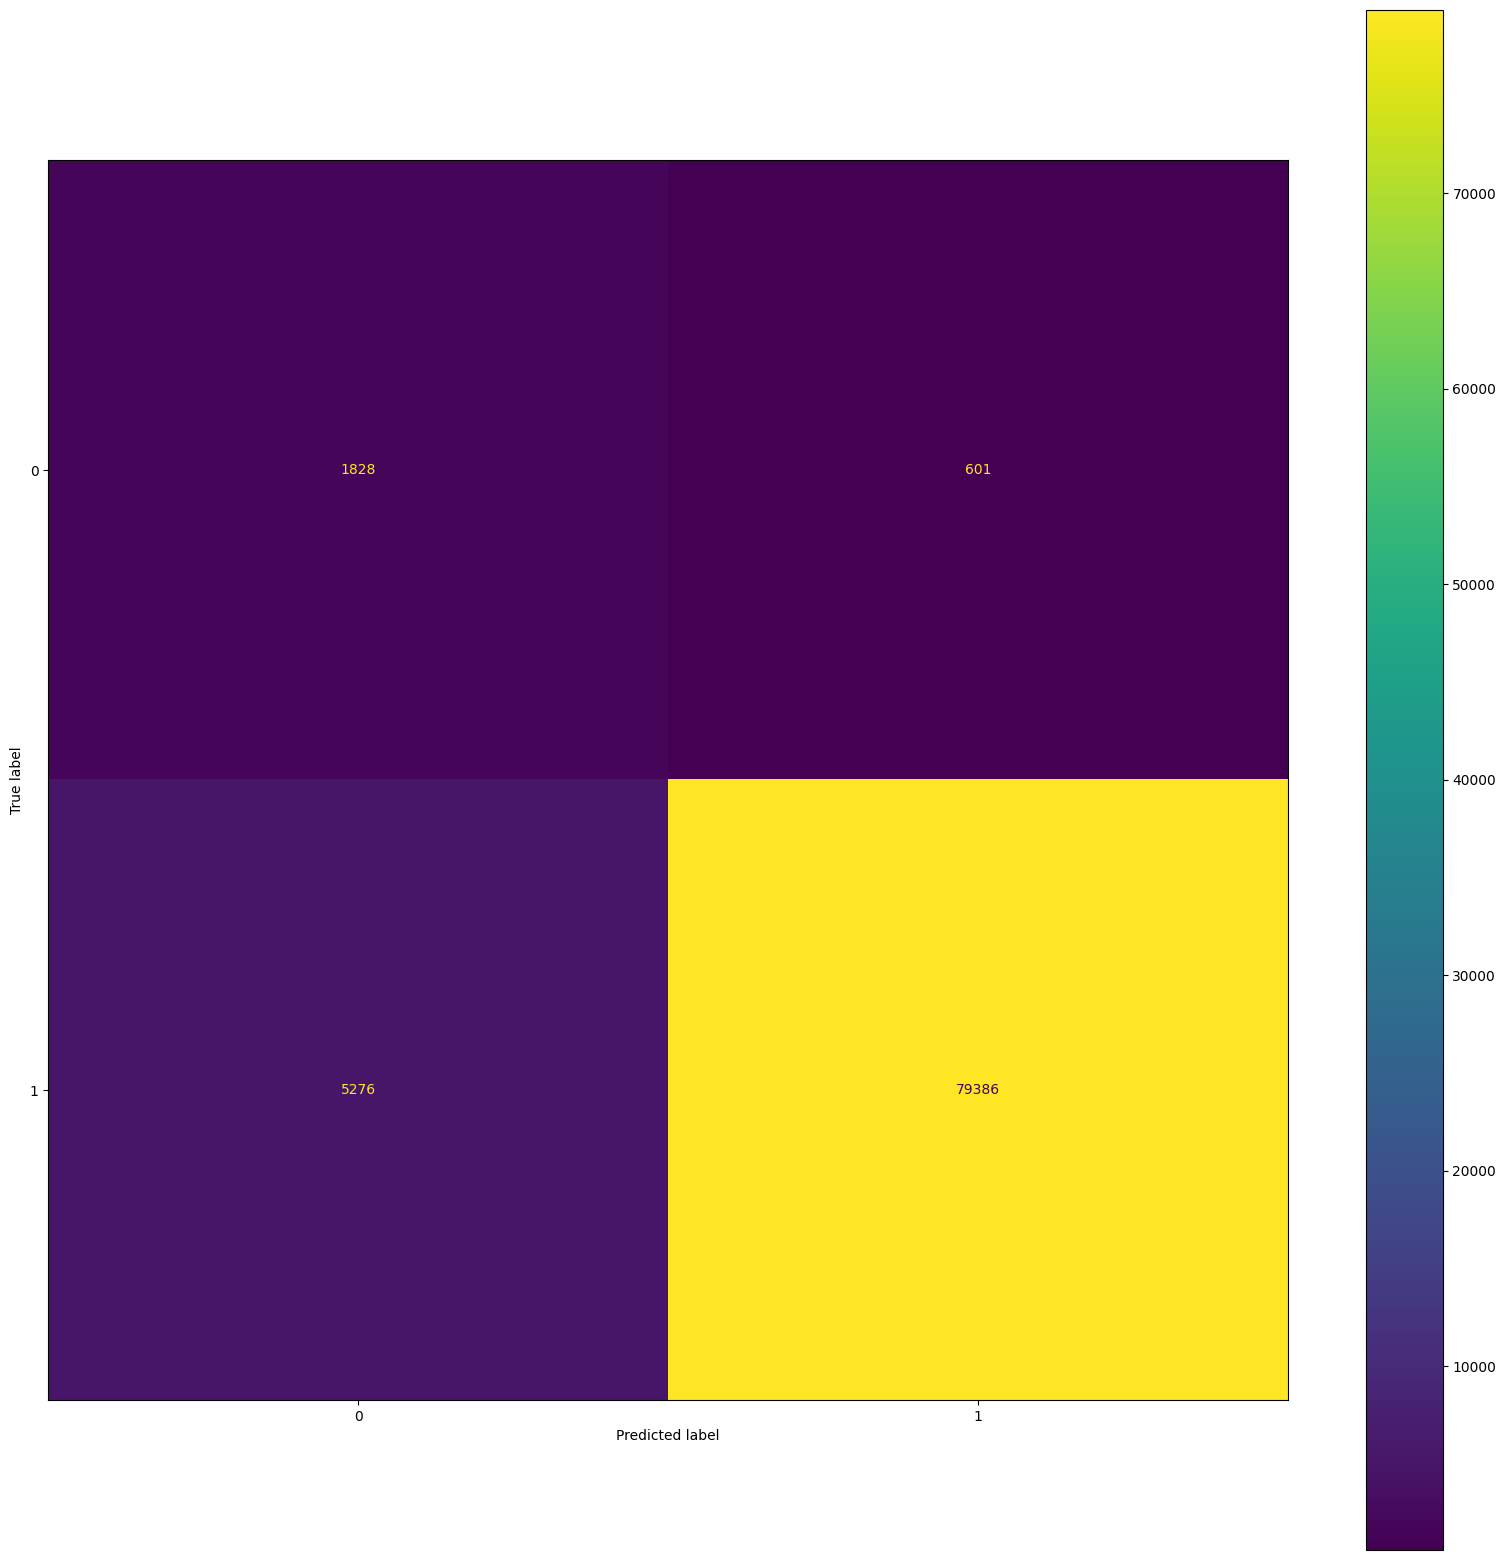

In [216]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,0]), y_train_Cla.iloc[:,0])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

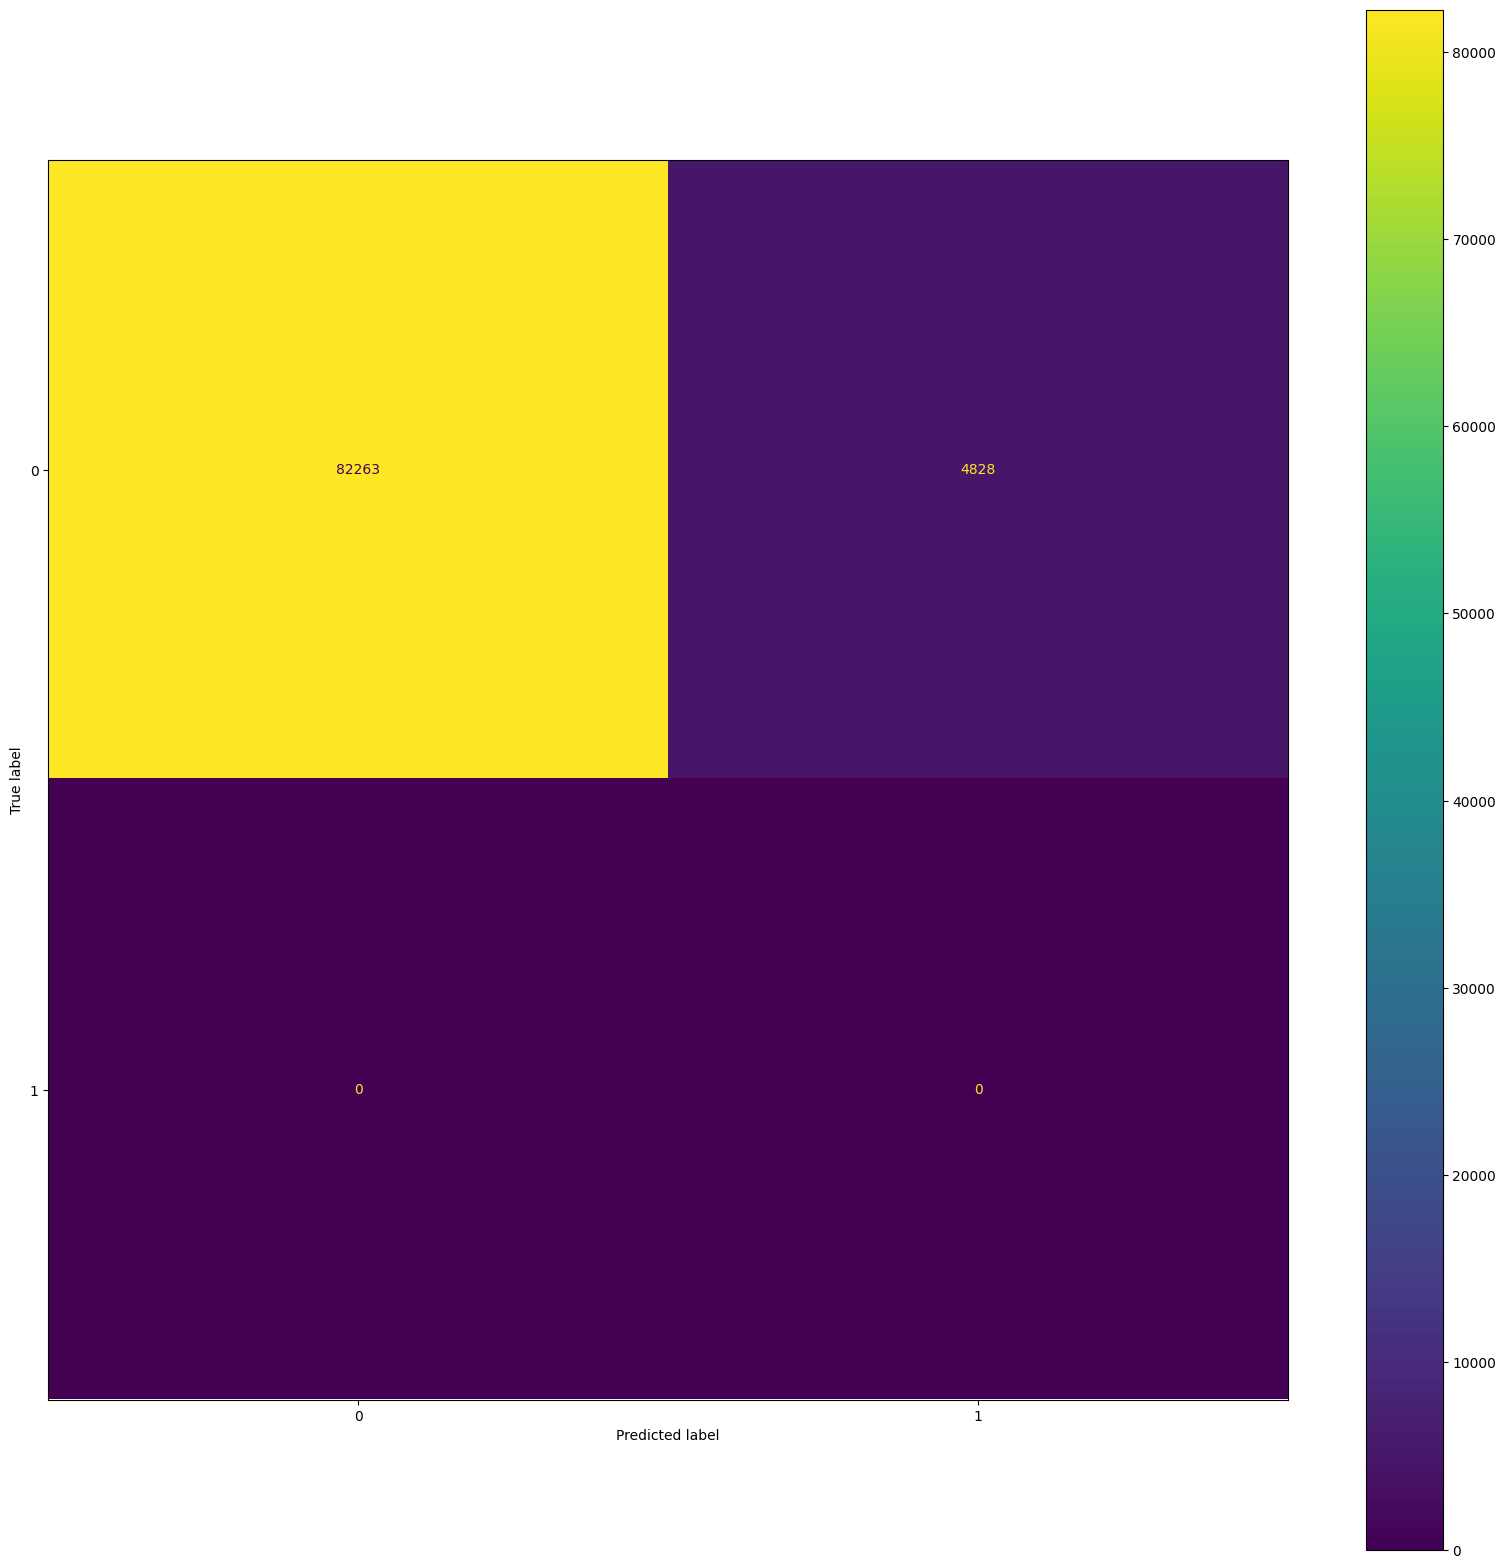

In [217]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,1]), y_train_Cla.iloc[:,1])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

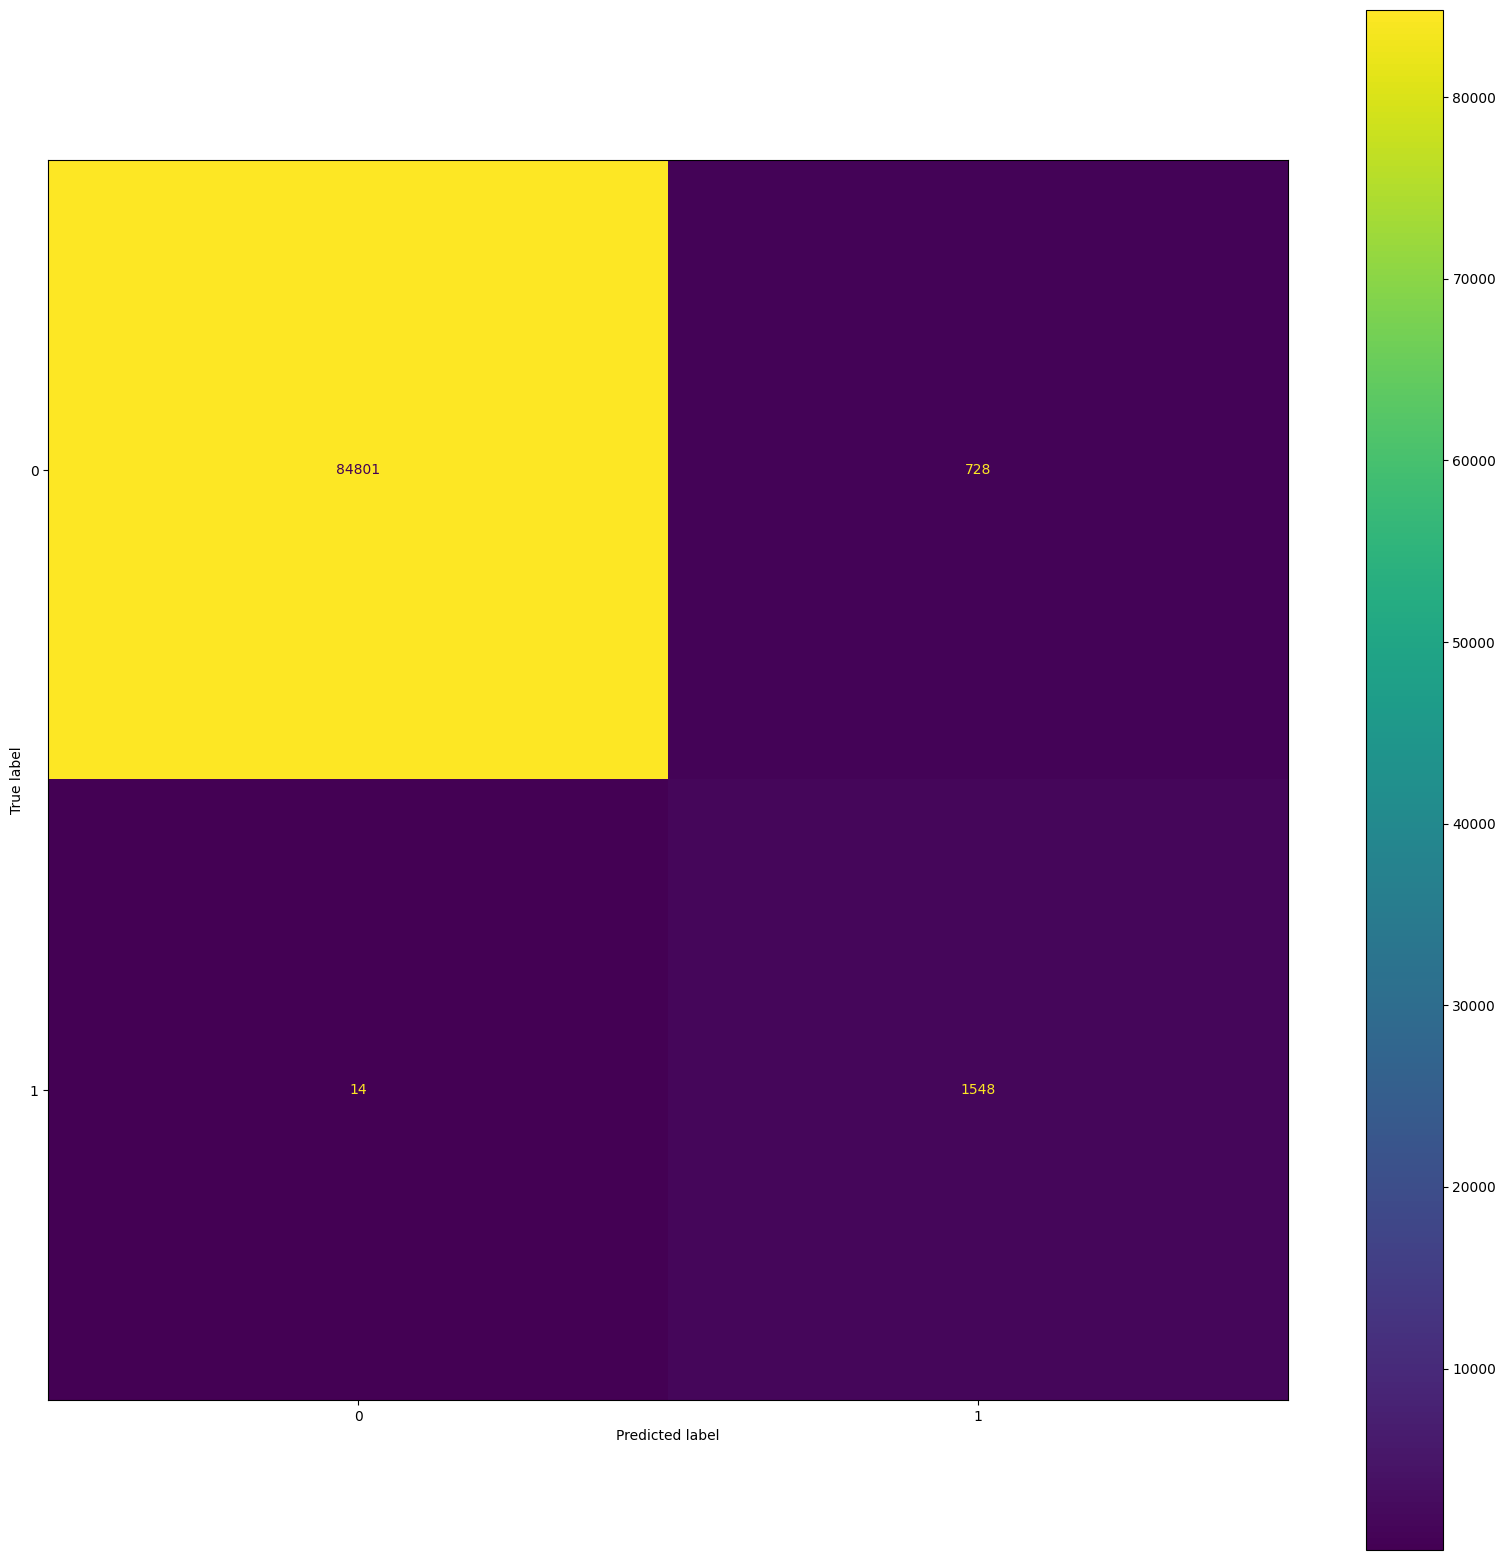

In [218]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,2]), y_train_Cla.iloc[:,2])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

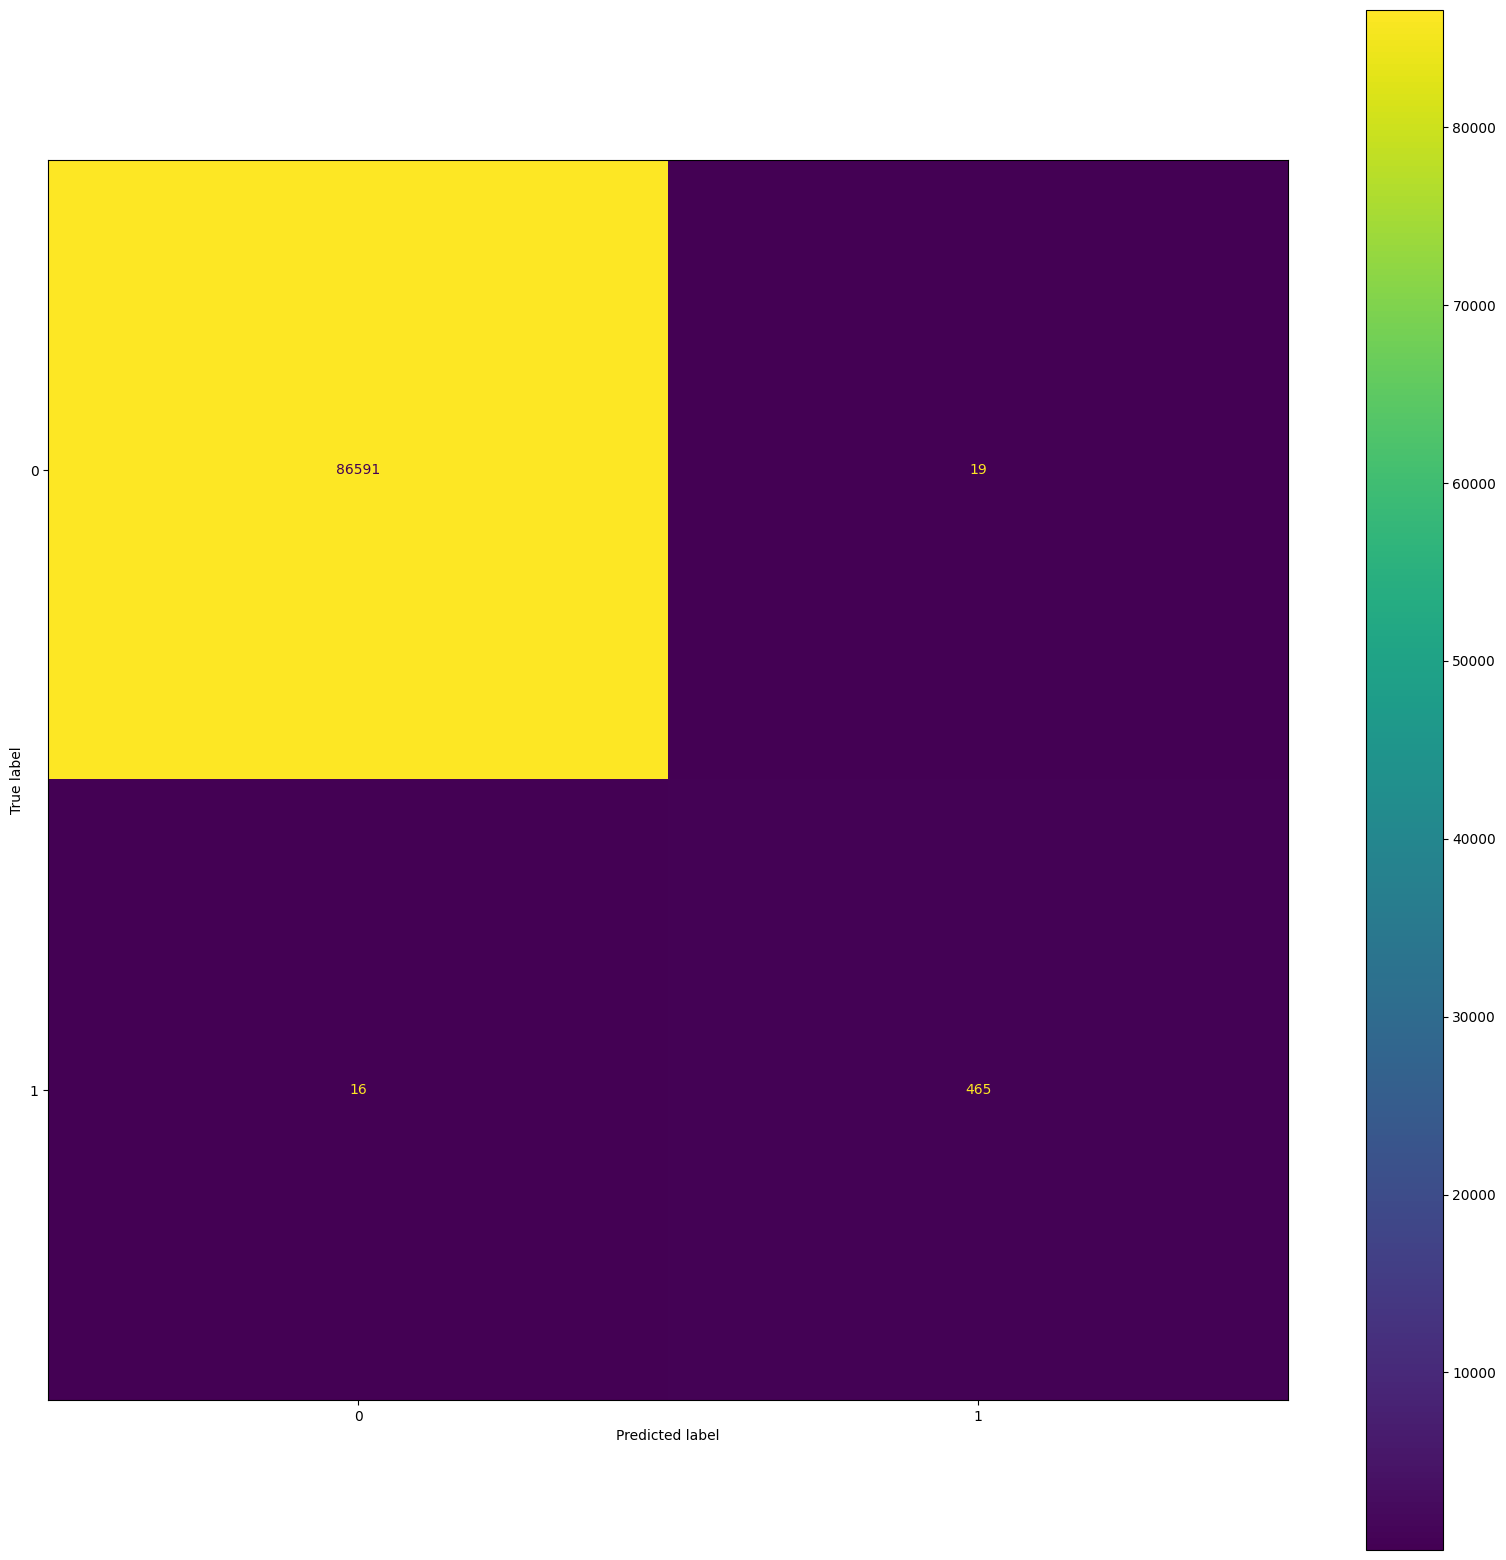

In [219]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:, 3]), y_train_Cla.iloc[:,3])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

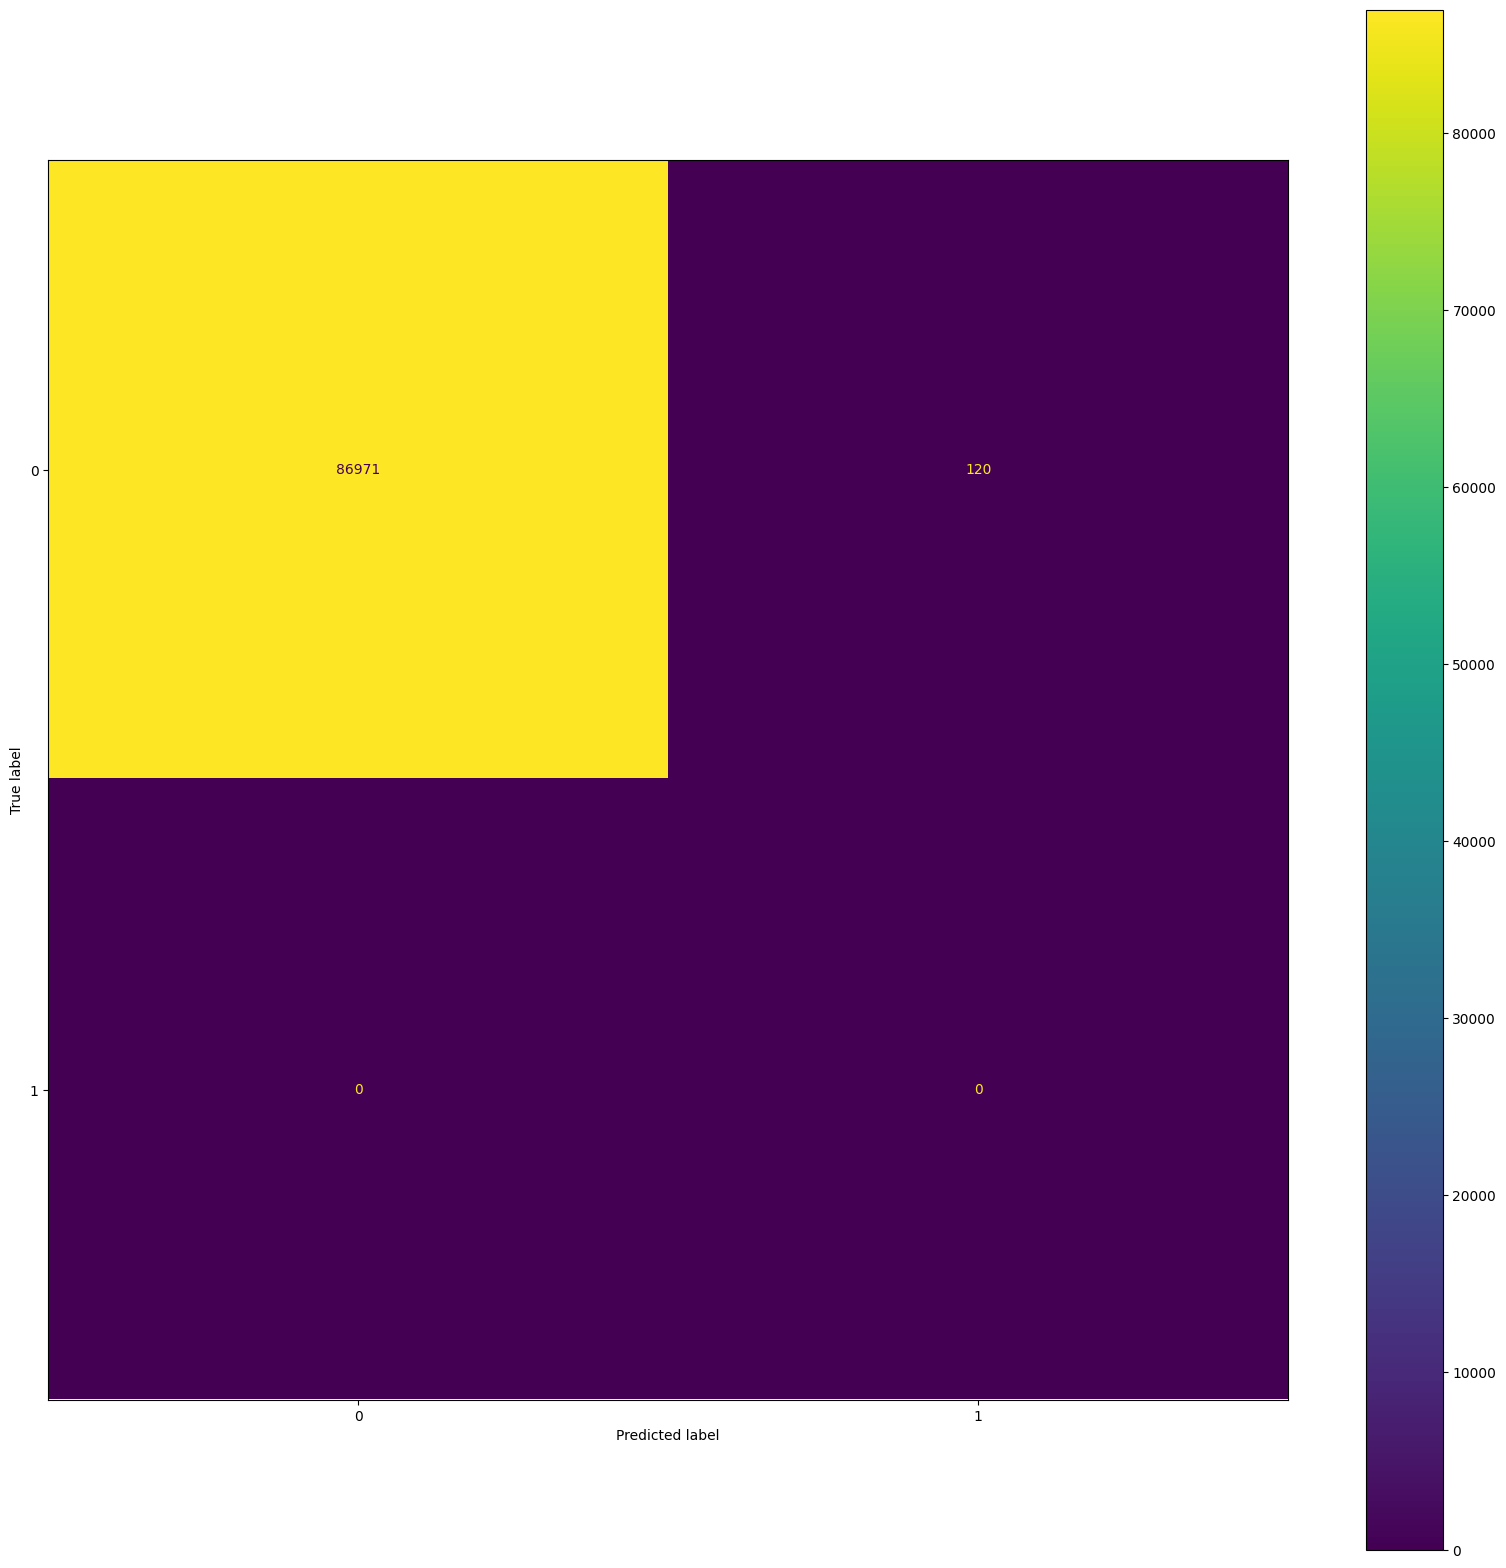

In [220]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:, 4]), y_train_Cla.iloc[:,4])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [165]:
Error_Log_diameter = y_train_Reg["Log_Diameter"].values - Predictions["Log_diameter"].values
Pull_Log_diameter = Error_Log_diameter/0.5*np.exp(Predictions_Reg[:,2])
np.mean(Pull_Log_diameter), np.std(Pull_Log_diameter)

(0.06486216859746129, 0.29880648758475503)

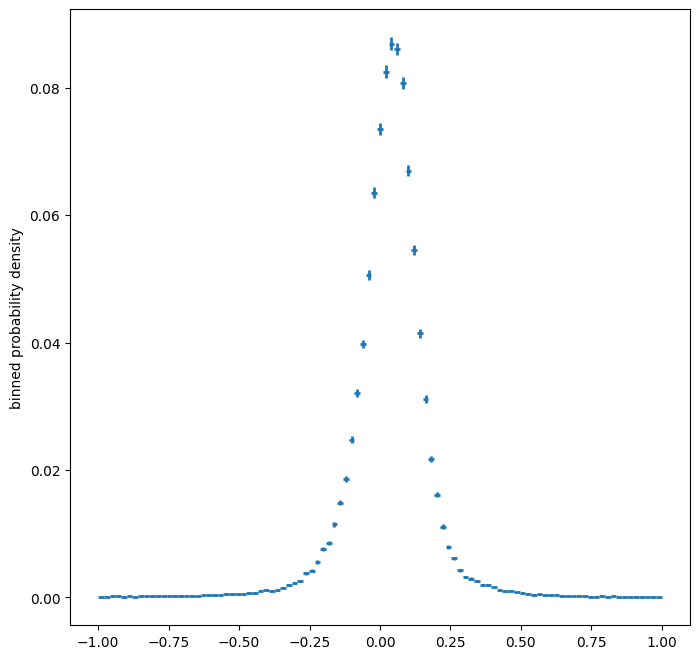

In [166]:
binneddensity(Error_Log_diameter, fixedbinning(-1,1, 100))

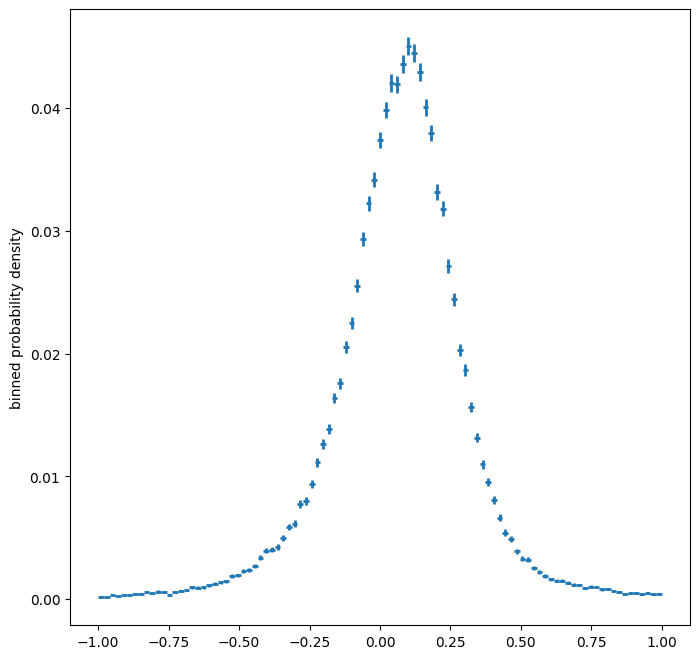

In [167]:
binneddensity(Pull_diameter, fixedbinning(-1,1, 100))

In [173]:
Error_diameter = y_train_Reg["diameter"].values - np.exp(Predictions["Log_diameter"].values)
Pull_diameter = Error_diameter/np.exp(0.5*np.exp(Predictions_Reg[:,2]))
np.mean(Pull_diameter), np.std(Pull_diameter)

(-0.059727297597249755, 3.3052422603143334)

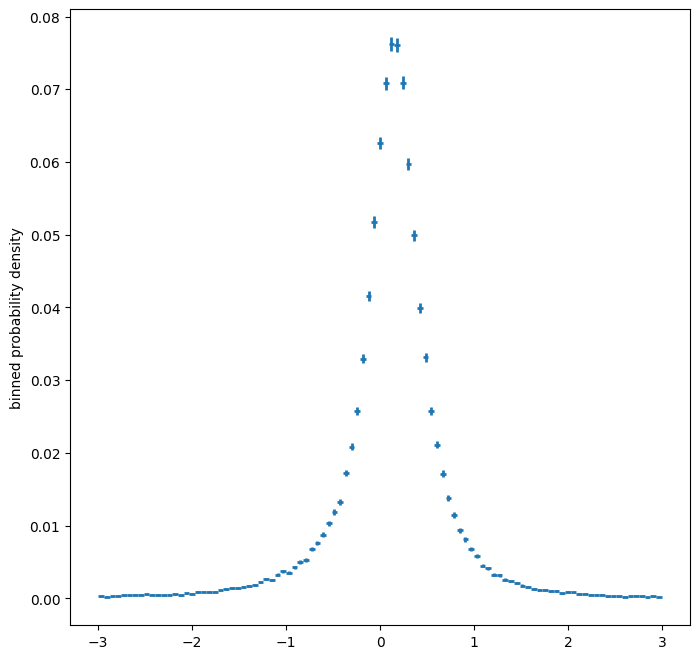

In [175]:
binneddensity(Error_diameter, fixedbinning(-3,3, 100))

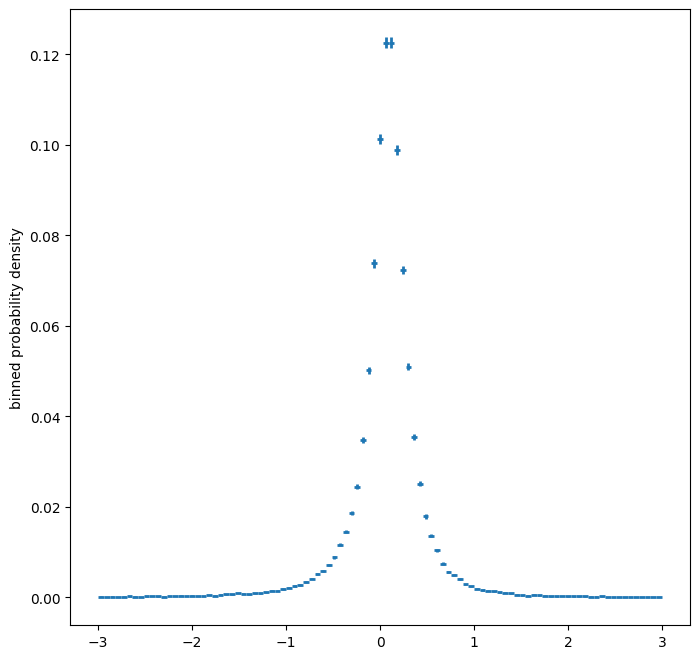

In [178]:
binneddensity(Pull_diameter, fixedbinning(-3,3, 100))

Text(0, 0.5, 'The predicted diameters of asteroids')

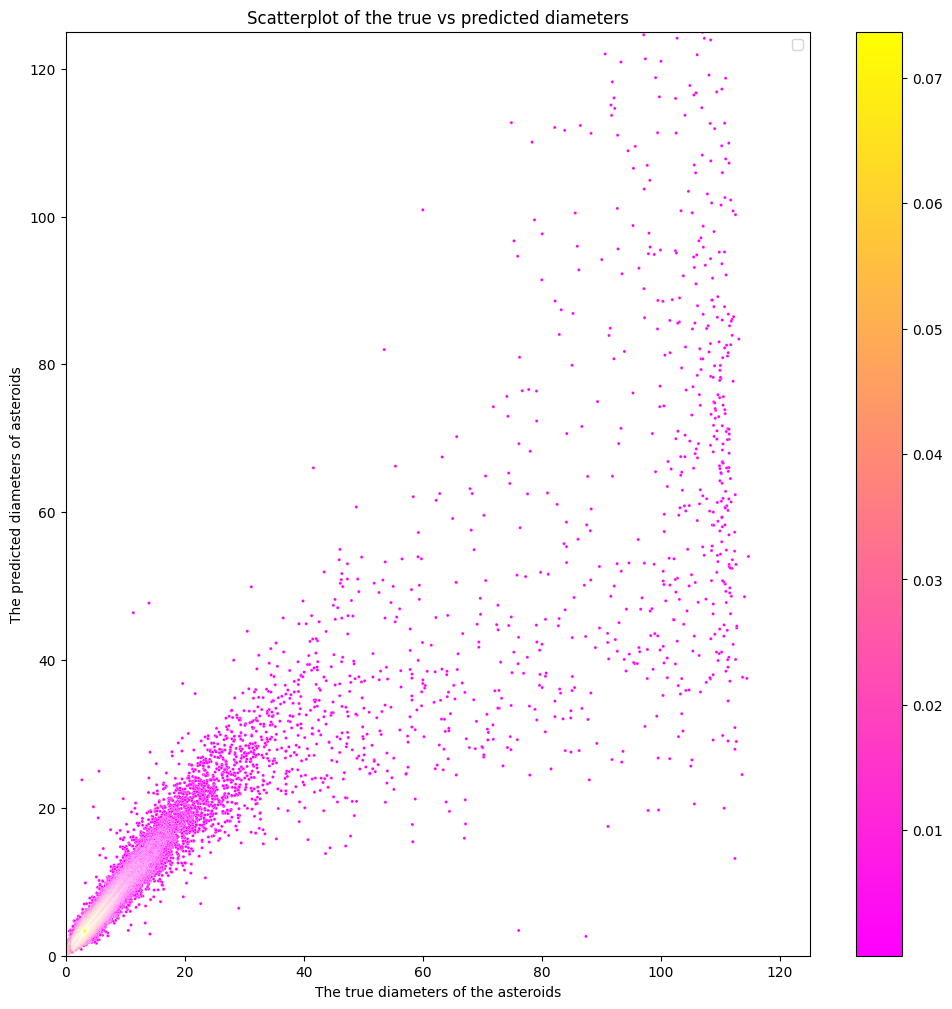

In [183]:
fig, ax = plt.subplots(figsize = (12,12))
x = np.exp(Predictions["Log_diameter"].values)
y = y_train_Reg["diameter"].values
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
plt.xlim([0,125])
plt.legend()
plt.ylim([0,125])
ax.set_title("Scatterplot of the true vs predicted diameters")
ax.set_xlabel("The true diameters of the asteroids")
ax.set_ylabel("The predicted diameters of asteroids")

In [221]:
Predictions_Reg, Predictions_Cla = Ast_Network.predict(Standardized_X_valid)

681/681 [==============================] - 2s 3ms/step


In [185]:
Predictions = pd.DataFrame(Predictions_Reg[:,:2], columns = ["Log_diameter", "Log_diameter_sigma"])

In [ ]:
Classifications = pd.DataFrame(Predictions_Cla, columns = ["MBA", "OMB", "Other", "neo", "pha"])
Classifications

In [186]:
from sklearn.metrics import mean_squared_error, r2_score
print((mean_squared_error(y_valid_Reg["Log_Diameter"], Predictions["Log_diameter"])))
print((r2_score(y_valid_Reg["Log_Diameter"], Predictions["Log_diameter"])))

0.023777748363021035
0.9403390172447412


In [187]:
print((mean_squared_error(y_valid_Reg["diameter"], np.exp(Predictions["Log_diameter"]))))
print((r2_score(y_valid_Reg["diameter"], np.exp(Predictions["Log_diameter"]))))

31.284774152790312
0.5799096534531267


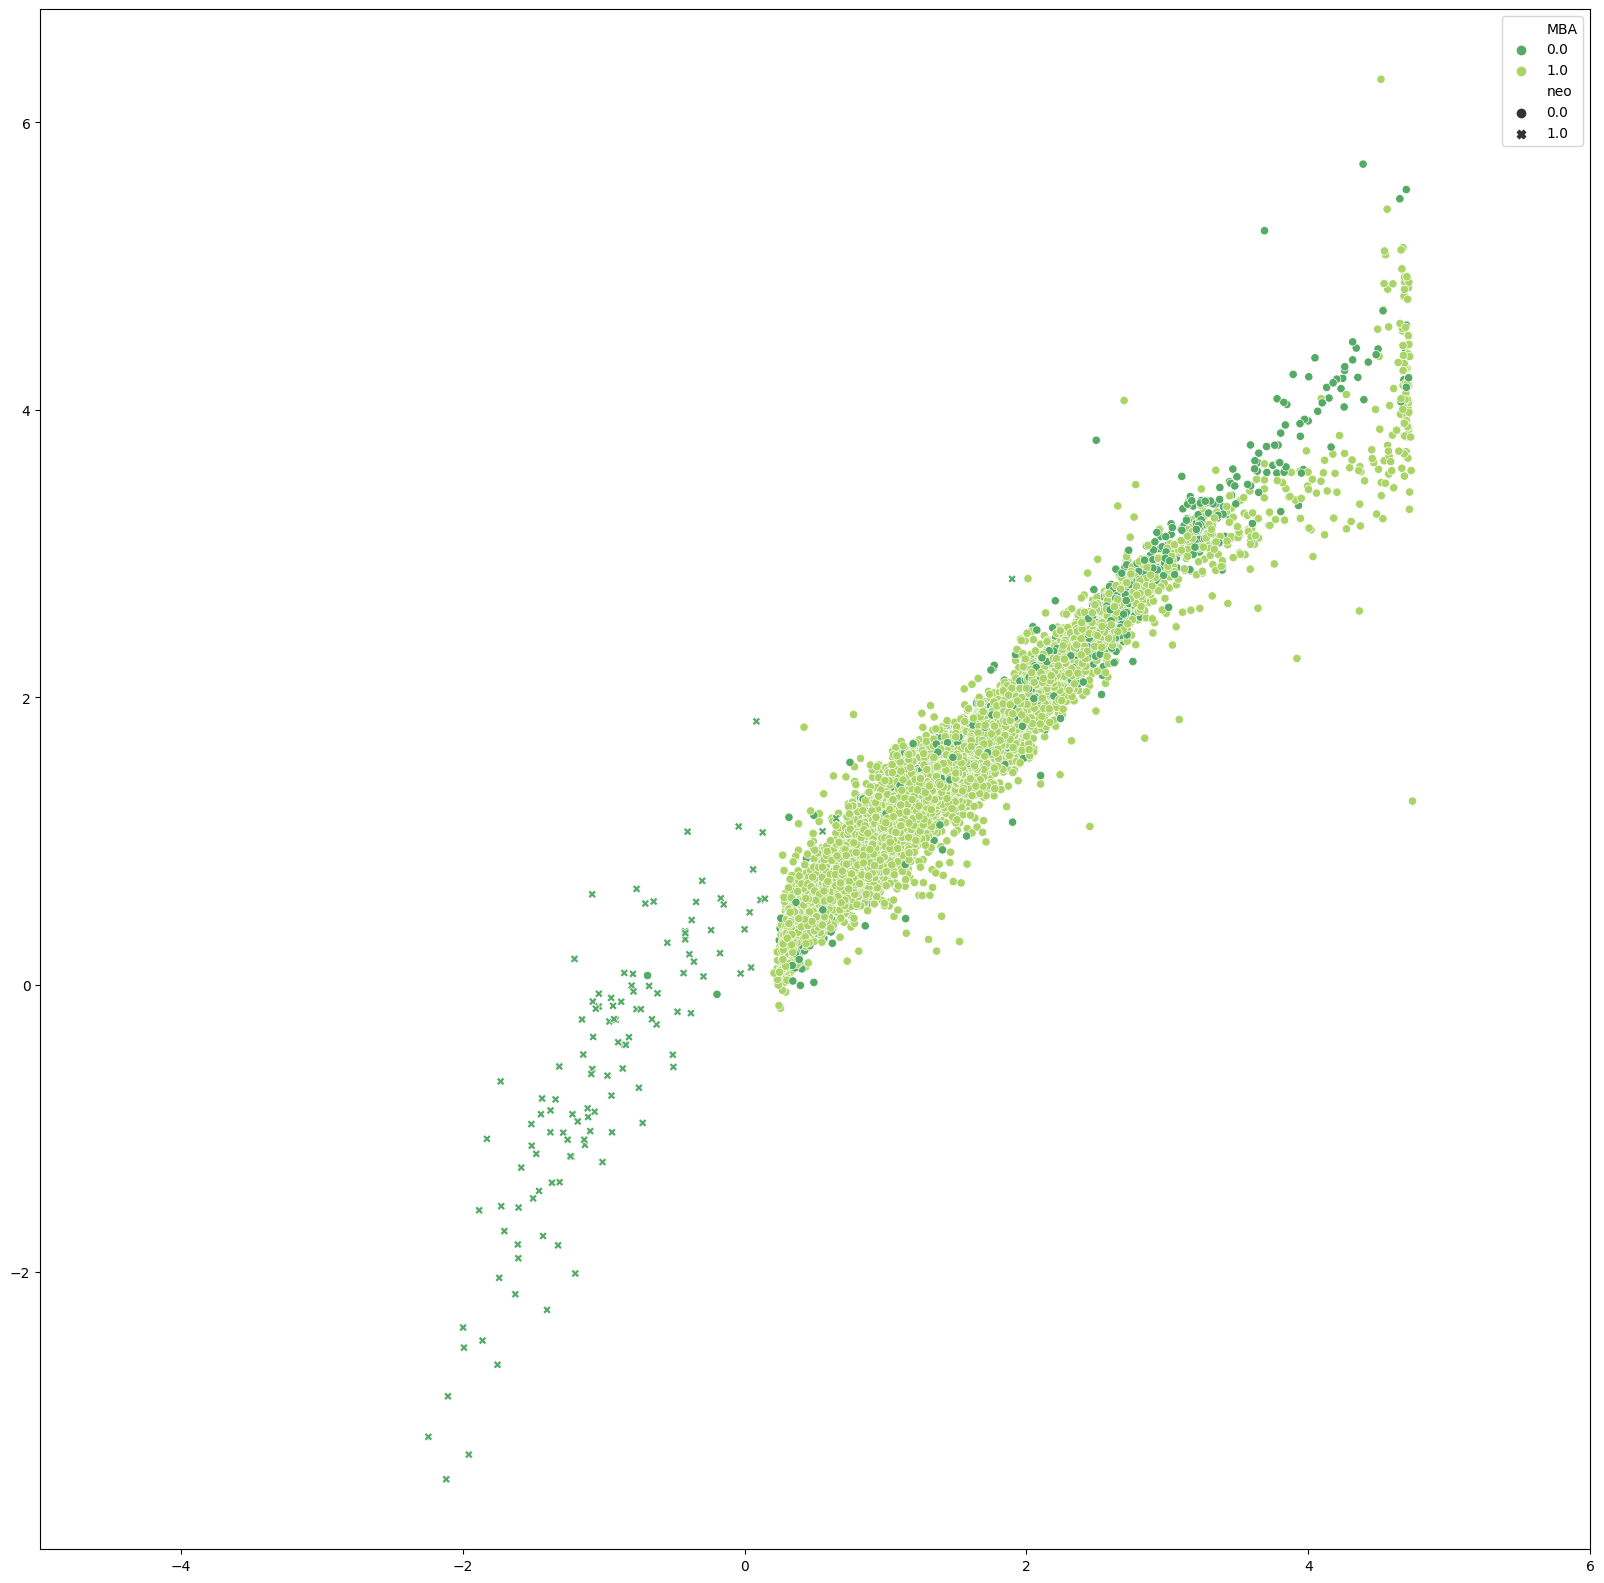

In [121]:
sns.scatterplot(x = Predictions.iloc[:,0].values, y = y_valid_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values, hue = y_valid_Cla["MBA"],style = y_valid_Cla["neo"], palette = "summer")
plt.xlim([-5,6.0])
plt.legend()

(0.0, 125.0)

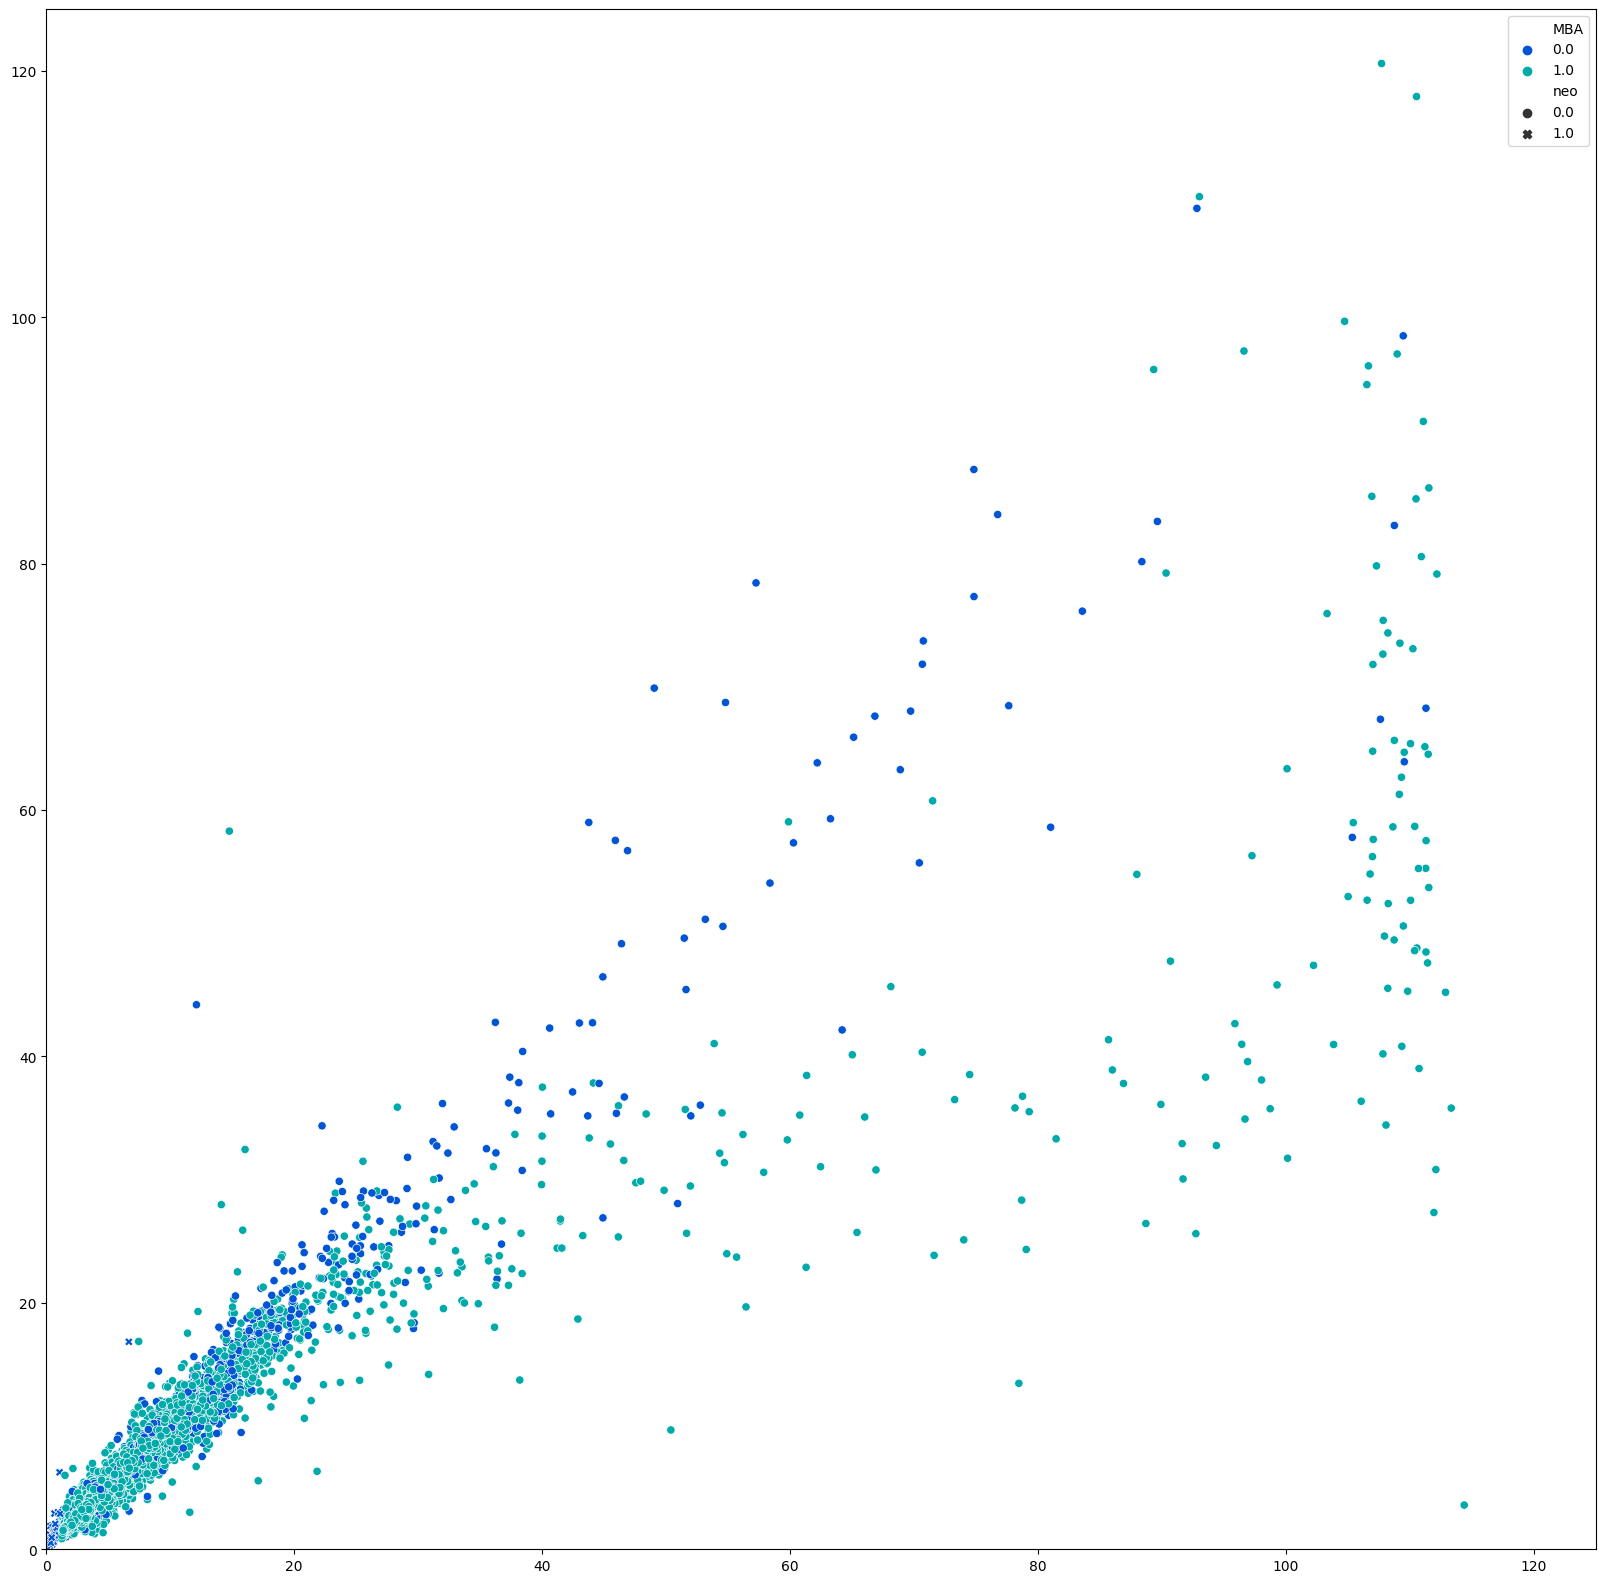

In [126]:
sns.scatterplot(x = np.exp(Predictions.iloc[:,0].values), y = np.exp(y_valid_Reg[["Log_Diameter", "Log_diameter_sigma"]].iloc[:,0].values), hue = y_valid_Cla["MBA"],style = y_valid_Cla["neo"], palette = "winter")
plt.xlim([0,125])
plt.legend()
plt.ylim([0,125])

In [188]:
Error_Log_diameter = y_valid_Reg["Log_Diameter"].values - Predictions["Log_diameter"].values
Pull_Log_diameter = Error_Log_diameter/0.5*np.exp(Predictions_Reg[:,2])
np.mean(Pull_Log_diameter), np.std(Pull_Log_diameter)

(0.052656562467836635, 0.3044073243370677)

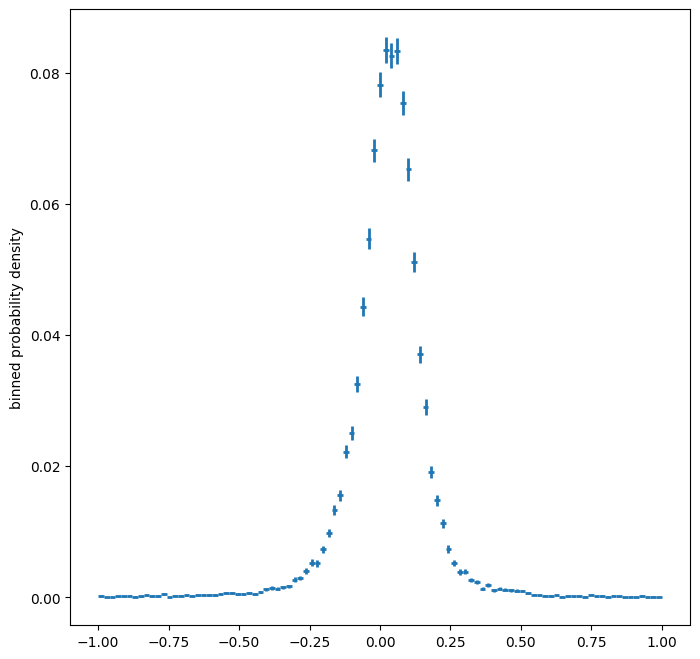

In [189]:
binneddensity(Error_Log_diameter, fixedbinning(-1,1, 100))

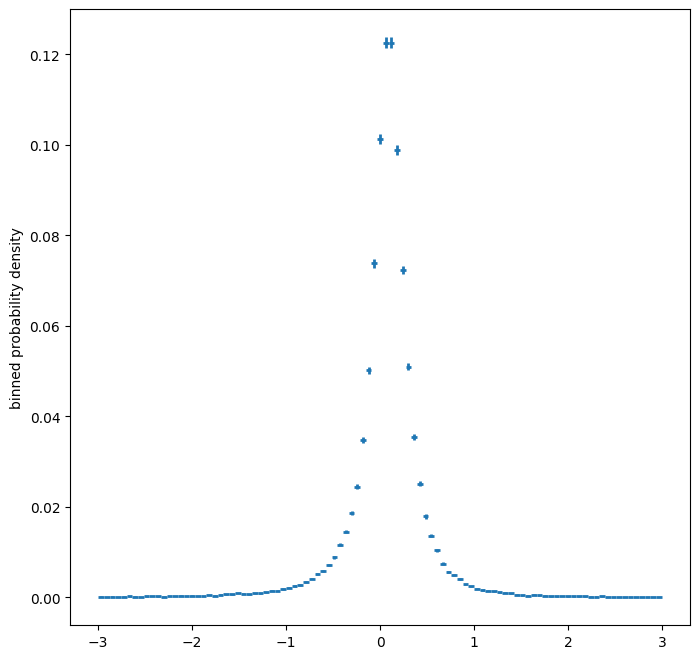

In [190]:
binneddensity(Pull_diameter, fixedbinning(-3,3, 100))

In [193]:
Error_diameter = y_valid_Reg["diameter"].values - np.exp(Predictions["Log_diameter"].values)
Pull_diameter = Error_diameter/np.exp(0.5*np.exp(Predictions_Reg[:,2]))
np.mean(Pull_diameter), np.std(Pull_diameter)

(-0.08107615768340934, 3.323054466491288)

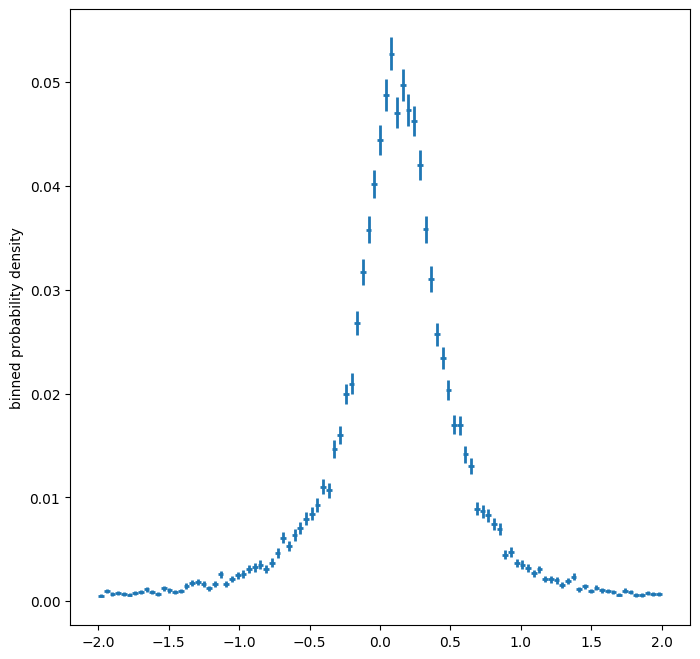

In [196]:
binneddensity(Error_diameter, fixedbinning(-2,2, 100))

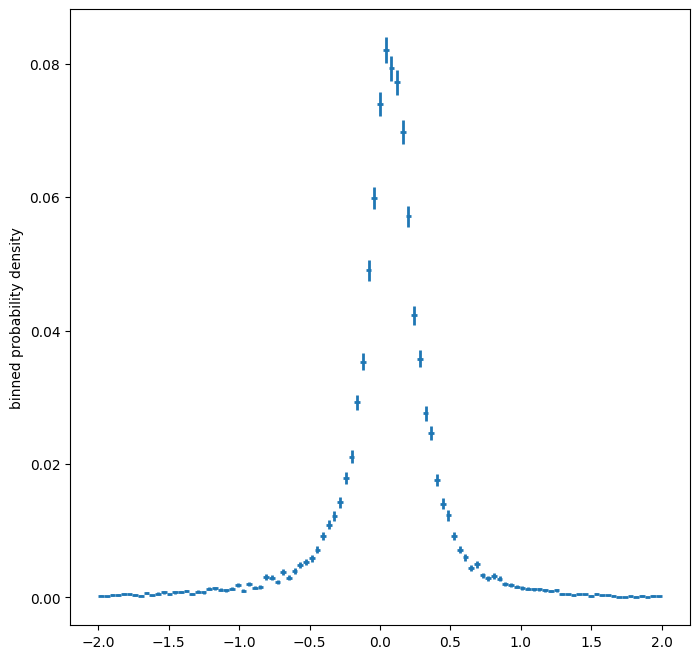

In [197]:
binneddensity(Pull_diameter, fixedbinning(-2,2, 100))

Text(0, 0.5, 'The predicted diameters of asteroids')

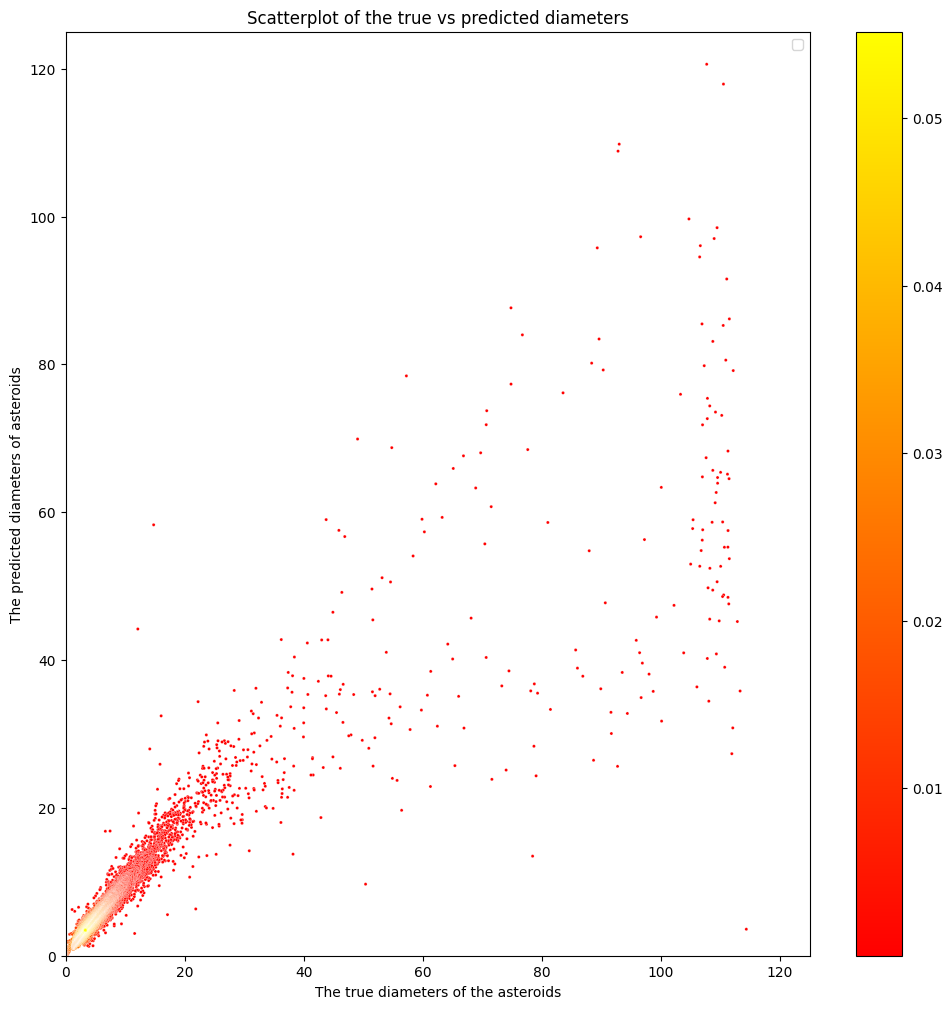

In [200]:
fig, ax = plt.subplots(figsize = (12,12))
x = np.exp(Predictions["Log_diameter"].values)
y = y_valid_Reg["diameter"].values
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
plt.xlim([0,125])
plt.legend()
plt.ylim([0,125])
ax.set_title("Scatterplot of the true vs predicted diameters")
ax.set_xlabel("The true diameters of the asteroids")
ax.set_ylabel("The predicted diameters of asteroids")

In [222]:
Classifications = pd.DataFrame(Predictions_Cla, columns = ["MBA", "OMB", "Other", "neo", "pha"])
Classifications

,MBA,OMB,Other,neo,pha
0,0.95,0.02,0.01,0.00,0.00
1,0.98,0.03,0.00,0.00,0.00
2,0.98,0.01,0.00,0.00,0.00
3,0.76,0.14,0.03,0.00,0.00
4,0.92,0.04,0.01,0.00,0.00
...,...,...,...,...,...
21768,0.98,0.03,0.00,0.00,0.00
21769,0.98,0.03,0.00,0.00,0.00
21770,0.93,0.00,0.17,0.04,0.00
21771,0.95,0.04,0.00,0.00,0.00


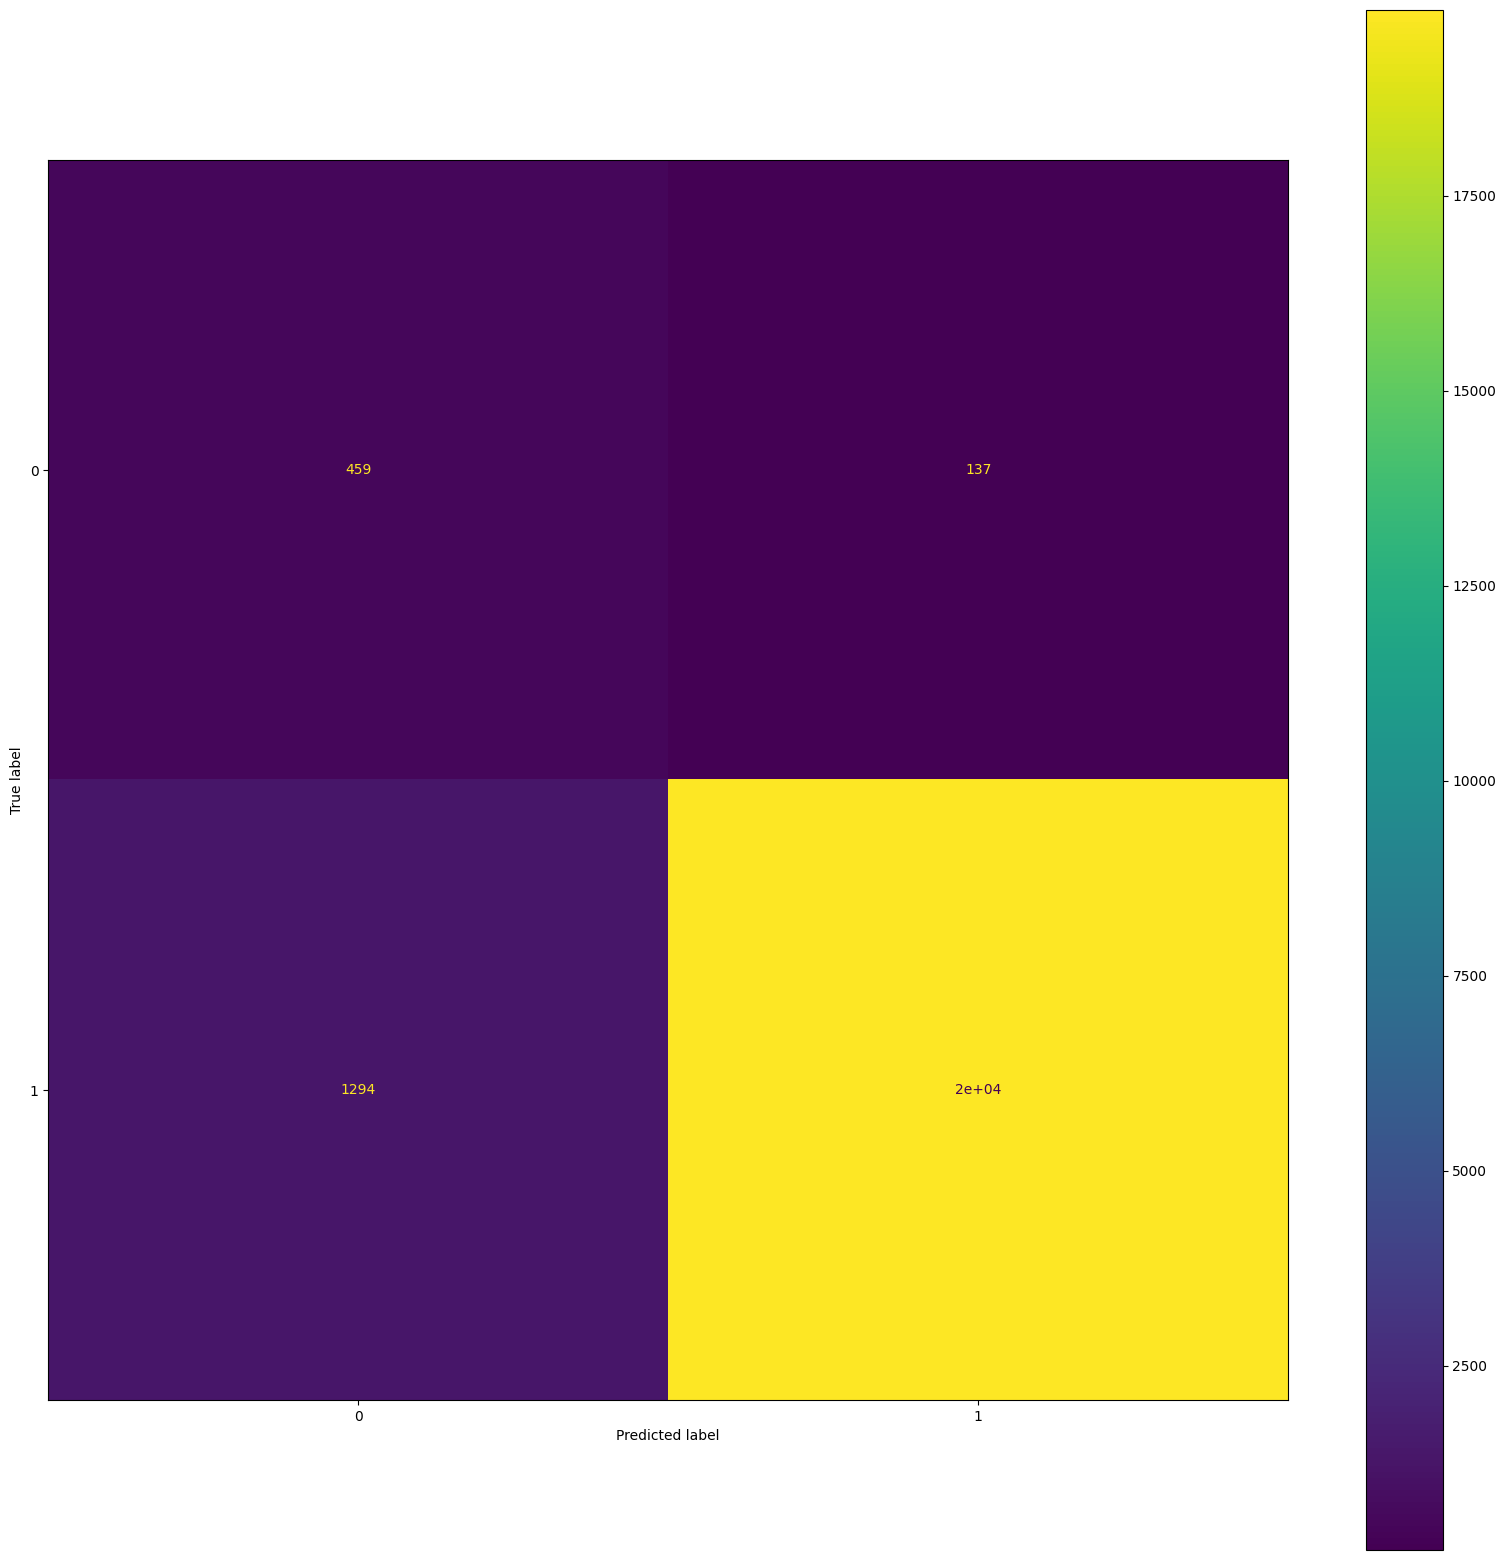

In [224]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,0]), y_valid_Cla.iloc[:,0])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

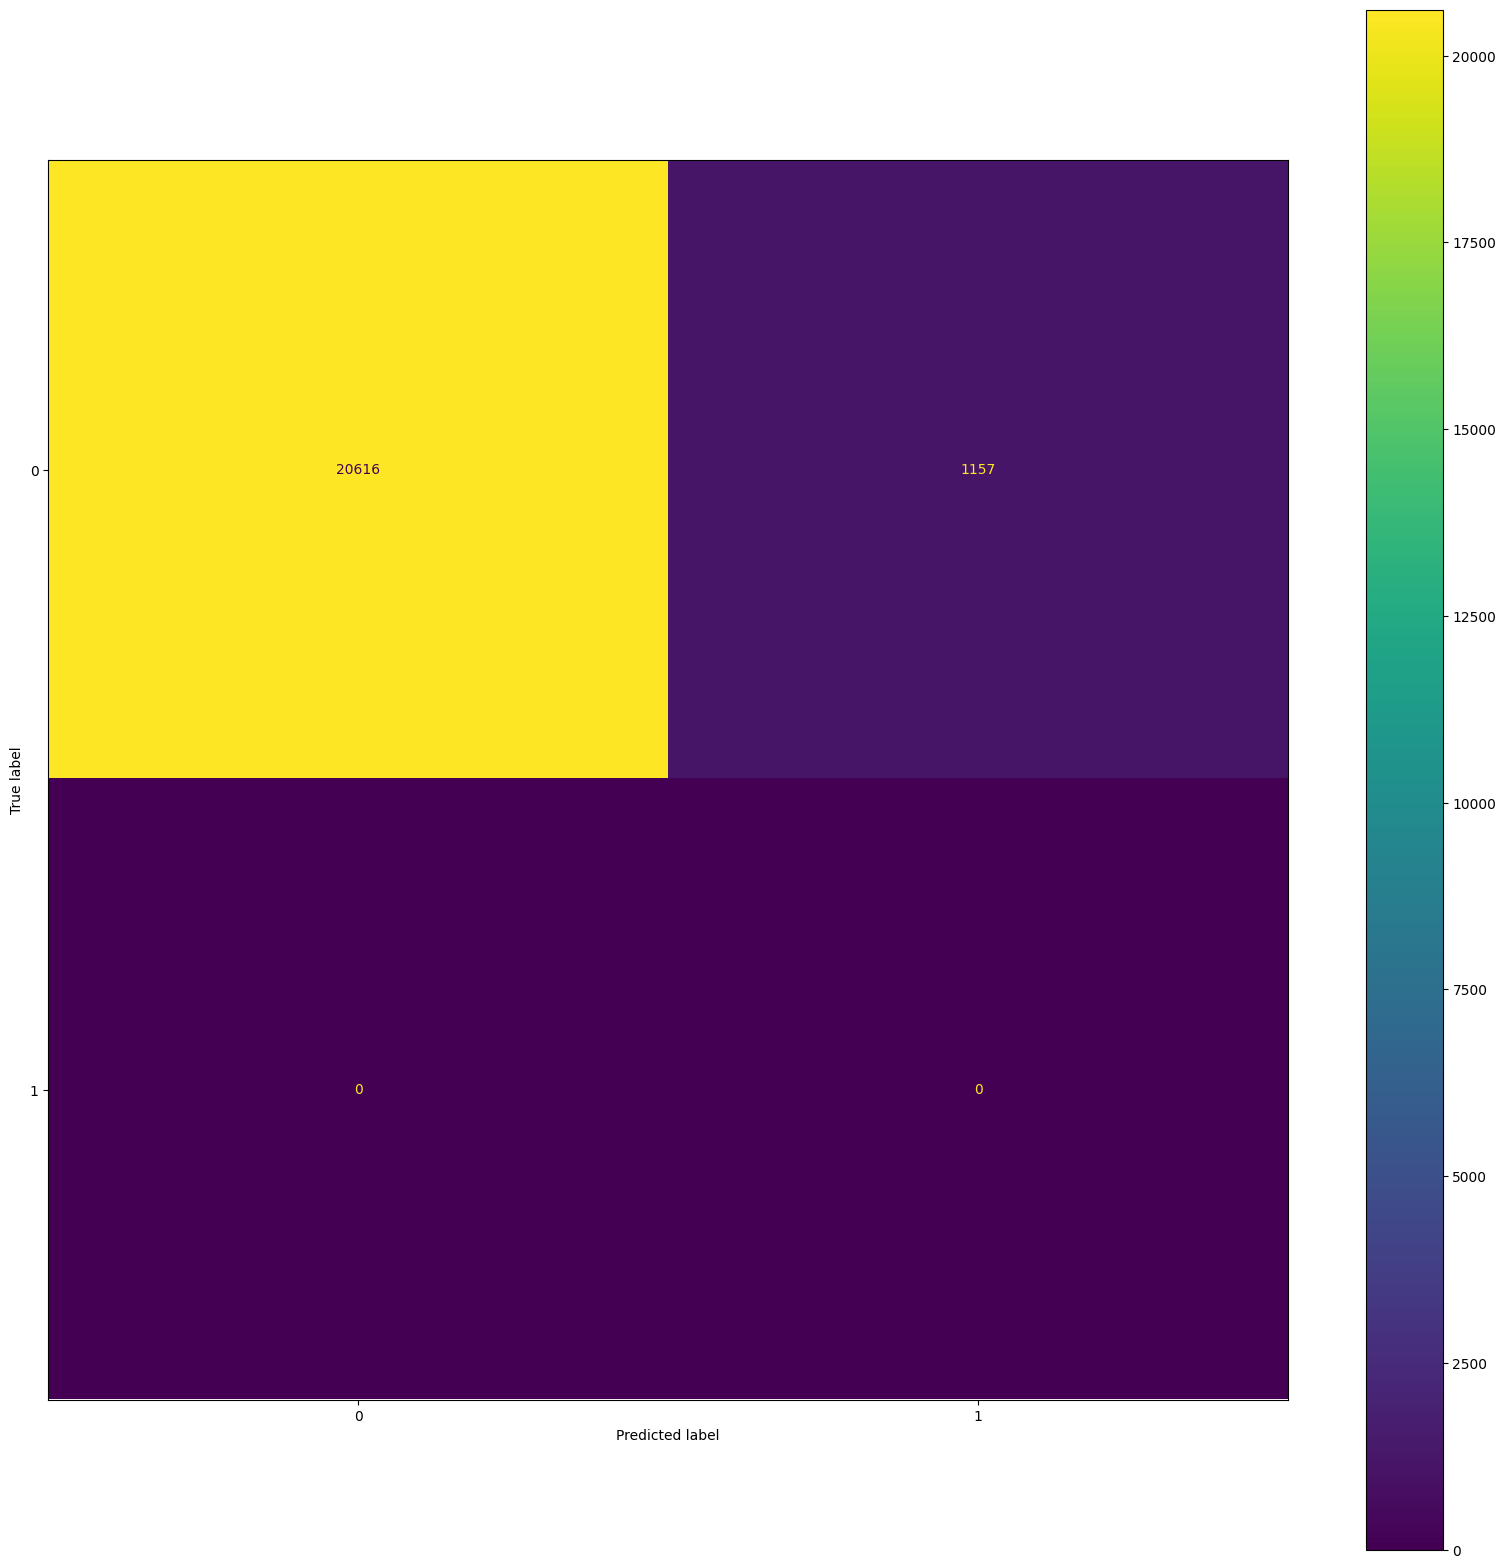

In [226]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,1]), y_valid_Cla.iloc[:,1])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

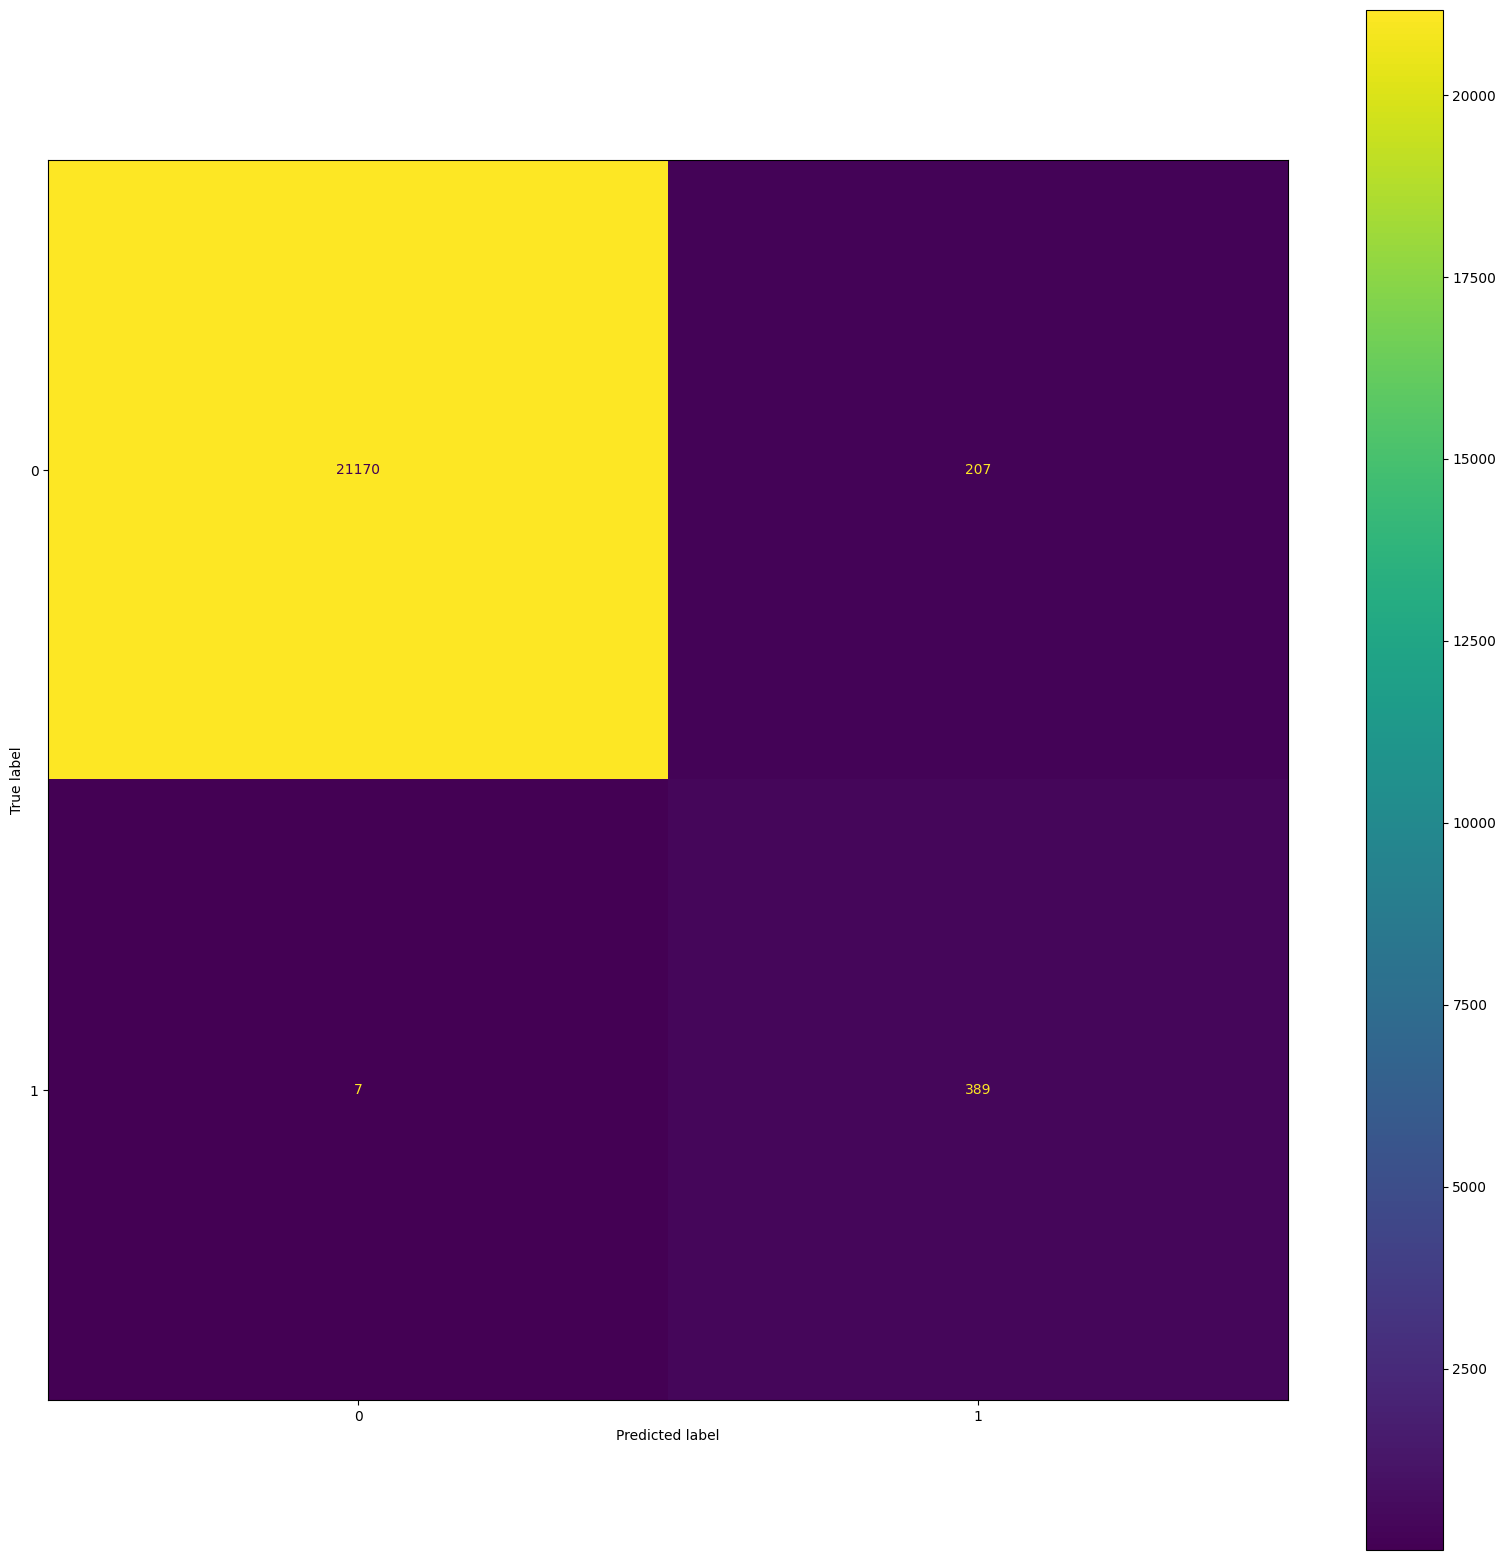

In [228]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:,2]), y_valid_Cla.iloc[:,2])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

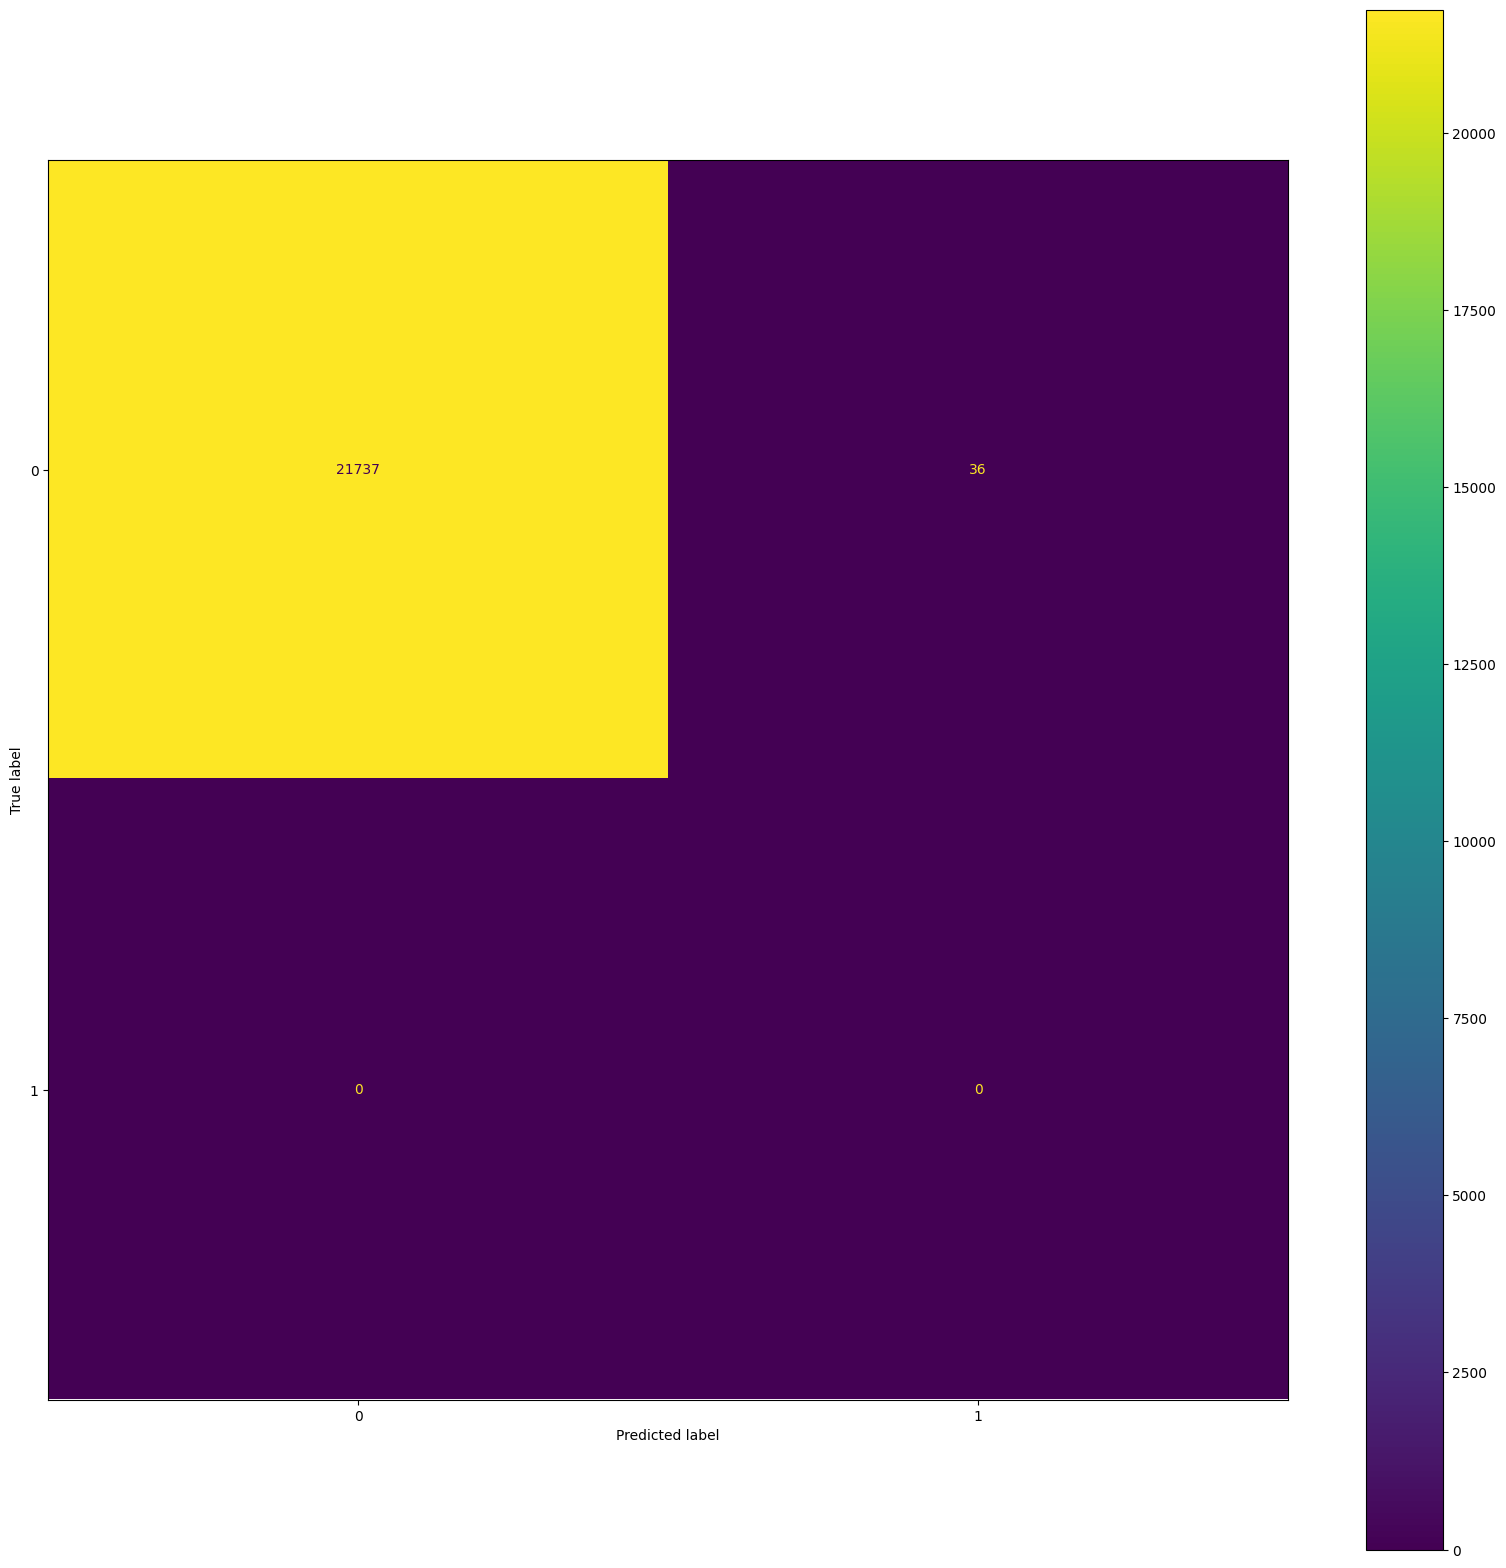

In [230]:
confusion_mat = confusion_matrix(np.round(Classifications.iloc[:, 4]), y_valid_Cla.iloc[:,4])
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()